# Medical Appointment No-Show

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import optuna
from optuna.pruners import HyperbandPruner

In [3]:
import scipy.stats as stats
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportion_confint
from phik import phik_matrix

In [4]:
from feature_engine.imputation import CategoricalImputer
from feature_engine.selection import DropFeatures
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder as fe_OneHotEncoder, MeanEncoder, OrdinalEncoder
from feature_engine.discretisation import ArbitraryDiscretiser
from feature_engine.transformation import BoxCoxTransformer, YeoJohnsonTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MinMaxScaler, RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, SelectKBest, SelectPercentile
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score, RandomizedSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, roc_curve, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

## Carga de datos

In [6]:
# Load the dataset from the CSV file
raw_data = pd.read_csv("appointments.csv")

In [7]:
df = raw_data.copy()

El conjunto de datos que has proporcionado parece estar relacionado con citas médicas de una compañía de seguros de salud. Aquí hay un resumen inicial de la estructura de los datos:

- **PatientId**: Identificador único para cada paciente (formato numérico grande).
- **AppointmentID**: Identificador único para cada cita.
- **Gender**: Género del paciente (F para femenino, M para masculino).
- **ScheduledDay**: Fecha y hora en que se programó la cita.
- **AppointmentDay**: Fecha de la cita.
- **Age**: Edad del paciente.
- **Neighbourhood**: Vecindario donde se atiende al paciente.
- **Scholarship**: Indica si el paciente está en un programa de ayuda social (0 = No, 1 = Sí).
- **Hipertension**: Indica si el paciente tiene hipertensión (0 = No, 1 = Sí).
- **Diabetes**: Indica si el paciente tiene diabetes (0 = No, 1 = Sí).
- **Alcoholism**: Indica si el paciente tiene problemas con el alcohol (0 = No, 1 = Sí).
- **Handcap**: Número que indica el nivel de discapacidad del paciente.
- **SMS_received**: Indica si el paciente recibió un SMS recordatorio de la cita (0 = No, 1 = Sí).
- **No-show**: Indica si el paciente no asistió a la cita (No = asistió)

## Analisis preliminar

### Analiso que los datos se hayan importado correctamente

In [8]:
df.head(5)

PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0      No  
1         0           0        0             0      No  
2         0           0        0             0      No  
3         0           0        0             0      No  
4         1           0        0             0      No

In [9]:
df.shape

(110527, 14)

### Verifico la forma en que se importaron los tipos de datos

In [10]:
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

### Analisis estadistico preliminar de las caracteristicas numéricas

In [11]:
# Estadísticas descriptivas de las columnas numéricas
df.describe()

PatientId  AppointmentID            Age    Scholarship  \
count  1.105270e+05   1.105270e+05  110527.000000  110527.000000   
mean   1.474963e+14   5.675305e+06      37.088874       0.098266   
std    2.560949e+14   7.129575e+04      23.110205       0.297675   
min    3.921784e+04   5.030230e+06      -1.000000       0.000000   
25%    4.172614e+12   5.640286e+06      18.000000       0.000000   
50%    3.173184e+13   5.680573e+06      37.000000       0.000000   
75%    9.439172e+13   5.725524e+06      55.000000       0.000000   
max    9.999816e+14   5.790484e+06     115.000000       1.000000   

        Hipertension       Diabetes     Alcoholism        Handcap  \
count  110527.000000  110527.000000  110527.000000  110527.000000   
mean        0.197246       0.071865       0.030400       0.022248   
std         0.397921       0.258265       0.171686       0.161543   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       4.000000   

        SMS_received  
count  110527.000000  
mean        0.321026  
std         0.466873  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

### Verifico el porcentaje de inasistencias en el conjunto de datos

In [12]:
df['No-show'].value_counts(True)

No-show
No     0.798067
Yes    0.201933
Name: proportion, dtype: float64

### Chequeo de valores nulos

In [13]:
i = 0
for col in list(df.columns):
    if df[col].isnull().mean() > 0:
        print(col, df[col].isnull().mean())
        i +=1
if i == 0:
    print('No hay caracteristicas con valores nulos')

No hay caracteristicas con valores nulos


### Chequeo de filas duplicadas

In [14]:
duplicated_rows = df.duplicated().sum()
print("Filas duplicadas encontradas:", duplicated_rows)

Filas duplicadas encontradas: 0


### Chequeo indices duplicados

In [15]:
duplicated_indices = df[df.index.duplicated(keep=False)]
duplicated_indices_sorted = duplicated_indices.sort_index()
duplicated_indices_sorted

Empty DataFrame
Columns: [PatientId, AppointmentID, Gender, ScheduledDay, AppointmentDay, Age, Neighbourhood, Scholarship, Hipertension, Diabetes, Alcoholism, Handcap, SMS_received, No-show]
Index: []

### Chequeo preliminar de caracteristicas categoricas y continuas

In [16]:
discrete = []

for var in list(df.columns):
    if len(df[var].unique()) < 25:
        print(var, ' values: ', df[var].nunique())
        discrete.append(var)
print()
print('There are {} discrete variables'.format(len(discrete)))

Gender  values:  2
Scholarship  values:  2
Hipertension  values:  2
Diabetes  values:  2
Alcoholism  values:  2
Handcap  values:  5
SMS_received  values:  2
No-show  values:  2

There are 8 discrete variables


In [17]:
cat_cols = df.select_dtypes(include=['category','object']).columns
num_cols = list(set(df.select_dtypes(include=['int', 'float']).columns) - set(discrete)- set(['PatientId', 'AppointmentID']))

In [18]:
print(num_cols)

['Age']


In [19]:
unique_values = {col: df[col].nunique() for col in cat_cols}
print(unique_values)

{'Gender': 2, 'ScheduledDay': 103549, 'AppointmentDay': 27, 'Neighbourhood': 81, 'No-show': 2}


### Analisis preliminar de la relacion entre las clases de las variables categoricas con la variable objetivo

In [20]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 3]

<Figure size 500x300 with 0 Axes>

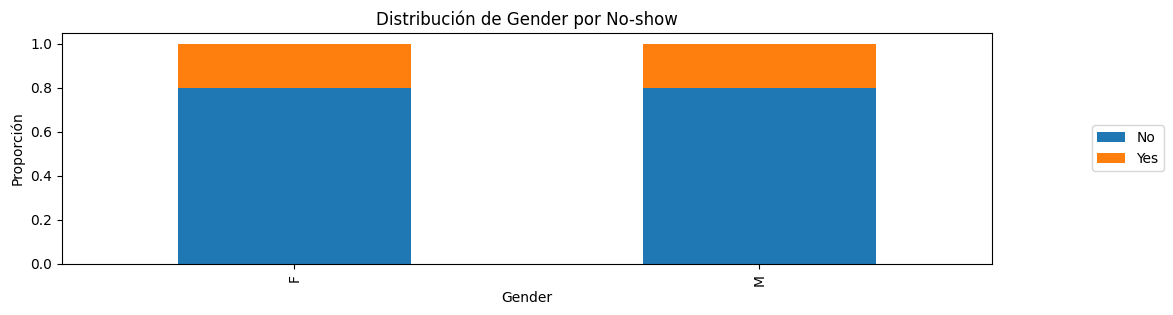

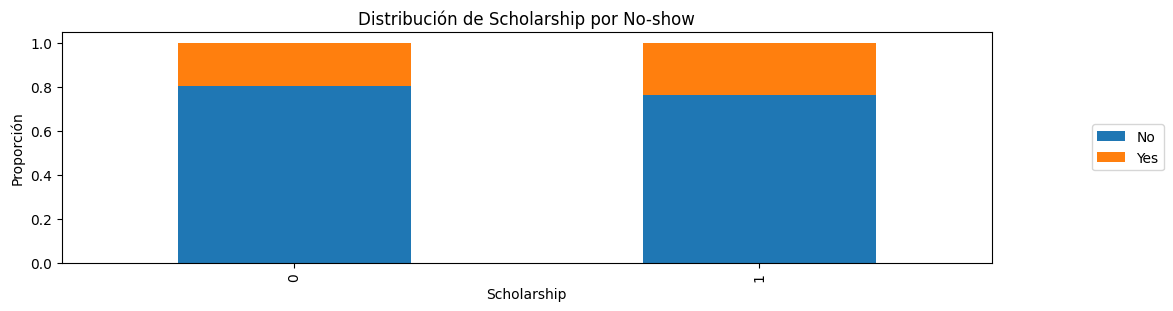

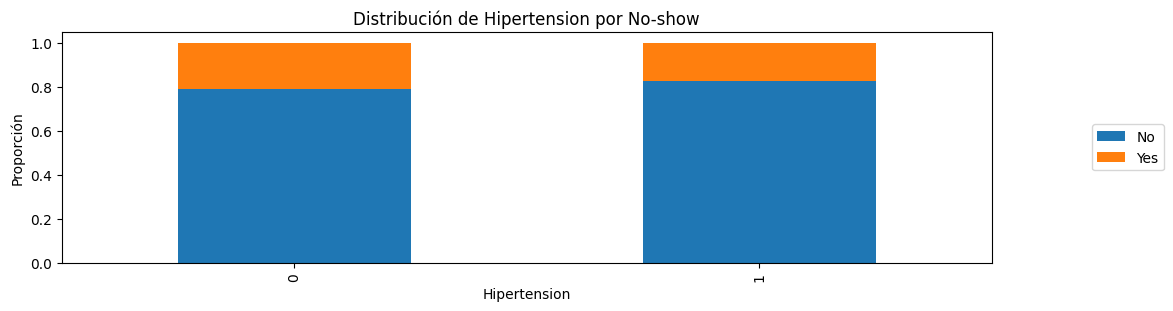

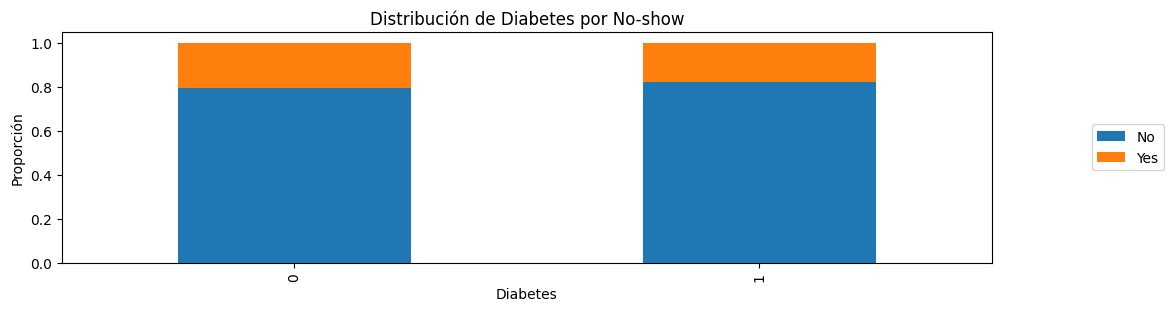

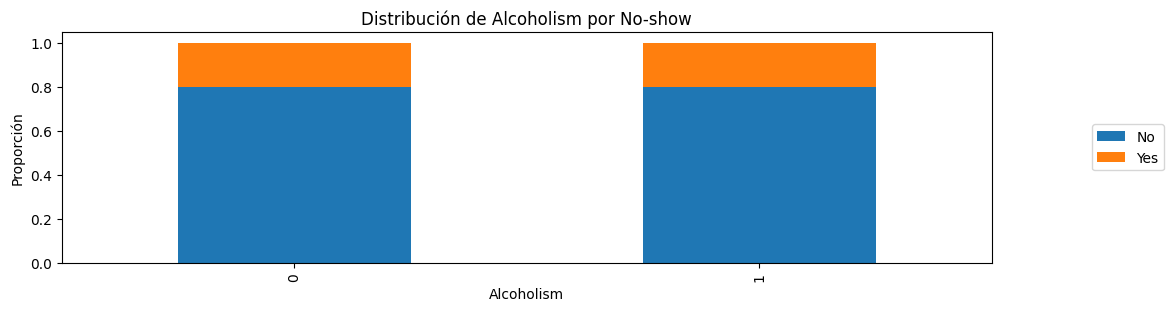

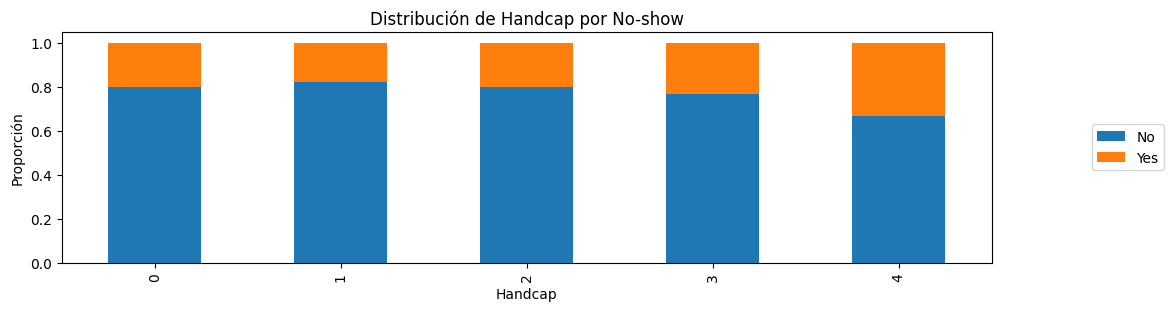

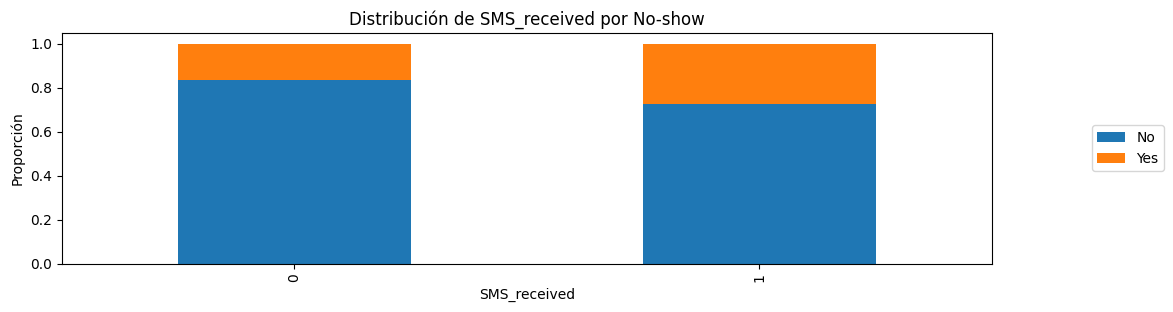

In [21]:
plt.figure(figsize=(5, 3))
for var in discrete:
    if (var != 'No-show' and var != 'ScheduledDay'):
        # Crear una tabla de frecuencias absolutas
        freq_table = pd.crosstab(df[var], df["No-show"])
        
        # Calcular la frecuencia máxima para ordenar
        freq_table['Max'] = freq_table.max(axis=1)
        
        # Ordenar las categorías por la frecuencia máxima de cada clase 
        freq_table = freq_table.sort_values(by='Max', ascending=False)

        # Graficar la tabla de frecuencias normalizadas
        freq_table[['No', 'Yes']].div(freq_table[['No', 'Yes']].sum(axis=1), axis=0).plot(kind="bar", stacked=True)
        
        plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center left')
        plt.title(f'Distribución de {var} por No-show')
        plt.xlabel(var)  
        plt.ylabel('Proporción') 
        plt.show()

### Analisis preliminar de la relacion entre las variables preliminares continuas con la variable objetivo

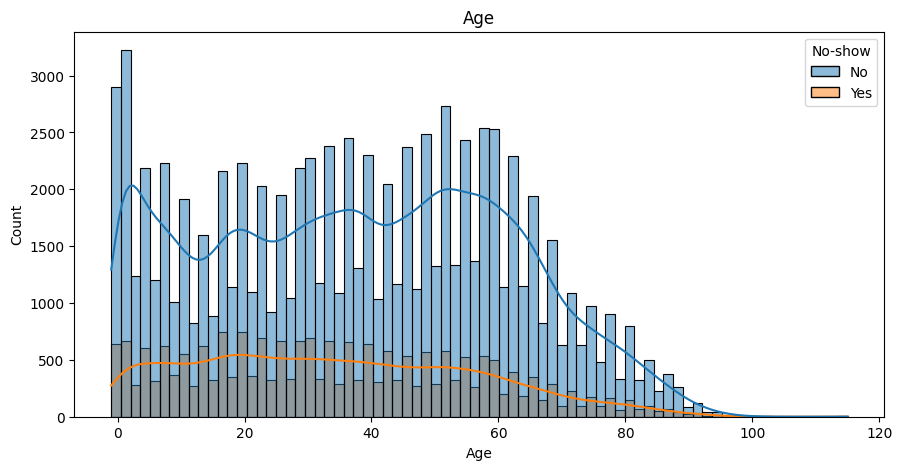

In [22]:
num_vars = len(num_cols)
num_cols_subplot = 1  # Usar una columna
num_rows_subplot = math.ceil(num_vars / num_cols_subplot)

# Aumentar el tamaño total de la figura
plt.figure(figsize=(12, 5 + (num_rows_subplot - 1) * 3))  # Ajusta el multiplicador según sea necesario

for i, var in enumerate(num_cols):
    plt.subplot(num_rows_subplot, num_cols_subplot, i + 1)
    sns.histplot(data=df, x=var, stat="count", kde=True, hue='No-show')
    plt.title(var)  # Añadir título a cada subplot


# Ajustar espacio entre filas
plt.subplots_adjust(hspace=0.5, right=0.8)  # Dejar espacio a la derecha para la leyenda

plt.show()

### Analisis preliminar de correlaciones

interval columns not set, guessing: ['PatientId', 'AppointmentID', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']


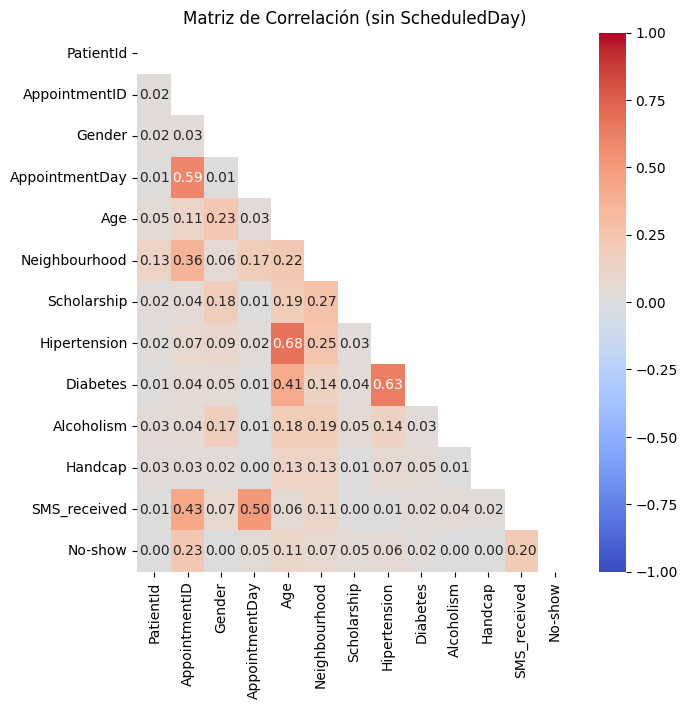

In [23]:
# Calcular la matriz de correlación usando phik, excluyendo 'ScheduledDay'
corr_matrix = df.drop(columns=['ScheduledDay']).phik_matrix()

# Crear una máscara para el triángulo superior
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Graficar la matriz de correlación
plt.figure(figsize=(7, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask, vmin=-1, vmax=1)
plt.title('Matriz de Correlación (sin ScheduledDay)')
plt.show()

## Separo el conjunto de datos en los conjuntos de entrenamiento y prueba
Como en el conjunto de datos las personas pueden sacar más de un turno es conveniente que todos los registros de una persona se encuentren o en el conjunto de entrenamiento o en el de prueba

In [24]:
df.head(3)

PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   

         AppointmentDay  Age    Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62  JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56  JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62    MATA DA PRAIA            0             0   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0      No  
1         0           0        0             0      No  
2         0           0        0             0      No

In [25]:
df = df.sample(frac=1, random_state=420)

In [26]:
df.head(3)

PatientId  AppointmentID Gender          ScheduledDay  \
64200   5.386962e+14        5683301      M  2016-05-11T07:24:56Z   
91954   1.923469e+12        5762681      F  2016-06-02T08:02:40Z   
104581  4.313958e+11        5776669      F  2016-06-06T11:37:49Z   

              AppointmentDay  Age   Neighbourhood  Scholarship  Hipertension  \
64200   2016-05-11T00:00:00Z   36        GURIGICA            0             0   
91954   2016-06-02T00:00:00Z   59      MONTE BELO            0             0   
104581  2016-06-08T00:00:00Z   70  JARDIM CAMBURI            0             0   

        Diabetes  Alcoholism  Handcap  SMS_received No-show  
64200          0           0        0             0      No  
91954          0           0        0             0      No  
104581         0           0        0             0      No

In [27]:
X = df.drop(columns = "No-show")
y = df.loc[:, ['No-show']]

In [28]:
X.head(4)

PatientId  AppointmentID Gender          ScheduledDay  \
64200   5.386962e+14        5683301      M  2016-05-11T07:24:56Z   
91954   1.923469e+12        5762681      F  2016-06-02T08:02:40Z   
104581  4.313958e+11        5776669      F  2016-06-06T11:37:49Z   
11678   7.323343e+12        5699513      F  2016-05-16T08:35:36Z   

              AppointmentDay  Age   Neighbourhood  Scholarship  Hipertension  \
64200   2016-05-11T00:00:00Z   36        GURIGICA            0             0   
91954   2016-06-02T00:00:00Z   59      MONTE BELO            0             0   
104581  2016-06-08T00:00:00Z   70  JARDIM CAMBURI            0             0   
11678   2016-05-16T00:00:00Z   32        REDENÇÃO            0             0   

        Diabetes  Alcoholism  Handcap  SMS_received  
64200          0           0        0             0  
91954          0           0        0             0  
104581         0           0        0             0  
11678          0           0        0             0

In [29]:
y.head(4)

No-show
64200       No
91954       No
104581      No
11678       No

In [30]:
# Define la semilla para la aleatoriedad
seed = 7
np.random.seed(seed)

In [31]:
# Paso 1: Mezcla los IDs de los pacientes aleatoriamente
unique_patient_ids = df['PatientId'].unique()
np.random.shuffle(unique_patient_ids)

# Paso 2: Reasigna a cada paciente un nuevo grupo en el orden aleatorio
patient_id_mapping = {patient_id: idx for idx, patient_id in enumerate(unique_patient_ids)}
df['ShuffledGroup'] = df['PatientId'].map(patient_id_mapping)

# Paso 3: Usa `GroupKFold` con los grupos aleatorizados
gkf = GroupKFold(n_splits = 5)
groups = df['ShuffledGroup']

for train_idx, test_idx in gkf.split(X, y, groups=groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [32]:
# Comprobar si hay coincidencias de pacientes entre X_train y X_test
common_patients = X_train['PatientId'][X_train['PatientId'].isin(X_test['PatientId'])]
common_patients

Series([], Name: PatientId, dtype: float64)

In [33]:
X_train.shape

(88422, 13)

In [34]:
X_test.shape

(22105, 13)

In [35]:
y_train

No-show
64200      No
91954      No
11678      No
84806      No
2761       No
...       ...
1209       No
47022      No
62239      No
21055      No
11185     Yes

[88422 rows x 1 columns]

### Calculo el porcentaje de No-Shows en cada subconjunto

In [36]:
# Calcular el porcentaje de No-show en y_train
porcentaje_no_show_train = (y_train == 'Yes').sum() / len(y_train) * 100
# Acceder al valor escalar
porcentaje_no_show_train = float(porcentaje_no_show_train.iloc[0])
print(f"Porcentaje de No-show en y_train: {porcentaje_no_show_train:.2f}%")

# Calcular el porcentaje de No-show en y_test
porcentaje_no_show_test = (y_test == 'Yes').sum() / len(y_test) * 100
# Acceder al valor escalar
porcentaje_no_show_test = float(porcentaje_no_show_test.iloc[0])
print(f"Porcentaje de No-show en y_test: {porcentaje_no_show_test:.2f}%")

Porcentaje de No-show en y_train: 20.09%
Porcentaje de No-show en y_test: 20.61%


### Verifico que los indicen de las variables independientes sean los mismos y esten en el mismo orden que el de las dependientes

In [37]:
all(X_train.index == y_train.index)

True

In [38]:
all(X_test.index == y_test.index)

True

## Ingenieria de datos

### Analisis de las caracteristicas

#### **AppointmentID**: No tiene poder predictivo, ya que es un codigo que ayuda para la gestion de los turnos utiliza el hospital

In [39]:
# Elimino la caracteristica AppointmentID
drop_feature_AppointmentID = DropFeatures(features_to_drop=['AppointmentID'])
X_train = drop_feature_AppointmentID.fit_transform(X_train)
X_test = drop_feature_AppointmentID.transform(X_test)

In [40]:
# Para el pipeline no es necesario crear una clase 
# ('drop_feature_AppointmentID', drop_feature_AppointmentID),

#### **Neighbourhood**: esta caracteristica tiene una alta cardinalidad. Además, algunos de sus valores se pueden observar solo una pocas veces

In [41]:
df_train = X_train.copy()
df_train['No-show'] = y_train

# Crear la tabla de contingencia
contingency_table = pd.crosstab(df_train['Neighbourhood'], df_train['No-show'])

# Añadir fila de totales por barrio
contingency_table.loc['Total'] = contingency_table.sum()

# Añadir columna de totales
contingency_table['Total'] = contingency_table.sum(axis=1)

# Ordenar la tabla por la columna 'Total' de mayor a menor
contingency_table = contingency_table.sort_values(by='Total', ascending=False).drop('Total', axis=0)

# Mostrar la tabla de contingencia
contingency_table

No-show                        No   Yes  Total
Neighbourhood                                 
JARDIM CAMBURI               4944  1177   6121
MARIA ORTIZ                  3620   970   4590
RESISTÊNCIA                  2846   712   3558
JARDIM DA PENHA              2562   495   3057
ITARARÉ                      2093   755   2848
...                           ...   ...    ...
ILHA DO BOI                    25     3     28
AEROPORTO                       7     1      8
ILHA DO FRADE                   5     2      7
ILHAS OCEÂNICAS DE TRINDADE     0     1      1
PARQUE INDUSTRIAL               1     0      1

[81 rows x 3 columns]

In [42]:
contingency_table['no_show_rate'] = contingency_table['Yes']/contingency_table['Total']
contingency_table.tail(8)

No-show                      No  Yes  Total  no_show_rate
Neighbourhood                                            
NAZARETH                     89   25    114      0.219298
MORADA DE CAMBURI            55   11     66      0.166667
PONTAL DE CAMBURI            51   11     62      0.177419
ILHA DO BOI                  25    3     28      0.107143
AEROPORTO                     7    1      8      0.125000
ILHA DO FRADE                 5    2      7      0.285714
ILHAS OCEÂNICAS DE TRINDADE   0    1      1      1.000000
PARQUE INDUSTRIAL             1    0      1      0.000000

#### Codificar los barrios que tengan 100 o menos observaciones

In [43]:
tol_value = 100 / len(df)  # Para el umbral deseado (en cantidad de observaciones) se calcula el porcentaje correspondiente

rare_encoder = RareLabelEncoder(
    tol = tol_value,  # Umbral basado en la cantidad fija
    n_categories = 20,
    variables=[
        "Neighbourhood"
    ],
    replace_with='Other',
)

In [44]:
tol_value

0.0009047563038895474

In [45]:
rare_encoder.fit(X_train)

RareLabelEncoder(n_categories=20, replace_with='Other',
                 tol=0.0009047563038895474, variables=['Neighbourhood'])

In [46]:
X_train_rare_label = rare_encoder.transform(X_train)
X_test_rare_label = rare_encoder.transform(X_test)

In [47]:
# Para el pipe no hace falta crear una clase

In [48]:
df_train = X_train_rare_label.copy()
df_train['No-show'] = y_train

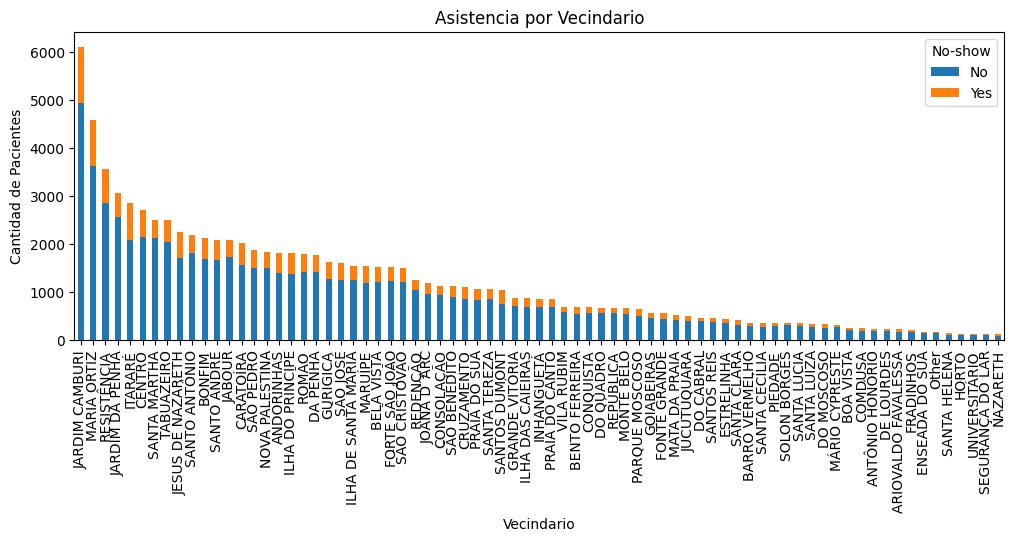

In [49]:
# Contar y apilar
counts = df_train.groupby(['Neighbourhood', 'No-show']).size().unstack(fill_value=0)

# Sumar las filas para obtener totales por vecindario
counts['Total'] = counts.sum(axis=1)

# Ordenar el DataFrame por el total de pacientes en orden decreciente
counts = counts.sort_values(by='Total', ascending=False).drop('Total', axis=1)

# Crear el gráfico de barras apiladas
counts.plot(kind='bar', stacked=True, figsize=(12, 4))

plt.title('Asistencia por Vecindario')
plt.ylabel('Cantidad de Pacientes')
plt.xlabel('Vecindario')
plt.xticks(rotation=90)
plt.show()

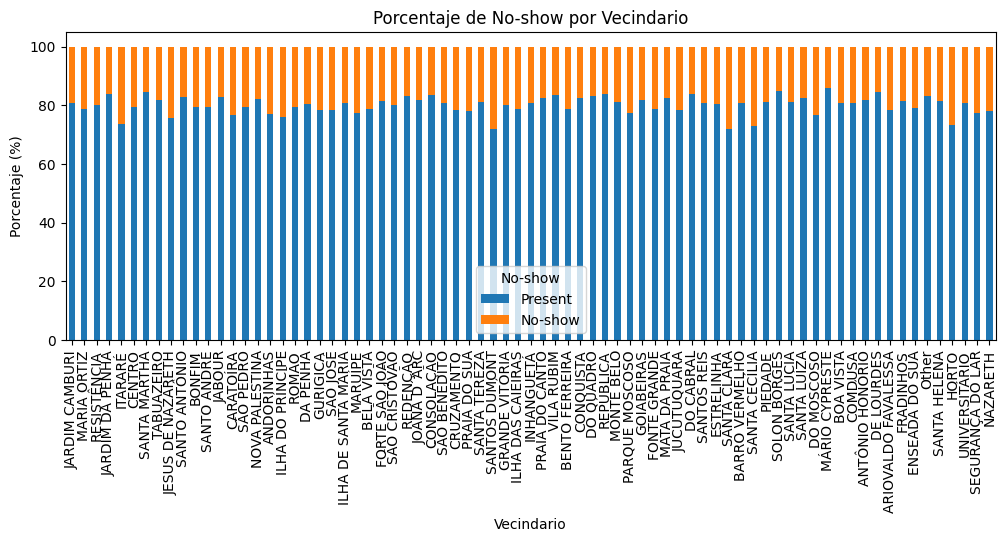

In [50]:
# Contar y apilar
counts = df_train.groupby(['Neighbourhood', 'No-show']).size().unstack(fill_value=0)
# Ordenar el DataFrame por el total de pacientes en orden decreciente
counts['Total'] = counts.sum(axis=1)
counts = counts.sort_values(by='Total', ascending=False).drop('Total', axis=1)

# Calcular el porcentaje de No-show
percentage = counts.div(counts.sum(axis=1), axis=0) * 100  # Convertir a porcentaje

# Sumar las filas para obtener totales por vecindario
percentage['Total'] = percentage.sum(axis=1)
percentage = percentage.drop('Total', axis=1)

# Crear el gráfico de barras apiladas
percentage.plot(kind='bar', stacked=True, figsize=(12, 4))

plt.title('Porcentaje de No-show por Vecindario')
plt.ylabel('Porcentaje (%)')
plt.xlabel('Vecindario')
plt.xticks(rotation=90)
plt.legend(title='No-show', labels=['Present', 'No-show'])
plt.show()

### Analizar diferentes alternativas para codificar los barrios

Primer alternativa: **metodo de smoothing mean encoding** que reemplazará cada una de los nombres de los barrios por la cantidad media correspondiente de veces que los pacientes no se presentaron con el objetivo de crear una relacion monotonica entre esta nueva caracteristica con la variable objetivo. Es smoothing porque al calcular la media tendrá en cuenta un peso que refleje la diferencia entre la media del conjunto de entrenamiento con la media del conjunto de datos total. 

#### Transformar la variable objetivo en dummies 

In [51]:
y_train.loc[:, 'No-show'] = y_train['No-show'].map({'Yes': 1, 'No': 0})
y_test.loc[:, 'No-show'] = y_test['No-show'].map({'Yes': 1, 'No': 0})

In [52]:
y_train.dtypes

No-show    object
dtype: object

In [53]:
y_train = y_train['No-show'].astype('int')
y_test = y_test['No-show'].astype('int')

In [54]:
mean_enc = MeanEncoder(variables=["Neighbourhood"])

In [55]:
# when fitting the transformer, we need to pass the target as well
mean_enc.fit(X_train_rare_label, y_train)

MeanEncoder(variables=['Neighbourhood'])

In [56]:
X_train_1_enco = mean_enc.transform(X_train_rare_label)
X_test_1_enco = mean_enc.transform(X_test_rare_label)

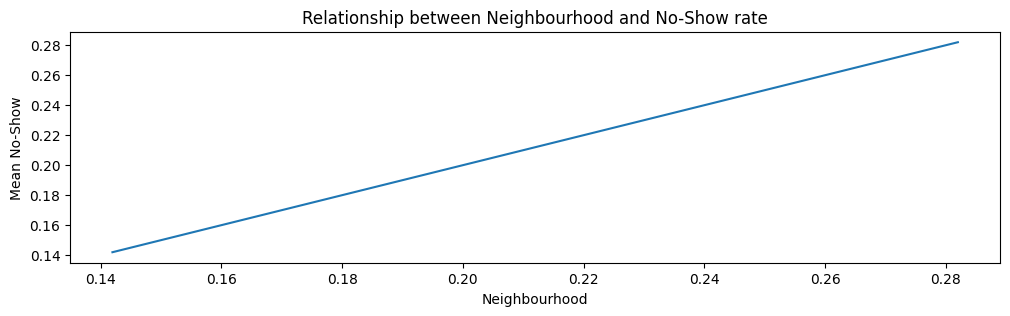

In [57]:
fig = plt.figure()
fig = y_train.groupby(X_train_1_enco["Neighbourhood"]).mean().plot()
fig.set_title("Relationship between {} and No-Show rate".format("Neighbourhood"))
fig.set_ylabel("Mean No-Show")
plt.show()

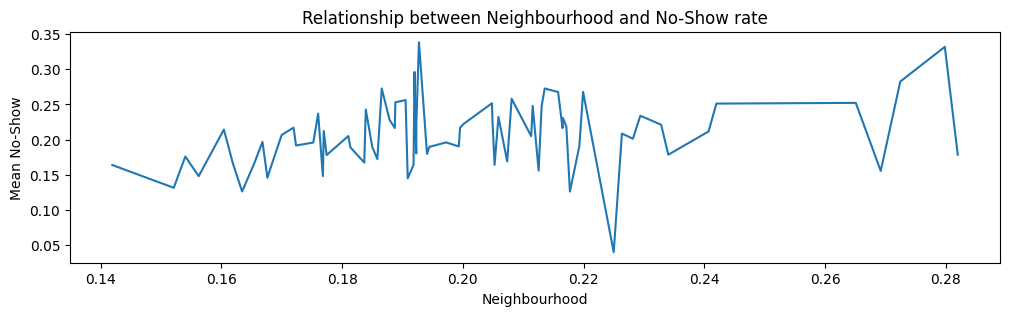

In [58]:
fig = plt.figure()
fig = y_test.groupby(X_test_1_enco["Neighbourhood"]).mean().plot()
fig.set_title("Relationship between {} and No-Show rate".format("Neighbourhood"))
fig.set_ylabel("Mean No-Show")
plt.show()

##### Dado que en en los datos de prueba no hay mucho ruido y el patron no es similar a una funcion monotona, esta forma de codificación puede **no** ser la ideal.

Segunda alternativa: **método de codificación ordinal** que asignará un valor numérico a cada categoría de la variable categórica según un orden específico predefinido. 

In [59]:
ordinal_enc = OrdinalEncoder(
    encoding_method="ordered",
    variables=["Neighbourhood"],
)

In [60]:
ordinal_enc.fit(X_train_rare_label, y_train)

OrdinalEncoder(variables=['Neighbourhood'])

In [61]:
X_train_2_enco = ordinal_enc.transform(X_train_rare_label)
X_test_2_enco = ordinal_enc.transform(X_test_rare_label)

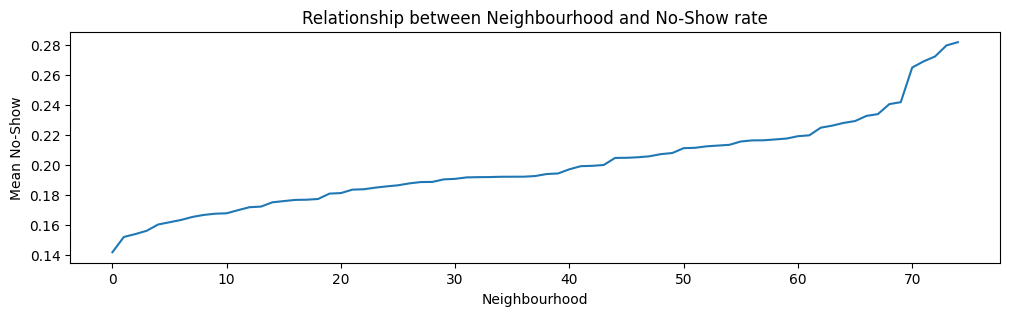

In [62]:
fig = plt.figure()
fig = y_train.groupby(X_train_2_enco["Neighbourhood"]).mean().plot()
fig.set_title("Relationship between {} and No-Show rate".format("Neighbourhood"))
fig.set_ylabel("Mean No-Show")
plt.show()

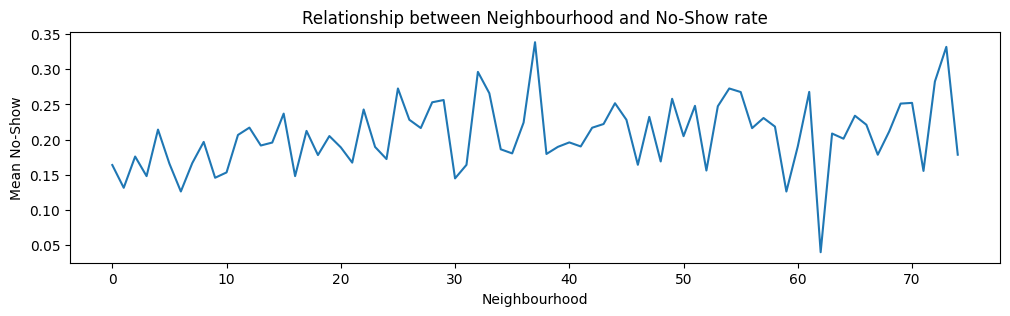

In [63]:
fig = plt.figure()
fig = y_test.groupby(X_test_2_enco["Neighbourhood"]).mean().plot()
fig.set_title("Relationship between {} and No-Show rate".format("Neighbourhood"))
fig.set_ylabel("Mean No-Show")
plt.show()

##### No es de extrañar que la codificacion ordinal ordenada tenga un comportamiento similar o incluso peor que la codificación media suavizada

#### Otras alternativas alternativas:
 1. Transformar la caracteristica Neighbourhood en dummies, lo cual aumentará el costo computacional de los modelos. Si se utilizan arboles puede hacer que sean muy profundos, en regresion logistica puede ser util.
 2. Eliminar la caracteristica Neighbourhood. Perdida de información
 3. Agrupar por commportamiento de forma tal que sus proporciones de no-show se encuentran en determinado rango, en lo posible en su rango de confianza. Posible perdida de información y dificultad de determinar los mejores intervalos.

Se selecciona la tercer opción ya que no aumenta el tamaño del conjunto de datos y puede mantener poder predictivo

In [64]:
# Crear la tabla de contingencia
df_train = X_train_rare_label.copy()
df_train['No-show'] = y_train

contingency_table = pd.crosstab(df_train['Neighbourhood'], df_train['No-show'])

# Añadir fila de totales por barrio
contingency_table.loc['Total'] = contingency_table.sum()

# Añadir columna de totales
contingency_table['Total'] = contingency_table.sum(axis=1)

# Ordenar la tabla por la columna 'Total' de mayor a menor
contingency_table = contingency_table.sort_values(by='Total', ascending=False).drop('Total', axis=0)

# Calcular la proporción de ausencias y el intervalo de confianza para cada barrio
conf_intervals = []

for neighbourhood in contingency_table.index:
    n_total = contingency_table.loc[neighbourhood, 0] + contingency_table.loc[neighbourhood, 1]  # total de citas
    n_no_show = contingency_table.loc[neighbourhood, 1]  # ausencias
    
    # Proporción de ausencias
    p = n_no_show / n_total
    
    # Calcular intervalo de confianza (95%)
    ci_low, ci_high = proportion_confint(n_no_show, n_total, alpha=0.05, method='normal')
    
    # Agregar el intervalo a la lista
    conf_intervals.append((p, ci_low, ci_high))

# Crear una nueva columna en la tabla para el intervalo de confianza
contingency_table['Proporción de ausencias'] = [x[0] for x in conf_intervals]
contingency_table['IC Inferior'] = [x[1] for x in conf_intervals]
contingency_table['IC Superior'] = [x[2] for x in conf_intervals]

# Mostrar la tabla final
contingency_table = contingency_table.drop(columns=[0, 1])
contingency_table

No-show           Total  Proporción de ausencias  IC Inferior  IC Superior
Neighbourhood                                                             
JARDIM CAMBURI     6121                 0.192289     0.182416     0.202162
MARIA ORTIZ        4590                 0.211329     0.199518     0.223140
RESISTÊNCIA        3558                 0.200112     0.186966     0.213259
JARDIM DA PENHA    3057                 0.161923     0.148865     0.174982
ITARARÉ            2848                 0.265098     0.248888     0.281309
...                 ...                      ...          ...          ...
SANTA HELENA        134                 0.186567     0.120608     0.252526
HORTO               130                 0.269231     0.192983     0.345479
UNIVERSITÁRIO       125                 0.192000     0.122952     0.261048
SEGURANÇA DO LAR    120                 0.225000     0.150286     0.299714
NAZARETH            114                 0.219298     0.143343     0.295253

[75 rows x 4 columns]

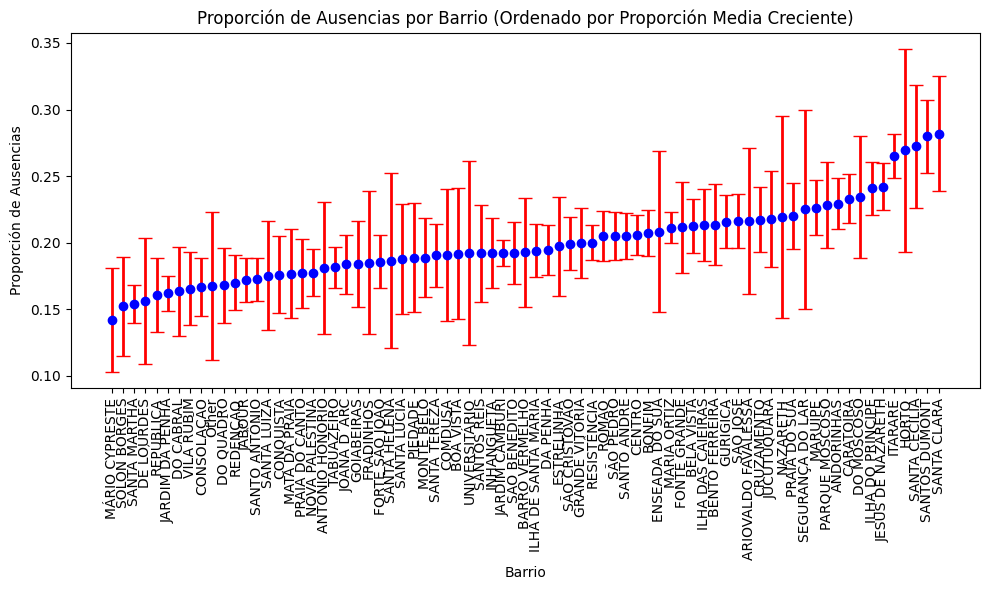

In [65]:
# Ordenar por la proporción de ausencias (de menor a mayor)
sorted_by_proportion = contingency_table.sort_values(by='Proporción de ausencias', ascending=True)

# Graficar
plt.figure(figsize=(10, 6))

# Usamos un gráfico de intervalo para visualizar los intervalos de confianza
plt.errorbar(sorted_by_proportion.index, 
             sorted_by_proportion['Proporción de ausencias'], 
             yerr=[sorted_by_proportion['Proporción de ausencias'] - sorted_by_proportion['IC Inferior'],
                   sorted_by_proportion['IC Superior'] - sorted_by_proportion['Proporción de ausencias']],
             fmt='o', 
             color='blue', 
             ecolor='red', 
             elinewidth=2, 
             capsize=5)

# Personalizar el gráfico
plt.title('Proporción de Ausencias por Barrio (Ordenado por Proporción Media Creciente)')
plt.xlabel('Barrio')
plt.ylabel('Proporción de Ausencias')
plt.xticks(rotation=90)  # Rotar nombres de los barrios si son largos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

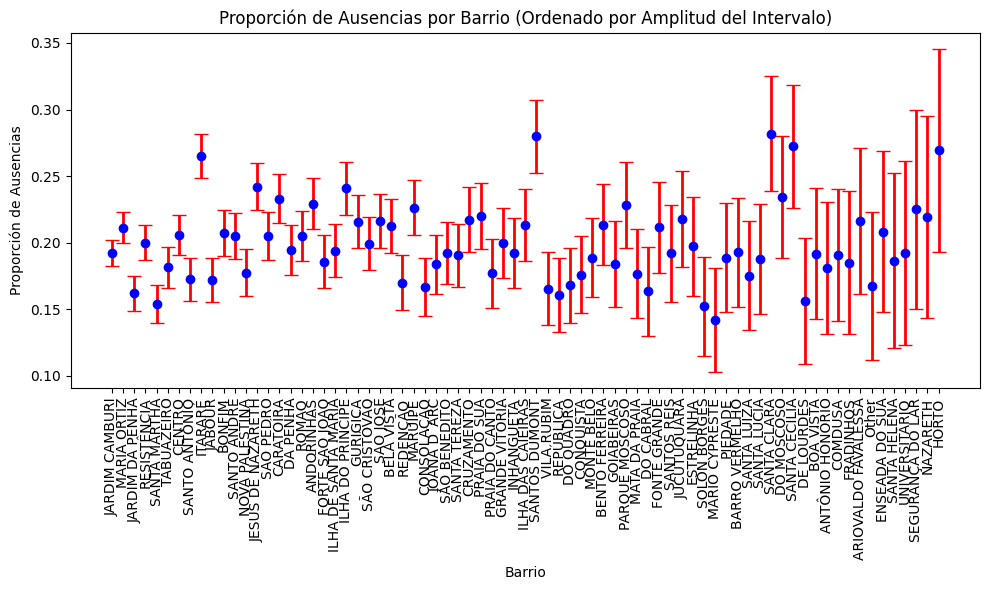

In [66]:
# Calcular la amplitud del intervalo como la diferencia entre IC Superior e IC Inferior
contingency_table['Amplitud Intervalo'] = contingency_table['IC Superior'] - contingency_table['IC Inferior']

# Ordenar por la amplitud del intervalo (de menor a mayor)
sorted_by_amplitude = contingency_table.sort_values(by='Amplitud Intervalo', ascending=True)

# Graficar
plt.figure(figsize=(10, 6))

# Usamos un gráfico de intervalo para visualizar los intervalos de confianza
plt.errorbar(sorted_by_amplitude.index, 
             sorted_by_amplitude['Proporción de ausencias'], 
             yerr=[sorted_by_amplitude['Proporción de ausencias'] - sorted_by_amplitude['IC Inferior'],
                   sorted_by_amplitude['IC Superior'] - sorted_by_amplitude['Proporción de ausencias']],
             fmt='o', 
             color='blue', 
             ecolor='red', 
             elinewidth=2, 
             capsize=5)

# Personalizar el gráfico
plt.title('Proporción de Ausencias por Barrio (Ordenado por Amplitud del Intervalo)')
plt.xlabel('Barrio')
plt.ylabel('Proporción de Ausencias')
plt.xticks(rotation=90)  # Rotar nombres de los barrios si son largos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [67]:
# Seleccionamos las columnas de interés (proporción de ausencias y amplitud del intervalo)
X = contingency_table[['Proporción de ausencias', 'Amplitud Intervalo']]

# Aplicamos K-means 
kmeans = KMeans(n_clusters= 4, random_state=42)
contingency_table['Grupo Clúster'] = kmeans.fit_predict(X)

# Mostrar los grupos
contingency_table[['Proporción de ausencias', 'Amplitud Intervalo', 'Grupo Clúster']]

C:\Users\germa\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


No-show           Proporción de ausencias  Amplitud Intervalo  Grupo Clúster
Neighbourhood                                                               
JARDIM CAMBURI                   0.192289            0.019746              0
MARIA ORTIZ                      0.211329            0.023621              0
RESISTÊNCIA                      0.200112            0.026292              0
JARDIM DA PENHA                  0.161923            0.026117              0
ITARARÉ                          0.265098            0.032421              2
...                                   ...                 ...            ...
SANTA HELENA                     0.186567            0.131918              1
HORTO                            0.269231            0.152496              3
UNIVERSITÁRIO                    0.192000            0.138095              1
SEGURANÇA DO LAR                 0.225000            0.149427              3
NAZARETH                         0.219298            0.151910              3

[75 rows x 3 columns]

In [68]:
# Ordenamos la tabla por los grupos de clúster
sorted_by_group = contingency_table.sort_values(by='Grupo Clúster')

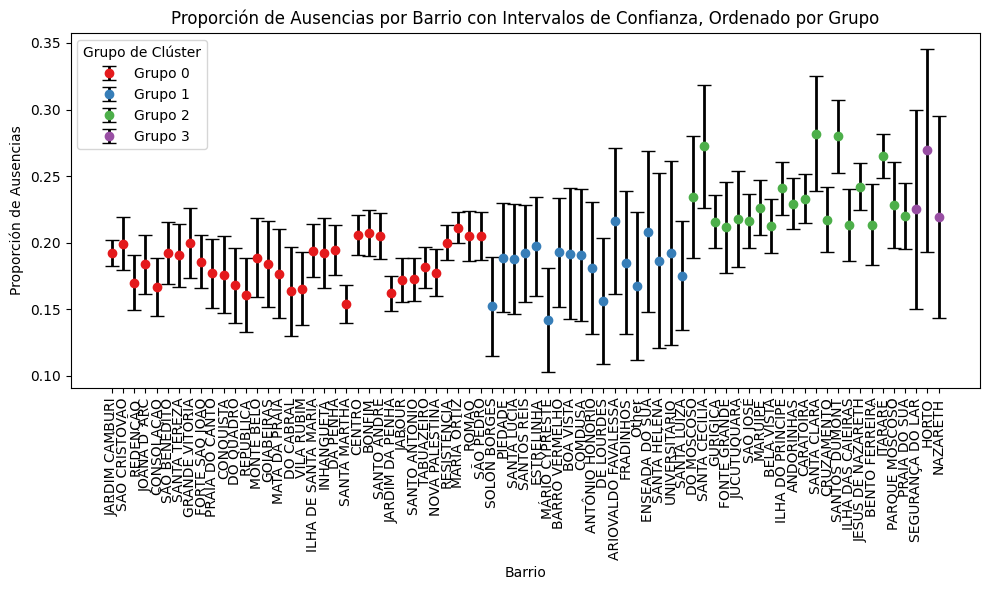

In [69]:
# Crear una paleta de colores para los 5 grupos
palette = sns.color_palette("Set1", n_colors=5)

# Graficar los intervalos de confianza con colores por grupo
plt.figure(figsize=(10, 6))

# Graficamos los intervalos de confianza, con 'errorbar' y usando el color de cada grupo
for i, group in enumerate(sorted_by_group['Grupo Clúster'].unique()):
    group_data = sorted_by_group[sorted_by_group['Grupo Clúster'] == group]
    
    # Graficar los puntos (proporción de ausencias) y los intervalos de confianza
    plt.errorbar(group_data.index, 
                 group_data['Proporción de ausencias'], 
                 yerr=[group_data['Proporción de ausencias'] - group_data['IC Inferior'],
                       group_data['IC Superior'] - group_data['Proporción de ausencias']],
                 fmt='o', 
                 color=palette[i],  # Asignamos un color por grupo
                 ecolor='black',  # Color de los intervalos de confianza
                 elinewidth=2, 
                 capsize=5, 
                 label=f'Grupo {group}')  # Etiqueta por grupo

# Personalizar el gráfico
plt.title('Proporción de Ausencias por Barrio con Intervalos de Confianza, Ordenado por Grupo')
plt.xlabel('Barrio')
plt.ylabel('Proporción de Ausencias')
plt.xticks(rotation=90)  # Rotar nombres de los barrios si son largos
plt.legend(title='Grupo de Clúster')  # Leyenda para los grupos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

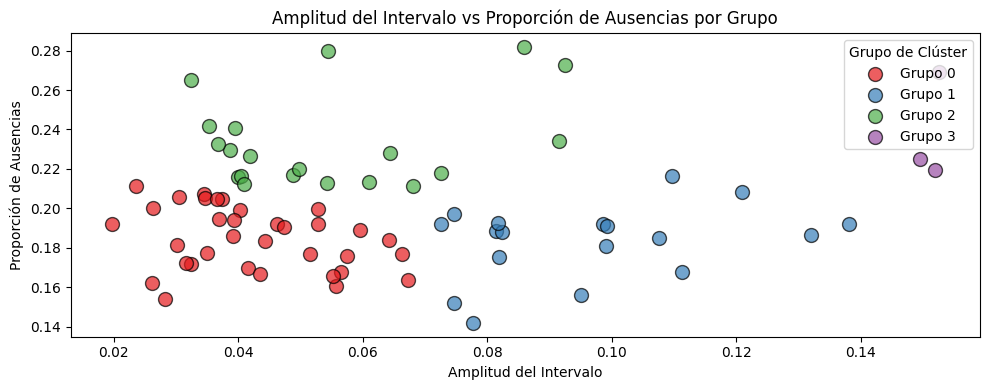

In [70]:
# Graficar la amplitud de intervalo vs. proporción de ausencias
plt.figure(figsize=(10, 4))

# Graficamos los puntos de amplitud de intervalo contra la proporción de ausencias
for i, group in enumerate(sorted_by_group['Grupo Clúster'].unique()):
    group_data = sorted_by_group[sorted_by_group['Grupo Clúster'] == group]
    
    # Calcular la amplitud del intervalo de confianza (IC Superior - IC Inferior)
    amplitude = group_data['IC Superior'] - group_data['IC Inferior']
    
    # Graficar los puntos (Amplitud de intervalo vs Proporción de ausencias)
    plt.scatter(amplitude, 
                group_data['Proporción de ausencias'], 
                color=palette[i],  # Asignamos un color por grupo
                label=f'Grupo {group}',  # Etiqueta por grupo
                s=100,  # Tamaño de los puntos
                edgecolors='black',  # Borde negro para los puntos
                alpha=0.7)  # Opacidad de los puntos

# Personalizar el gráfico
plt.title('Amplitud del Intervalo vs Proporción de Ausencias por Grupo')
plt.xlabel('Amplitud del Intervalo')
plt.ylabel('Proporción de Ausencias')
plt.legend(title='Grupo de Clúster')  # Leyenda para los grupos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [71]:
# Crear un diccionario donde la clave es el nombre del barrio (índice) y el valor es el grupo/clúster
cluster_dict = contingency_table['Grupo Clúster'].to_dict()

In [72]:
X_train_3_enco = X_train_rare_label.copy()
X_test_3_enco = X_test_rare_label.copy()

In [73]:
# Reemplazar los valores en la columna 'Neighbourhood' de X_train_3_enco usando el diccionario de clústeres
X_train_3_enco['Cluster'] = X_train_3_enco['Neighbourhood'].map(cluster_dict)
X_train_3_enco[['Neighbourhood', 'Cluster']].head()

Neighbourhood  Cluster
64200      GURIGICA        2
91954    MONTE BELO        0
11678      REDENÇÃO        0
84806    ANDORINHAS        2
2761    SANTO ANDRÉ        0

In [74]:
# Reemplazar los valores en la columna 'Neighbourhood' de X_train_3_enco usando el diccionario de clústeres
X_test_3_enco['Cluster'] = X_test_3_enco['Neighbourhood'].map(cluster_dict)
X_test_3_enco[['Neighbourhood', 'Cluster']].head()

Neighbourhood  Cluster
104581  JARDIM CAMBURI        0
106123      TABUAZEIRO        0
54961         DA PENHA        0
40500      JOANA D´ARC        0
80990    SÃO CRISTÓVÃO        0

Text(0, 0.5, 'Number of observations per bin')

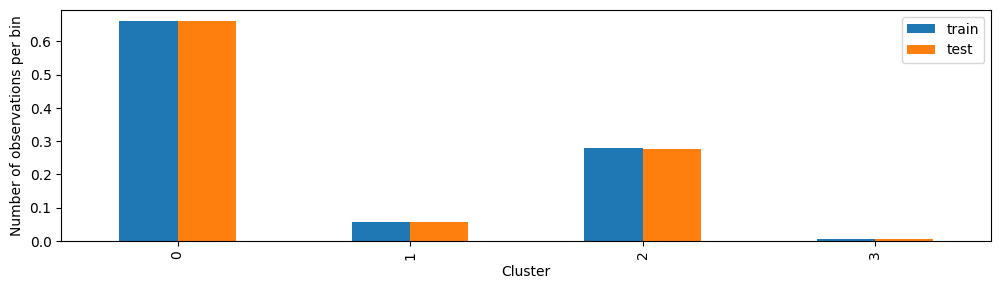

In [75]:
# let's explore how many observations we have per bin

t1 = X_train_3_enco.groupby(['Cluster'])['Cluster'].count() / len(X_train_3_enco)
t2 = X_test_3_enco.groupby(['Cluster'])['Cluster'].count() / len(X_test_3_enco)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=90)
plt.ylabel('Number of observations per bin')

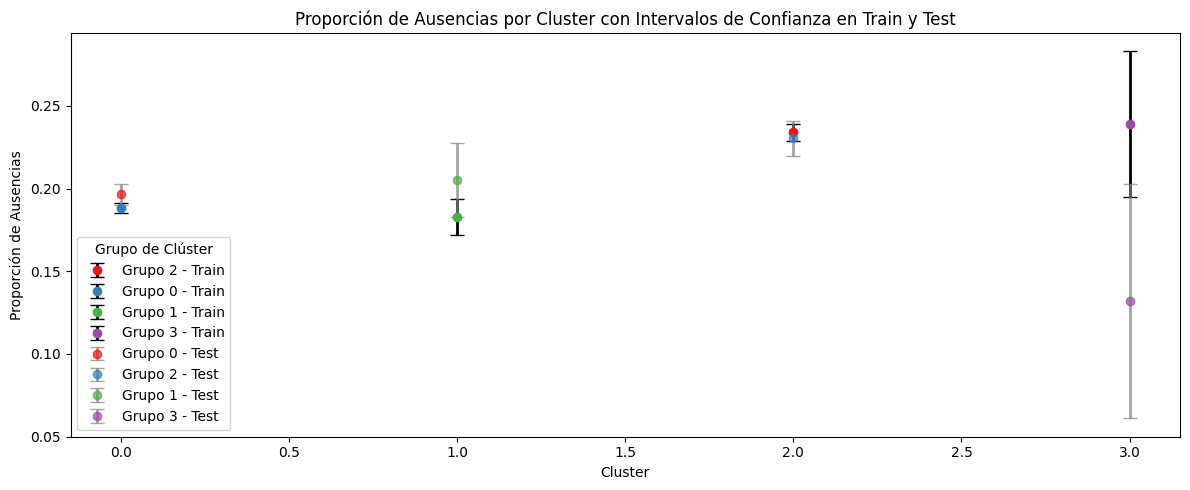

In [76]:
# Primero combinamos X_train_3_enco y y_train en un DataFrame para el conjunto de entrenamiento
train_set = X_train_3_enco[['Neighbourhood', 'Cluster']].copy()
train_set['Target'] = y_train

# Hacemos lo mismo para el conjunto de prueba
test_set = X_test_3_enco[['Neighbourhood', 'Cluster']].copy()
test_set['Target'] = y_test

# Función para calcular el intervalo de confianza para la media
def calcular_intervalo_confianza(data, confidence=0.95):
    """
    Calcula el intervalo de confianza para la media de una muestra.
    :param data: Lista o serie de datos para la que se calcula el intervalo de confianza.
    :param confidence: Nivel de confianza (por defecto 95%).
    :return: Intervalo de confianza (limite inferior, limite superior).
    """
    # Calcular la media y desviación estándar de la muestra
    media = np.mean(data)
    std = np.std(data, ddof=1)  # Desviación estándar muestral
    n = len(data)
    
    # Error estándar de la media (SEM)
    sem = std / np.sqrt(n)
    
    # Grados de libertad
    df = n - 1
    
    # Valor crítico t para el intervalo de confianza
    t_crit = stats.t.ppf((1 + confidence) / 2, df)
    
    # Calcular los límites del intervalo de confianza
    ic_inferior = media - t_crit * sem
    ic_superior = media + t_crit * sem
    
    return ic_inferior, ic_superior

# Crear una paleta de colores para los 5 grupos
palette = sns.color_palette("Set1", n_colors=5)

# Graficar los intervalos de confianza comparando los conjuntos de entrenamiento y prueba
plt.figure(figsize=(12, 5))

# Agrupar por 'Cluster' para el conjunto de entrenamiento
for i, group in enumerate(train_set['Cluster'].unique()):
    group_data_train = train_set[train_set['Cluster'] == group]['Target']  # Usamos la columna 'Target' como variable
    
    # Calcular la media de la proporción de ausencias para cada grupo de entrenamiento
    mean_proporcion_train = np.mean(group_data_train)
    
    # Calcular los intervalos de confianza para el conjunto de entrenamiento usando la función definida
    ic_inferior_train, ic_superior_train = calcular_intervalo_confianza(group_data_train)
    
    # Graficar los puntos (proporción de ausencias) y los intervalos de confianza para entrenamiento
    plt.errorbar([group],  
                 mean_proporcion_train, 
                 yerr=[[mean_proporcion_train - ic_inferior_train], [ic_superior_train - mean_proporcion_train]], 
                 fmt='o', 
                 color=palette[i],  # Asignamos un color por grupo
                 ecolor= 'black',  # Color de las barras de error igual al del punto
                 elinewidth=2, 
                 capsize=5, 
                 label=f'Grupo {group} - Train')  # Etiqueta por grupo de entrenamiento

# Agrupar por 'Cluster' para el conjunto de prueba
for i, group in enumerate(test_set['Cluster'].unique()):
    group_data_test = test_set[test_set['Cluster'] == group]['Target']  # Usamos la columna 'Target' como variable
    
    # Calcular la media de la proporción de ausencias para cada grupo de prueba
    mean_proporcion_test = np.mean(group_data_test)
    
    # Calcular los intervalos de confianza para el conjunto de prueba usando la función definida
    ic_inferior_test, ic_superior_test = calcular_intervalo_confianza(group_data_test)
    
    # Graficar los puntos (proporción de ausencias) y los intervalos de confianza para prueba
    plt.errorbar([group],  
                 mean_proporcion_test, 
                 yerr=[[mean_proporcion_test - ic_inferior_test], [ic_superior_test - mean_proporcion_test]], 
                 fmt='o', 
                 color=palette[i],  # Asignamos un color por grupo
                 ecolor= 'gray',  # Color de las barras de error igual al del punto
                 elinewidth=2, 
                 capsize=5, 
                 label=f'Grupo {group} - Test', # Etiqueta por grupo de prueba
                 alpha=0.7)  

# Personalizar el gráfico
plt.title('Proporción de Ausencias por Cluster con Intervalos de Confianza en Train y Test')
plt.xlabel('Cluster')
plt.ylabel('Proporción de Ausencias')
plt.xticks(rotation=0)  # No rotar los nombres de los clusters
plt.legend(title='Grupo de Clúster')  # Leyenda para los grupos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

##### Si bien para el test set la mayoria de las tasas de inasistencias promedio de cada grupo caen por fuera de los intervalos de confianza correspondientes consideramos que el comportamiento de los grupos es aceptable

In [77]:
class ClusterMapper(BaseEstimator, TransformerMixin):
    def __init__(self, cluster_dict):
        self.cluster_dict = cluster_dict  # Diccionario de clústeres

    def fit(self, X, y=None):
        # El método fit no hace nada en este caso porque solo necesitamos el diccionario
        return self

    def transform(self, X):
        # Reemplazar los nombres de barrios por el clúster correspondiente
        X_transformed = X.copy()  # Evitar modificar el dataframe original
        X_transformed['Cluster'] = X_transformed['Neighbourhood'].map(self.cluster_dict)
        return X_transformed

In [78]:
cluster_mapper = ClusterMapper(cluster_dict)

In [79]:
# Para el pipeline
# ('cluster_mapper', cluster_mapper),

In [80]:
drop_feature_Neighbourhood = DropFeatures(features_to_drop=['Neighbourhood'])
X_train_3_enco = drop_feature_Neighbourhood.fit_transform(X_train_3_enco)
X_test_3_enco = drop_feature_Neighbourhood.transform(X_test_3_enco)

In [81]:
# Para el pipeline
# ('drop_feature_Neighbourhood', drop_feature_Neighbourhood),

In [82]:
X_train_3_enco.head(3)

PatientId Gender          ScheduledDay        AppointmentDay  Age  \
64200  5.386962e+14      M  2016-05-11T07:24:56Z  2016-05-11T00:00:00Z   36   
91954  1.923469e+12      F  2016-06-02T08:02:40Z  2016-06-02T00:00:00Z   59   
11678  7.323343e+12      F  2016-05-16T08:35:36Z  2016-05-16T00:00:00Z   32   

       Scholarship  Hipertension  Diabetes  Alcoholism  Handcap  SMS_received  \
64200            0             0         0           0        0             0   
91954            0             0         0           0        0             0   
11678            0             0         0           0        0             0   

       Cluster  
64200        2  
91954        0  
11678        0

In [83]:
y_train.head(3)

64200    0
91954    0
11678    0
Name: No-show, dtype: int32

### - **ScheduledDay**: Fecha y hora en que se programó la cita.
### - **AppointmentDay**: Fecha de la cita.

#### Convertir 'AppointmentDay' y 'ScheduledDay' a un dato tipo fecha

In [84]:
def convert_to_datetime(X, column_names):
    for column in column_names:
        if column in X.columns:  # Verificar si la columna existe
            X[column] = pd.to_datetime(X[column])
        else:
            print(f"Columna {column} no encontrada en el DataFrame.")
    return X

In [85]:
# Convertir AppointmentDay a datetime
X_train_to_date = convert_to_datetime(X_train_3_enco, ['AppointmentDay', 'ScheduledDay'])
X_test_to_date = convert_to_datetime(X_test_3_enco, ['AppointmentDay', 'ScheduledDay'])

In [86]:
# Para el pipeline
def convert_datetime_columns(X):
    return convert_to_datetime(X, ['AppointmentDay', 'ScheduledDay'])

# Transformador actualizado
datetime_transformer = FunctionTransformer(convert_datetime_columns, validate=False)

In [87]:
X_train_to_date[['AppointmentDay', 'ScheduledDay']].dtypes

AppointmentDay    datetime64[ns, UTC]
ScheduledDay      datetime64[ns, UTC]
dtype: object

In [88]:
X_train_to_date.head(4)

PatientId Gender              ScheduledDay  \
64200  5.386962e+14      M 2016-05-11 07:24:56+00:00   
91954  1.923469e+12      F 2016-06-02 08:02:40+00:00   
11678  7.323343e+12      F 2016-05-16 08:35:36+00:00   
84806  6.183352e+12      F 2016-05-24 12:41:00+00:00   

                 AppointmentDay  Age  Scholarship  Hipertension  Diabetes  \
64200 2016-05-11 00:00:00+00:00   36            0             0         0   
91954 2016-06-02 00:00:00+00:00   59            0             0         0   
11678 2016-05-16 00:00:00+00:00   32            0             0         0   
84806 2016-06-07 00:00:00+00:00   62            0             0         0   

       Alcoholism  Handcap  SMS_received  Cluster  
64200           0        0             0        2  
91954           0        0             0        0  
11678           0        0             0        0  
84806           0        0             1        2

#### A partir de 'AppointmentDay' y 'ScheduledDay' se crean diferentes cacteristicas para su analisis

In [89]:
X_train_to_date2 = X_train_to_date.copy()
X_test_to_date2 = X_test_to_date.copy()

In [90]:
X_train_to_date2['Hour'] = X_train_to_date2['AppointmentDay'].dt.hour
X_train_to_date2['DayOfWeek'] = X_train_to_date2['AppointmentDay'].dt.day_name()
X_train_to_date2['DayOfMonth'] = X_train_to_date2['AppointmentDay'].dt.day
X_train_to_date2['Month'] = X_train_to_date2['AppointmentDay'].dt.month
X_train_to_date2['WaitingTime'] = (X_train_to_date2['AppointmentDay'] - X_train_to_date2['ScheduledDay']).dt.days

X_test_to_date2['Hour'] = X_test_to_date2['AppointmentDay'].dt.hour
X_test_to_date2['DayOfWeek'] = X_test_to_date2['AppointmentDay'].dt.day_name()
X_test_to_date2['DayOfMonth'] = X_test_to_date2['AppointmentDay'].dt.day
X_test_to_date2['Month'] = X_test_to_date2['AppointmentDay'].dt.month
X_test_to_date2['WaitingTime'] = (X_test_to_date2['AppointmentDay'] - X_test_to_date2['ScheduledDay']).dt.days

#### Como se saca turno para un día pero no para una hora en particular, esta caracteristica no agregar una caracteristica con la hora del turno no agrega valor

<Axes: >

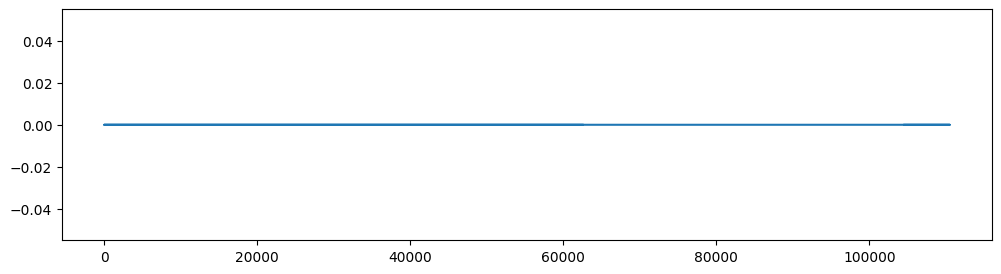

In [91]:
X_test_to_date2['Hour'].plot(kind='line')

In [92]:
train_set = pd.concat([X_train_to_date2, y_train], axis = 1)

In [93]:
train_set.head(2)

PatientId Gender              ScheduledDay  \
64200  5.386962e+14      M 2016-05-11 07:24:56+00:00   
91954  1.923469e+12      F 2016-06-02 08:02:40+00:00   

                 AppointmentDay  Age  Scholarship  Hipertension  Diabetes  \
64200 2016-05-11 00:00:00+00:00   36            0             0         0   
91954 2016-06-02 00:00:00+00:00   59            0             0         0   

       Alcoholism  Handcap  SMS_received  Cluster  Hour  DayOfWeek  \
64200           0        0             0        2     0  Wednesday   
91954           0        0             0        0     0   Thursday   

       DayOfMonth  Month  WaitingTime  No-show  
64200          11      5           -1        0  
91954           2      6           -1        0

#### Verifico si el día de la consulta programada puede agregar o no poder predictivo

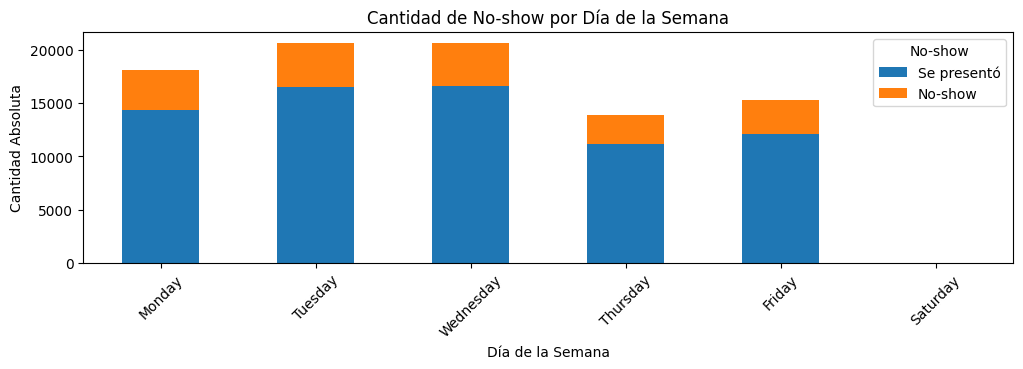

In [94]:
# Definir el orden de los días de la semana
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Convertir 'DayOfWeek' a tipo categórico con el orden especificado
train_set['DayOfWeek'] = pd.Categorical(train_set['DayOfWeek'], categories=day_order, ordered=True)

# Creamos la tabla de contingencia
contingency_table = pd.crosstab(train_set['DayOfWeek'], train_set['No-show'])

# Graficamos la tabla de contingencia
contingency_table.plot(kind='bar', stacked=True)
plt.title('Cantidad de No-show por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Cantidad Absoluta')
plt.xticks(rotation=45)
plt.legend(title='No-show', labels=['Se presentó', 'No-show'])
plt.show()

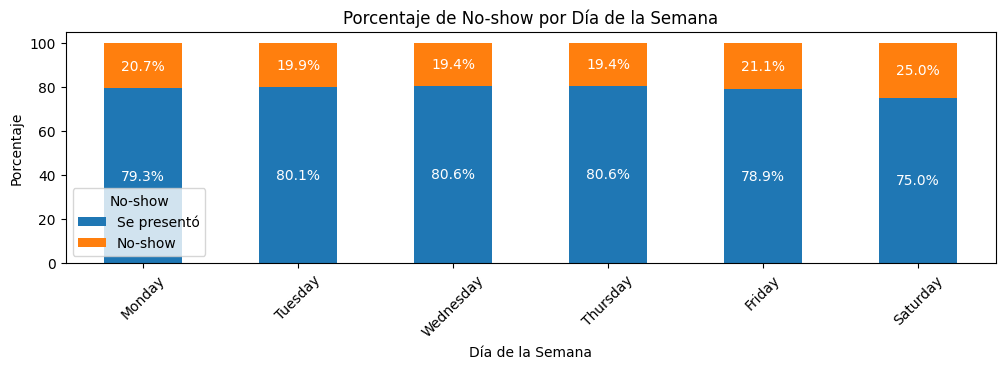

In [95]:
# Calculamos los porcentajes
contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Graficamos
ax = contingency_table_percentage.plot(kind='bar', stacked=True)
plt.title('Porcentaje de No-show por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Porcentaje')
plt.xticks(rotation=45)
plt.legend(title='No-show', labels=['Se presentó', 'No-show'])

# Agregar porcentajes en las barras, centrados
for p in ax.patches:
    height = p.get_height()  # Altura de la barra
    width = p.get_width()  # Ancho de la barra
    x = p.get_x() + width / 2  # Posición x centrada
    y = p.get_y() + height / 2  # Posición y en el centro de la barra
    # Agregar el texto del porcentaje
    ax.annotate(f'{height:.1f}%', (x, y), ha='center', va='center', color='white')

plt.show()

##### Si bien, hay días de la semana que tienen mayor o menor cantidad de turnos, el porcentaje de inasistencia no pareciera verse afectado por el día.

In [96]:
contingency_table_percentage

No-show            0          1
DayOfWeek                      
Monday     79.299839  20.700161
Tuesday    80.062169  19.937831
Wednesday  80.607148  19.392852
Thursday   80.556157  19.443843
Friday     78.916372  21.083628
Saturday   75.000000  25.000000

In [97]:
contingency_table 

No-show        0     1
DayOfWeek             
Monday     14316  3737
Tuesday    16484  4105
Wednesday  16622  3999
Thursday   11153  2692
Friday     12060  3222
Saturday      24     8

In [98]:
# Realizar la prueba de Chi-cuadrado
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Imprimir los resultados
print(f"Chi2 Stat: {chi2_stat}")
print(f"P-Value: {p_value}")
print(f"Degrees of Freedom: {dof}")

Chi2 Stat: 24.206739515024985
P-Value: 0.0001981242570947394
Degrees of Freedom: 5


##### Como P-Value es menor que 0.05 hay evidencia suficiente para afirmar que las proporciones de inasistencia no son iguales entre los días de la semana.

In [99]:
# Filtrar para omitir el sábado
filtered_data = train_set[train_set['DayOfWeek'] != 'Saturday']

# Crear la tabla de contingencia
contingency_table = pd.crosstab(filtered_data['DayOfWeek'], filtered_data['No-show'])

# Realizar la prueba de Chi-cuadrado
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Imprimir los resultados
print(f"Chi2 Stat: {chi2_stat}")
print(f"P-Value: {p_value}")
print(f"Degrees of Freedom: {dof}")

Chi2 Stat: 23.727358209332916
P-Value: 9.058052374172253e-05
Degrees of Freedom: 4


##### Tampoco podemos afirmar que las proporciones de ausencias son igual entre los dias de semana

#### El dia de la semana puede tener poder predictivo

In [100]:
mean_enc_week_day = MeanEncoder(variables=["DayOfWeek"])
mean_enc_week_day.fit(X_train_to_date2, y_train)

MeanEncoder(variables=['DayOfWeek'])

In [101]:
X_train_to_date3 = mean_enc_week_day.transform(X_train_to_date2)
X_test_to_date3 = mean_enc_week_day.transform(X_test_to_date2)

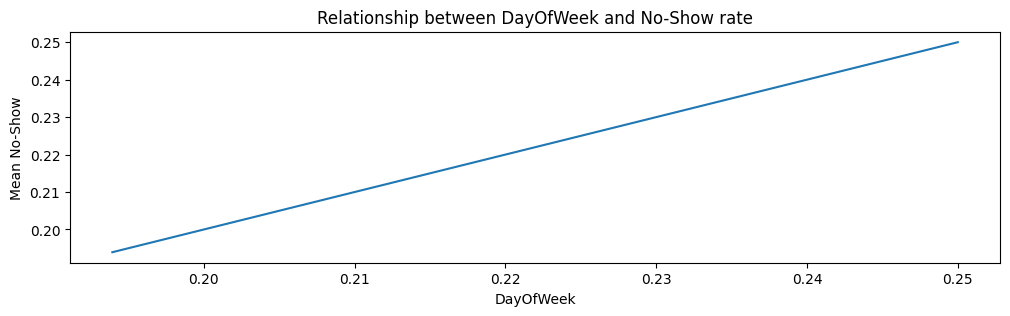

In [102]:
fig = plt.figure()
fig = y_train.groupby(X_train_to_date3["DayOfWeek"]).mean().plot()
fig.set_title("Relationship between {} and No-Show rate".format("DayOfWeek"))
fig.set_ylabel("Mean No-Show")
plt.show()

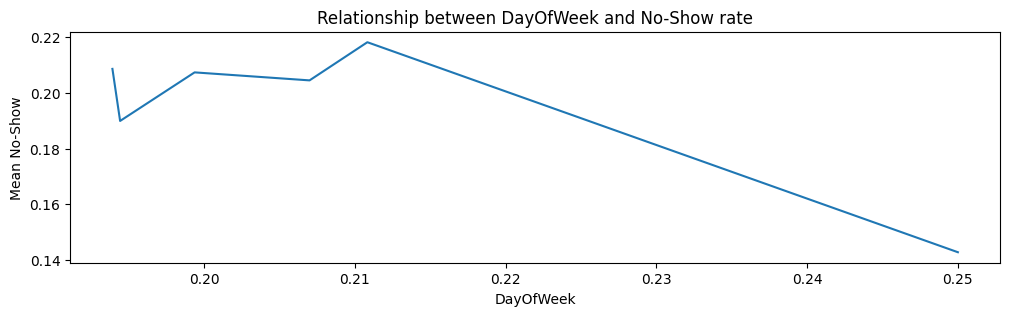

In [103]:
fig = plt.figure()
fig = y_test.groupby(X_test_to_date3["DayOfWeek"]).mean().plot()
fig.set_title("Relationship between {} and No-Show rate".format("DayOfWeek"))
fig.set_ylabel("Mean No-Show")
plt.show()

#### El comportamineto de los pacientes en el conjunto de datos de prueba no tienen el comportamiento esperado.
#### Hay que analizar si mantener esta caracteristica ayuda a predecir o solo genera ruido

### Verifico si el día del mes en al cual se agendo la consulta puede agregar valor o no

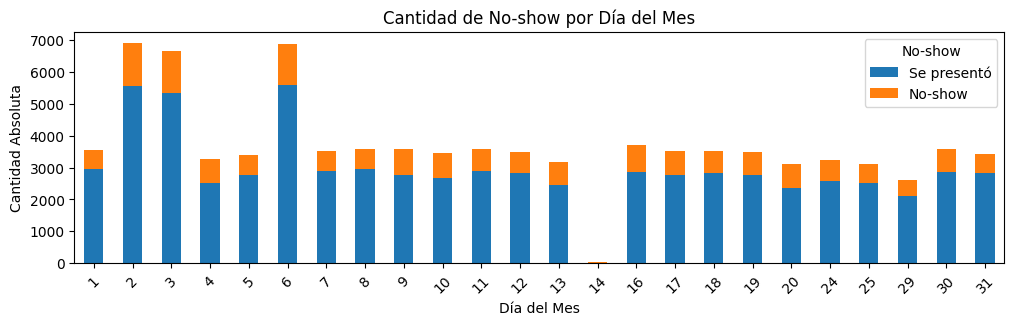

In [104]:
# Creamos la tabla de contingencia
contingency_table = pd.crosstab(train_set['DayOfMonth'], train_set['No-show'])

# Graficamos la tabla de contingencia
contingency_table.plot(kind='bar', stacked=True)
plt.title('Cantidad de No-show por Día del Mes')
plt.xlabel('Día del Mes')
plt.ylabel('Cantidad Absoluta')
plt.xticks(rotation=45)
plt.legend(title='No-show', labels=['Se presentó', 'No-show'])
plt.show()

##### Puede ser que el dia del mes tenga poder predictivo, por algun motivo el 2,3 y 6 de cada mes es cuando más turnos hay, y los días 14 casi no hay turnos

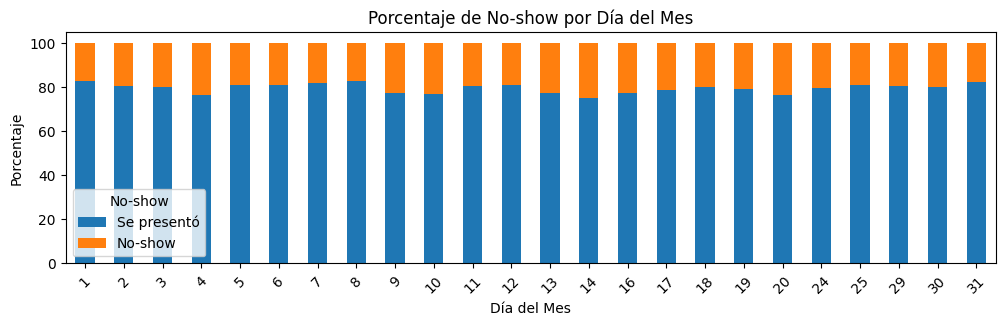

In [105]:
# Calculamos los porcentajes
contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Graficamos
contingency_table_percentage.plot(kind='bar', stacked=True)
plt.title('Porcentaje de No-show por Día del Mes')
plt.xlabel('Día del Mes')
plt.ylabel('Porcentaje')
plt.xticks(rotation=45)
plt.legend(title='No-show', labels=['Se presentó', 'No-show'])
plt.show()

#### Analizo las inasistencias por mes (solo hay datos de abril, mayo y junio)

In [106]:
X_test_to_date2['Month'].unique()

array([6, 5, 4])

In [107]:
X_train_to_date2['Month'].unique()

array([5, 6, 4])

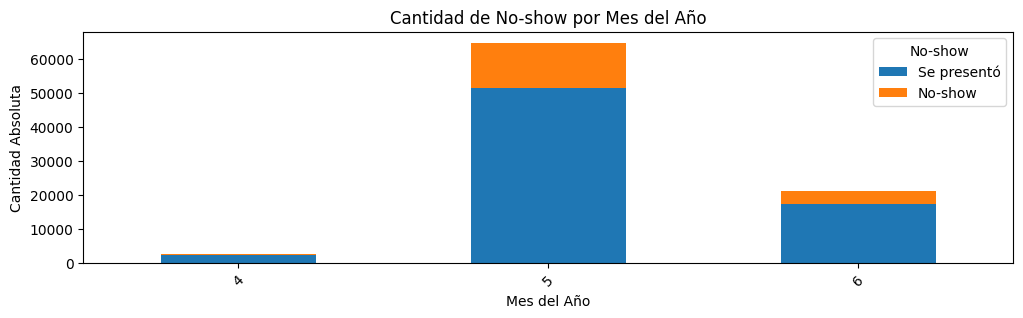

In [108]:
contingency_table = pd.crosstab(train_set['Month'], train_set['No-show'])

# Graficamos la tabla de contingencia
contingency_table.plot(kind='bar', stacked=True)
plt.title('Cantidad de No-show por Mes del Año')
plt.xlabel('Mes del Año')
plt.ylabel('Cantidad Absoluta')
plt.xticks(rotation=45)
plt.legend(title='No-show', labels=['Se presentó', 'No-show'])
plt.show()

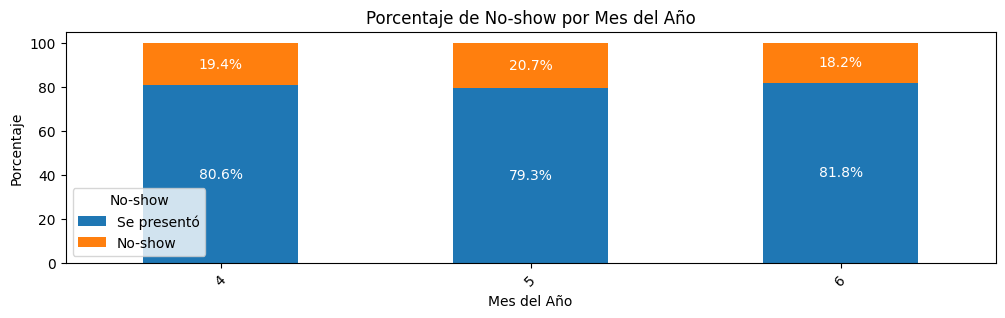

In [109]:
# Calculamos los porcentajes
contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Graficamos
ax = contingency_table_percentage.plot(kind='bar', stacked=True)
plt.title('Porcentaje de No-show por Mes del Año')
plt.xlabel('Mes del Año')
plt.ylabel('Porcentaje')
plt.xticks(rotation=45)
plt.legend(title='No-show', labels=['Se presentó', 'No-show'])

# Agregar porcentajes en las barras, centrados
for p in ax.patches:
    height = p.get_height()  # Altura de la barra
    width = p.get_width()  # Ancho de la barra
    x = p.get_x() + width / 2  # Posición x centrada
    y = p.get_y() + height / 2  # Posición y en el centro de la barra
    # Agregar el texto del porcentaje
    ax.annotate(f'{height:.1f}%', (x, y), ha='center', va='center', color='white')

plt.show()

In [110]:
contingency_table_percentage

No-show          0          1
Month                        
4        80.600462  19.399538
5        79.261377  20.738623
6        81.818182  18.181818

# Realizar la prueba de Chi-cuadrado
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Imprimir los resultados
print(f"Chi2 Stat: {chi2_stat}")
print(f"P-Value: {p_value}")
print(f"Degrees of Freedom: {dof}")

#### Dado que solo se cuenta con informacion de tres meses, siendo uno de estos tres con lo que mayor cantidad de datos se cuenta no tiene sentido incluir ni el mes ni el día del mes dentro del estudio.

### Analizo los días de espera entre la solicitud del turno y la fecha programada

In [111]:
X_train_to_date2['WaitingTime'].head(10)

64200    -1
91954    -1
11678    -1
84806    13
2761     -1
84073    38
31024     6
69569     5
39366    -1
97116    20
Name: WaitingTime, dtype: int64

In [112]:
X_train_to_date2.loc[64200, ['ScheduledDay', 'AppointmentDay', 'WaitingTime']]

ScheduledDay      2016-05-11 07:24:56+00:00
AppointmentDay    2016-05-11 00:00:00+00:00
WaitingTime                              -1
Name: 64200, dtype: object

In [113]:
X_train_to_date2.loc[69569, ['ScheduledDay', 'AppointmentDay', 'WaitingTime']]

ScheduledDay      2016-05-03 14:04:39+00:00
AppointmentDay    2016-05-09 00:00:00+00:00
WaitingTime                               5
Name: 69569, dtype: object

#### Para que WaitingTime tome que tengan sentido se le suma una unidad

In [114]:
X_train_to_date2['WaitingTime'] = X_train_to_date2['WaitingTime'] + 1
X_test_to_date2['WaitingTime'] = X_test_to_date2['WaitingTime'] + 1

In [115]:
train_set['WaitingTime'] += 1

In [116]:
train_set.loc[64200, ['ScheduledDay', 'AppointmentDay', 'WaitingTime']]

ScheduledDay      2016-05-11 07:24:56+00:00
AppointmentDay    2016-05-11 00:00:00+00:00
WaitingTime                               0
Name: 64200, dtype: object

<Axes: xlabel='WaitingTime', ylabel='Count'>

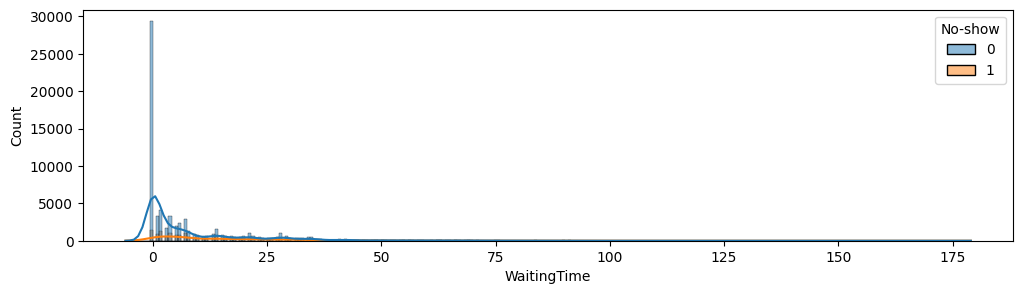

In [117]:
sns.histplot(data = train_set, x = 'WaitingTime', stat="count", kde=True, hue='No-show')

In [118]:
train_set['WaitingTime'].describe()

count    88422.000000
mean        10.164292
std         15.262045
min         -6.000000
25%          0.000000
50%          4.000000
75%         15.000000
max        179.000000
Name: WaitingTime, dtype: float64

<Axes: xlabel='WaitingTime', ylabel='Count'>

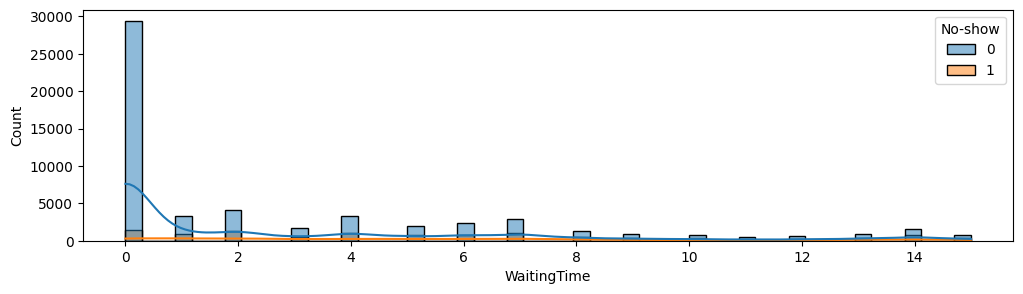

In [119]:
filtered_train_set = train_set[(train_set['WaitingTime'] <= 15) & (train_set['WaitingTime'] >= 0)]
sns.histplot(data = filtered_train_set, x = 'WaitingTime', stat="count", kde=True, hue='No-show')

<Axes: xlabel='WaitingTime', ylabel='Count'>

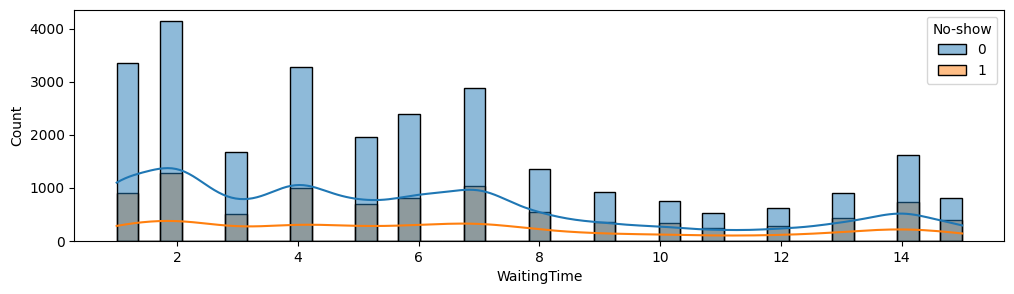

In [120]:
filtered_train_set = train_set[(train_set['WaitingTime'] <= 15) & (train_set['WaitingTime'] >= 1)]
sns.histplot(data = filtered_train_set, x = 'WaitingTime', stat="count", kde=True, hue='No-show')

In [121]:
# Agrupar por 'WaitingTime' y contar los valores de 'No-show'
summary = train_set.groupby('WaitingTime')['No-show'].value_counts().unstack(fill_value=0)
# Calcular el porcentaje de No-show
summary['Total'] = summary.sum(axis=1)
summary['No-show %'] = (summary[1] / summary['Total']) * 100  # Cambia 'Yes' por el valor que corresponda

# Opcional: Seleccionar solo las columnas relevantes
summary = summary[['Total', 'No-show %']]

In [122]:
summary.head(50)

No-show      Total   No-show %
WaitingTime                   
-6               1  100.000000
-1               3  100.000000
 0           30826    4.548109
 1            4250   20.988235
 2            5423   23.474092
 3            2177   23.426734
 4            4266   23.183310
 5            2649   26.387316
 6            3198   25.328330
 7            3921   26.472839
 8            1886   28.525981
 9            1284   27.881620
 10           1075   31.162791
 11            776   31.958763
 12            892   31.838565
 13           1328   31.777108
 14           2340   31.282051
 15           1198   33.305509
 16            928   29.418103
 17            872   31.307339
 18            793   30.138714
 19            828   34.299517
 20            948   34.282700
 21           1489   31.229013
 22            942   34.394904
 23            659   33.535660
 24            487   37.166324
 25            514   39.883268
 26            575   35.826087
 27            783   30.651341
 28           1376   28.924419
 29            868   32.142857
 30            563   26.465364
 31            530   32.830189
 32            460   34.130435
 33            529   32.703214
 34            663   34.087481
 35            765   36.862745
 36            436   32.339450
 37            259   36.293436
 38            165   34.545455
 39            139   33.812950
 40            200   38.000000
 41            274   35.766423
 42            341   37.243402
 43            201   31.343284
 44            125   32.800000
 45            116   36.206897
 46            102   37.254902
 47             88   32.954545

In [123]:
summary.tail(50)

No-show      Total   No-show %
WaitingTime                   
76              53   32.075472
77              41   29.268293
78              26   34.615385
79              17   35.294118
80              17   47.058824
81               8   37.500000
83               7   14.285714
84              45   24.444444
85              28   21.428571
86               6   16.666667
87              13   38.461538
88              10   40.000000
89              14   50.000000
90              46   26.086957
91              47   23.404255
92               3    0.000000
93               2    0.000000
94               1    0.000000
95               4   25.000000
96               3   33.333333
97               2    0.000000
98               5   20.000000
101              1    0.000000
102              4   25.000000
103              4   75.000000
104              5   80.000000
105              3    0.000000
107              1    0.000000
108              5    0.000000
109              4    0.000000
110              2   50.000000
111              5   20.000000
112              4    0.000000
115              2    0.000000
117              1    0.000000
119              4    0.000000
122              1    0.000000
123              1    0.000000
125              1    0.000000
126              1  100.000000
127              1    0.000000
132              1  100.000000
133              9   44.444444
142              5   20.000000
146              1  100.000000
155              9   66.666667
162             10   20.000000
169              8   12.500000
176             15   40.000000
179              5   20.000000

#### Analiso los casos en los que WaitingTime es negativo

In [124]:
filtered_train_set = train_set[train_set['WaitingTime'] < 0]
filtered_train_set

PatientId Gender              ScheduledDay  \
72362  3.787482e+12      M 2016-05-04 06:50:57+00:00   
55226  7.896294e+12      F 2016-05-18 14:50:41+00:00   
64175  2.425226e+13      F 2016-05-05 13:43:58+00:00   
71533  9.982316e+14      F 2016-05-11 13:49:20+00:00   

                 AppointmentDay  Age  Scholarship  Hipertension  Diabetes  \
72362 2016-05-03 00:00:00+00:00    7            0             0         0   
55226 2016-05-17 00:00:00+00:00   19            0             0         0   
64175 2016-05-04 00:00:00+00:00   22            0             0         0   
71533 2016-05-05 00:00:00+00:00   81            0             0         0   

       Alcoholism  Handcap  SMS_received  Cluster  Hour  DayOfWeek  \
72362           0        0             0        0     0    Tuesday   
55226           0        1             0        0     0    Tuesday   
64175           0        0             0        0     0  Wednesday   
71533           0        0             0        0     0   Thursday   

       DayOfMonth  Month  WaitingTime  No-show  
72362           3      5           -1        1  
55226          17      5           -1        1  
64175           4      5           -1        1  
71533           5      5           -6        1

#### Dada que son muy pocos los registros donde la fecha de la consulta es antes que la fecha en la que se genero la orden de consulta, estos registros se eliminan del dataset
Asegurarse que la fecha de programación de la cita (`ScheduledDay`) sea anterior o igual a la fecha de la cita (`AppointmentDay`). Si no es así, esos registros se eliminan.

### Analizo si el momento del día en el que se realizó la reserva tiene poder predictivo

In [125]:
train_set['ScheduledHour'] = train_set['ScheduledDay'].dt.hour

In [126]:
# 4. Periodo del día en que se programó la cita (Mañana, Tarde, Noche)
def get_period_of_day(hour):
    if 5 <= hour < 12:
        return 'Mañana'
    elif 12 <= hour < 18:
        return 'Tarde'
    else:
        return 'Noche'


train_set['ScheduledPeriod'] = train_set['ScheduledHour'].apply(get_period_of_day)

# Visualizar las primeras filas del dataset con las nuevas características
train_set[['ScheduledDay', 'AppointmentDay', 'WaitingTime', 'DayOfWeek', 'ScheduledHour', 'ScheduledPeriod']].head()

ScheduledDay            AppointmentDay  WaitingTime  \
64200 2016-05-11 07:24:56+00:00 2016-05-11 00:00:00+00:00            0   
91954 2016-06-02 08:02:40+00:00 2016-06-02 00:00:00+00:00            0   
11678 2016-05-16 08:35:36+00:00 2016-05-16 00:00:00+00:00            0   
84806 2016-05-24 12:41:00+00:00 2016-06-07 00:00:00+00:00           14   
2761  2016-04-29 08:01:51+00:00 2016-04-29 00:00:00+00:00            0   

       DayOfWeek  ScheduledHour ScheduledPeriod  
64200  Wednesday              7          Mañana  
91954   Thursday              8          Mañana  
11678     Monday              8          Mañana  
84806    Tuesday             12           Tarde  
2761      Friday              8          Mañana

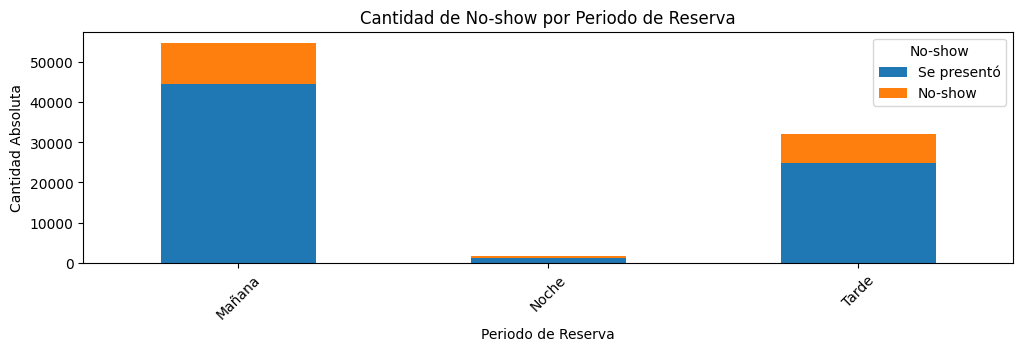

In [127]:
contingency_table = pd.crosstab(train_set['ScheduledPeriod'], train_set['No-show'])

# Graficamos la tabla de contingencia
contingency_table.plot(kind='bar', stacked=True)
plt.title('Cantidad de No-show por Periodo de Reserva')
plt.xlabel('Periodo de Reserva')
plt.ylabel('Cantidad Absoluta')
plt.xticks(rotation=45)
plt.legend(title='No-show', labels=['Se presentó', 'No-show'])
plt.show()

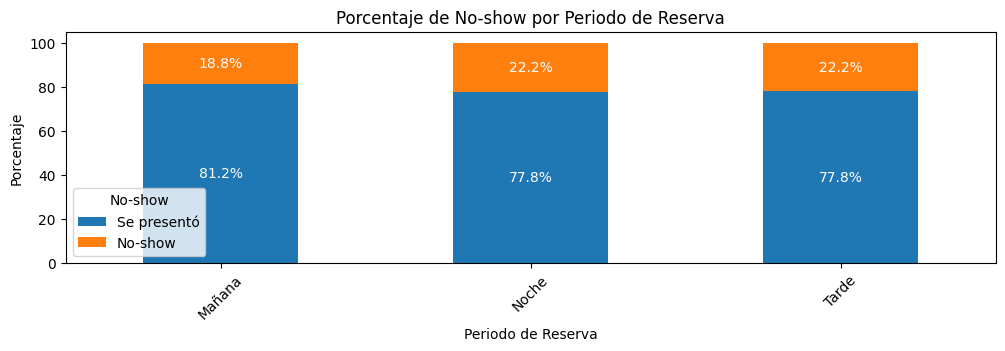

In [128]:
# Calculamos los porcentajes
contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Graficamos
ax = contingency_table_percentage.plot(kind='bar', stacked=True)
plt.title('Porcentaje de No-show por Periodo de Reserva')
plt.xlabel('Periodo de Reserva')
plt.ylabel('Porcentaje')
plt.xticks(rotation=45)
plt.legend(title='No-show', labels=['Se presentó', 'No-show'])

# Agregar porcentajes en las barras, centrados
for p in ax.patches:
    height = p.get_height()  # Altura de la barra
    width = p.get_width()  # Ancho de la barra
    x = p.get_x() + width / 2  # Posición x centrada
    y = p.get_y() + height / 2  # Posición y en el centro de la barra
    # Agregar el texto del porcentaje
    ax.annotate(f'{height:.1f}%', (x, y), ha='center', va='center', color='white')

plt.show()

##### El periodo del día en el que se realizó la reserva podría tener algo de poder predictivo

### Modificar, crear, eliminar las caracteristicas relacionadas con el tiempo ya analizadas 

In [129]:
# Día de la semana
# Periodo en el cual se hizo la reserva
# Agrupar por días de espera [0, 1, 2 a 4, 5 a 7, 8 a 15, 16 a 31, más de 31 días]
# Ni hora, ni día del mes ni mes del año

In [130]:
X_train_time_eng = X_train_to_date.copy()
X_test_time_eng = X_test_to_date.copy()

In [131]:
X_train_time_eng['WaitingTime'] = (X_train_time_eng['AppointmentDay'] - X_train_time_eng['ScheduledDay']).dt.days + 1
X_test_time_eng['WaitingTime'] = (X_test_time_eng['AppointmentDay'] - X_test_time_eng['ScheduledDay']).dt.days + 1

In [132]:
X_train_time_eng = X_train_time_eng[X_train_time_eng['WaitingTime'] >= 0]
X_test_time_eng = X_test_time_eng[X_test_time_eng['WaitingTime'] >= 0]

In [133]:
# Filtrar las etiquetas y_train y y_test con el mismo índice de las filas seleccionadas en X
y_train = y_train[X_train_time_eng.index]
y_test = y_test[X_test_time_eng.index]

In [134]:
# Crear un transformador para calcular 'WaitingTime'
def calculate_waiting_time(df):
    df['WaitingTime'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days + 1
    return df

In [135]:
waiting_time_transformer = FunctionTransformer(calculate_waiting_time, validate=False)

In [136]:
X_train_time_eng["WaitingTime"].min()

0

In [137]:
# Para el pipeline
# ('calculate_waiting_time', waiting_time_transformer)
# ('filter_dates', FunctionTransformer(lambda df: df[df['WaitingTime'] >= 0], validate=False)

In [138]:
X_train_time_eng['DayOfWeek'] = X_train_time_eng['AppointmentDay'].dt.day_name()
X_test_time_eng['DayOfWeek'] = X_test_time_eng['AppointmentDay'].dt.day_name()

In [139]:
# Crear un transformador para calcular 'DayOfWeek'
def calculate_day_of_week(df):
    df['DayOfWeek'] = df['AppointmentDay'].dt.day_name()
    return df

In [140]:
day_of_week_transformer = FunctionTransformer(calculate_day_of_week, validate=False)

In [141]:
# Para el pipeline
# ('calculate_day_of_week', day_of_week_transformer)

In [142]:
X_train_time_eng['Hour'] = X_train_time_eng['ScheduledDay'].dt.hour
X_test_time_eng['Hour'] = X_test_time_eng['ScheduledDay'].dt.hour

In [143]:
def extract_hour(df):
    df['Hour'] = df['ScheduledDay'].dt.hour
    return df

In [144]:
hour_transformer = FunctionTransformer(extract_hour, validate=False)

In [145]:
# Para el pipeline
# ('extract_hour', hour_transformer),

In [146]:
# Crear una función que aplique get_period_of_day a la columna 'Hour'
def assign_period_of_day(df):
    df['ScheduledPeriod'] = df['Hour'].apply(get_period_of_day)  # Asegúrate de tener la columna 'Hour'
    return df

In [147]:
period_of_day_transformer = FunctionTransformer(assign_period_of_day, validate=False)

In [148]:
X_train_time_eng = assign_period_of_day(X_train_time_eng)
X_test_time_eng = assign_period_of_day(X_test_time_eng)

In [149]:
X_train_time_eng['ScheduledPeriod']

64200    Mañana
91954    Mañana
11678    Mañana
84806     Tarde
2761     Mañana
          ...  
1209      Tarde
47022    Mañana
62239     Tarde
21055    Mañana
11185    Mañana
Name: ScheduledPeriod, Length: 88418, dtype: object

In [150]:
# Para el pipeline
# ('assign_period_of_day', period_of_day_transformer)

In [151]:
# Elimino la caracteristica Hour
drop_feature_hour = DropFeatures(features_to_drop=['Hour'])
X_train_time_eng = drop_feature_hour.fit_transform(X_train_time_eng)
X_test_time_eng = drop_feature_hour.transform(X_test_time_eng)

In [152]:
# Para el pipeline
# ('drop_feature_hour', drop_feature_hour),

In [153]:
# Agrupar por días de espera [0, 1, 2 a 4, 5 a 7, 8 a 15, 16 a 31, más de 31 días]
# Diccionario de agrupamiento
WaitingTime_binning_dict = {
    "WaitingTime": [-0.001, 0, 1, 4, 7, 15, 31, 50, np.inf]  # Agrupaciones para WaitingTime
}

# Crear el objeto discretiser
WaitingTime_Discretiser = ArbitraryDiscretiser(binning_dict = WaitingTime_binning_dict, return_boundaries=True)

In [154]:
X_train_ = X_train_time_eng.copy()
X_test_ = X_test_time_eng.copy()

In [155]:
X_train_time_eng["WaitingTime"].min()

0

In [156]:
X_train_["WaitingTime"].min()

0

In [157]:
# Aplicamos el discretizador al DataFrame
X_train_ = WaitingTime_Discretiser.fit_transform(X_train_)
X_test_ = WaitingTime_Discretiser.transform(X_test_)

In [158]:
X_train_["WaitingTime"].min()

'(-0.002, 0.0]'

In [159]:
# Para el pipeline
#  ('WaitingTime_Discretiser', WaitingTime_Discretiser),

In [160]:
X_train_['WaitingTime'].unique()

array(['(-0.002, 0.0]', '(7.0, 15.0]', '(31.0, 50.0]', '(4.0, 7.0]',
       '(15.0, 31.0]', '(0.0, 1.0]', '(1.0, 4.0]', '(50.0, inf]'],
      dtype=object)

In [161]:
# Verifico que los indicen sean los mismos y esten en el mismo orden
all(X_train_.index == y_train.index)

True

In [162]:
all(X_test_.index == y_test.index)

True

### - **Age**: Edad del paciente.

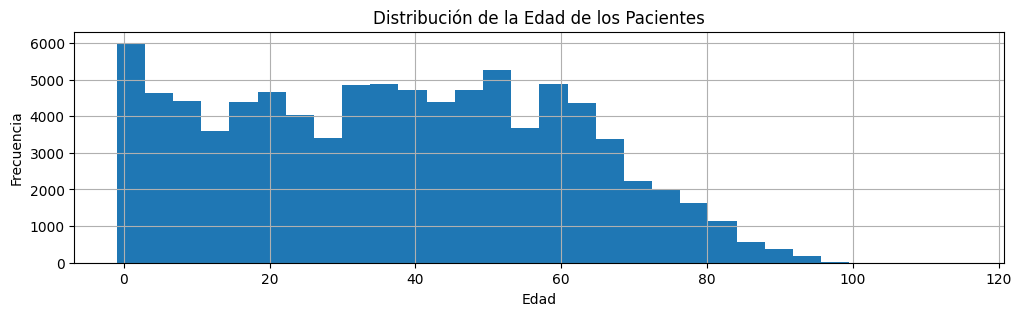

In [163]:
# Histograma de las edades
X_train_['Age'].hist(bins=30)
plt.title('Distribución de la Edad de los Pacientes')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

In [164]:
# Revisar valores inusuales en la columna 'Age'
print(f"Valores mínimos y máximos en la columna 'Age': { X_train_['Age'].min()}, {X_train_['Age'].max()}")

Valores mínimos y máximos en la columna 'Age': -1, 115


In [165]:
# Identificación de outliers utilizando boxplots
def plot_outliers(df, columns):
    for column in columns:
        plt.figure(figsize=(10, 2))
        sns.boxplot(x=df[column])
        plt.title(f'Detección de Outliers - {column}')
        plt.show()

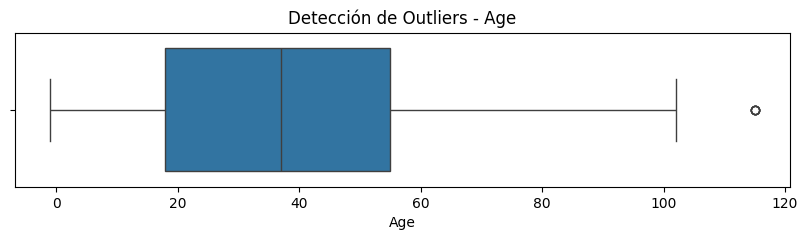

In [166]:
# Visualizar los outliers en las columnas numéricas
plot_outliers(X_train_, ['Age'])

In [167]:
X_train_[X_train_['Age']>80].count();

In [168]:
X_train_age = X_train_.copy()
X_test_age = X_test_.copy()

#### En X_test_age hay un registro con edad -1, para evitar problemas creamos el siguiente filtro:

In [169]:
X_train_age = X_train_age[X_train_age['Age'] >= 0]
X_test_age = X_test_age[X_test_age['Age'] >= 0]

In [170]:
y_train = y_train[X_train_age.index]
y_test = y_test[X_test_age.index]

In [171]:
# Verifico que los indicen sean los mismos y esten en el mismo orden
all(X_train_age.index == y_train.index)

True

In [172]:
all(X_test_age.index == y_test.index)

True

In [173]:
# Para el pipeline
# ('filter_age', FunctionTransformer(lambda df: df[df['Age'] >= 0], validate=False)

### Discretarizo la variable edad en diferentes grupos

In [174]:
# Diccionario de agrupamiento con los rangos de edad
age_binning_dict = {
    "Age": [0, 7, 12, 19, 39, 59, 79, 150]  # 150 para cubrir edades mayores a 115
}

# Crear el objeto discretiser
age_discretiser = ArbitraryDiscretiser(binning_dict=age_binning_dict, return_boundaries=False)

# Aplicar el discretizador al DataFrame
X_train_age['Age_group'] = age_discretiser.fit(X_train_age[['Age']])
X_train_age['Age_group'] = age_discretiser.transform(X_train_age[['Age']])
X_test_age['Age_group'] = age_discretiser.transform(X_test_age[['Age']])

In [175]:
class AddAgeGroupTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, binning_dict):
        self.binning_dict = binning_dict
        self.discretiser = ArbitraryDiscretiser(binning_dict=self.binning_dict, return_boundaries=False)

    def fit(self, X, y=None):
        # Ajustar el discretizador en la columna Age
        self.discretiser.fit(X[['Age']])
        return self

    def transform(self, X):
        X = X.copy()
        # Crear la nueva columna Age_group con los grupos discretizados
        X['Age_group'] = self.discretiser.transform(X[['Age']])
        return X

In [176]:
costum_age_discretiser = AddAgeGroupTransformer(binning_dict=age_binning_dict)

In [177]:
# Para el pipeline
# ('age_discretiser', costum_age_discretiser),

#### Cambio los nombre de los diferentes grupos de edades

In [178]:
# Mapeo de intervalos a etiquetas
age_group_mapping = {
    0: 'Infancia (0-6)',
    1: 'Niñez (7-12)',
    2: 'Adolescencia (13-19)',
    3: 'Jóvenes adultos (20-39)',
    4: 'Adultos medios (40-59)',
    5: 'Adultos mayores (60-79)',
    6: 'Ancianos (80+)'
}

# Aplicar el mapeo de intervalos a las etiquetas en ambas columnas
X_train_age['Age_group'] = X_train_age['Age_group'].map(age_group_mapping)
X_test_age['Age_group'] = X_test_age['Age_group'].map(age_group_mapping)

In [179]:
def map_age_group(value, mapping):
    return mapping.get(value, 'Desconocido')

class AgeGroupMapper(BaseEstimator, TransformerMixin):
    def __init__(self, mapping):
        self.mapping = mapping

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Utilizamos la función global para mapear
        X['Age_group'] = X['Age_group'].apply(map_age_group, args=(self.mapping,))
        return X

In [180]:
# Para el pipeline
age_group_mapper = AgeGroupMapper(age_group_mapping)
# ('age_group_mapper', age_group_mapper), 

In [181]:
X_train_age_clean = X_train_age.copy()
X_test_age_clean = X_test_age.copy()

In [182]:
X_train_age_clean.head(3)

PatientId Gender              ScheduledDay  \
64200  5.386962e+14      M 2016-05-11 07:24:56+00:00   
91954  1.923469e+12      F 2016-06-02 08:02:40+00:00   
11678  7.323343e+12      F 2016-05-16 08:35:36+00:00   

                 AppointmentDay  Age  Scholarship  Hipertension  Diabetes  \
64200 2016-05-11 00:00:00+00:00   36            0             0         0   
91954 2016-06-02 00:00:00+00:00   59            0             0         0   
11678 2016-05-16 00:00:00+00:00   32            0             0         0   

       Alcoholism  Handcap  SMS_received  Cluster    WaitingTime  DayOfWeek  \
64200           0        0             0        2  (-0.002, 0.0]  Wednesday   
91954           0        0             0        0  (-0.002, 0.0]   Thursday   
11678           0        0             0        0  (-0.002, 0.0]     Monday   

      ScheduledPeriod                Age_group  
64200          Mañana  Jóvenes adultos (20-39)  
91954          Mañana   Adultos medios (40-59)  
11678          Mañana  Jóvenes adultos (20-39)

In [183]:
y_train.head(3)

64200    0
91954    0
11678    0
Name: No-show, dtype: int32

### **PatientId**: Mantener esta caracteristica permite mantener el registro de asistencia de cada cliente, pero en lugar de tratarse como un numero entero se debería tatrar como tipo categorico, la cual tendría una cardinalidad elevada.

#### Determinar si un paciente saca turno por primera vez o no

In [184]:
def first_appointment_column(df):
    # Crear una copia del DataFrame para trabajar sobre ella
    df_copy = df.copy()

    # Ordenar la copia de df por 'PatientId' y 'AppointmentDay'
    df_copy = df_copy.sort_values(by=['PatientId', 'AppointmentDay'])

    # Crear la columna 'FirstTimeAppointment' en la copia de df para indicar si es el primer turno
    df_copy['FirstTimeAppointment'] = df_copy.groupby('PatientId')['AppointmentDay'].transform('min') == df_copy['AppointmentDay']

    # Agregar la nueva columna 'FirstTimeAppointment' al DataFrame original df, usando .loc para asegurar el orden correcto
    df['FirstTimeAppointment'] = df_copy.loc[df.index, 'FirstTimeAppointment']

    # Borrar la copia de df
    del df_copy

    # Devolver el DataFrame original df con la nueva columna
    return df

In [185]:
# Para agregar una fila si es el primer turno
X_train_age_clean = first_appointment_column(X_train_age_clean)
X_test_age_clean = first_appointment_column(X_test_age_clean)

In [186]:
X_train_age_clean[X_train_age_clean['PatientId'] == 999931985292928][['PatientId', 'ScheduledDay', 'AppointmentDay', 'FirstTimeAppointment']]

PatientId              ScheduledDay            AppointmentDay  \
62194   9.999320e+14 2016-04-25 14:46:41+00:00 2016-05-04 00:00:00+00:00   
62099   9.999320e+14 2016-05-16 09:29:43+00:00 2016-05-17 00:00:00+00:00   
104616  9.999320e+14 2016-06-03 16:04:03+00:00 2016-06-07 00:00:00+00:00   
32023   9.999320e+14 2016-05-17 15:22:01+00:00 2016-05-17 00:00:00+00:00   
32033   9.999320e+14 2016-05-25 08:14:58+00:00 2016-05-25 00:00:00+00:00   

        FirstTimeAppointment  
62194                   True  
62099                  False  
104616                 False  
32023                  False  
32033                  False

In [187]:
X_train_age_clean.head(3)

PatientId Gender              ScheduledDay  \
64200  5.386962e+14      M 2016-05-11 07:24:56+00:00   
91954  1.923469e+12      F 2016-06-02 08:02:40+00:00   
11678  7.323343e+12      F 2016-05-16 08:35:36+00:00   

                 AppointmentDay  Age  Scholarship  Hipertension  Diabetes  \
64200 2016-05-11 00:00:00+00:00   36            0             0         0   
91954 2016-06-02 00:00:00+00:00   59            0             0         0   
11678 2016-05-16 00:00:00+00:00   32            0             0         0   

       Alcoholism  Handcap  SMS_received  Cluster    WaitingTime  DayOfWeek  \
64200           0        0             0        2  (-0.002, 0.0]  Wednesday   
91954           0        0             0        0  (-0.002, 0.0]   Thursday   
11678           0        0             0        0  (-0.002, 0.0]     Monday   

      ScheduledPeriod                Age_group  FirstTimeAppointment  
64200          Mañana  Jóvenes adultos (20-39)                  True  
91954          Mañana   Adultos medios (40-59)                  True  
11678          Mañana  Jóvenes adultos (20-39)                  True

In [188]:
y_train.head(3)

64200    0
91954    0
11678    0
Name: No-show, dtype: int32

In [189]:
# Para el pipeline
first_time_appointment_transformer = FunctionTransformer(first_appointment_column, validate=False)
first_time_appointment_transformer.fit(X_train_age)
# ('first_time_appointment', first_time_appointment_transformer),

FunctionTransformer(func=<function first_appointment_column at 0x000001C154BF7E50>)

- **Hipertension**: Indica si el paciente tiene hipertensión (0 = No, 1 = Sí).
- **Diabetes**: Indica si el paciente tiene diabetes (0 = No, 1 = Sí).
- **Alcoholism**: Indica si el paciente tiene problemas con el alcohol (0 = No, 1 = Sí).
- **Handcap**: Número que indica el nivel de discapacidad del paciente.

#### Se crean las variables Comorbilidades, InteraccionCondicionesHandcap y RiesgoGeneral

Comorbilidades (suma de condiciones crónicas): Puedes crear una nueva característica que sume la cantidad de condiciones crónicas que tiene cada paciente (hipertensión, diabetes y alcoholismo). Algunos estudios sugieren que ciertas condiciones crónicas pueden llevar a una "fatiga de la atención", lo que podría aumentar las probabilidades de faltar.

In [190]:
X_train_2 = X_train_age_clean.copy()
X_test_2 = X_test_age_clean.copy()

In [191]:
X_train_2['Comorbilidades'] = X_train_2[['Hipertension', 'Diabetes', 'Alcoholism']].sum(axis=1)
X_test_2['Comorbilidades'] = X_test_2[['Hipertension', 'Diabetes', 'Alcoholism']].sum(axis=1)

X_train_2['InteraccionCondicionesHandcap'] = X_train_2['Comorbilidades'] * (X_train_2['Handcap'] + 1)
X_test_2['InteraccionCondicionesHandcap'] = X_test_2['Comorbilidades'] * (X_test_2['Handcap'] + 1)

X_train_2['RiesgoGeneral'] = X_train_2['Hipertension'] + X_train_2['Diabetes'] + (X_train_2['Alcoholism'])
X_test_2['RiesgoGeneral'] = X_test_2['Hipertension'] + X_test_2['Diabetes'] + (X_test_2['Alcoholism'])

In [192]:
X_train_2[['Hipertension', 'Diabetes', 'Alcoholism', 'Comorbilidades', 'InteraccionCondicionesHandcap', 'RiesgoGeneral']].describe()

Hipertension      Diabetes    Alcoholism  Comorbilidades  \
count  88417.000000  88417.000000  88417.000000    88417.000000   
mean       0.195098      0.071796      0.030605        0.297499   
std        0.396279      0.258152      0.172246        0.595523   
min        0.000000      0.000000      0.000000        0.000000   
25%        0.000000      0.000000      0.000000        0.000000   
50%        0.000000      0.000000      0.000000        0.000000   
75%        0.000000      0.000000      0.000000        0.000000   
max        1.000000      1.000000      1.000000        3.000000   

       InteraccionCondicionesHandcap  RiesgoGeneral  
count                   88417.000000   88417.000000  
mean                        0.311456       0.297499  
std                         0.645174       0.595523  
min                         0.000000       0.000000  
25%                         0.000000       0.000000  
50%                         0.000000       0.000000  
75%                         0.000000       0.000000  
max                         9.000000       3.000000

In [193]:
df_train = pd.concat([X_train_2, y_train], axis = 1)
df_test = pd.concat([X_test_2, y_test], axis = 1)

In [194]:
cat_features = ['Hipertension', 'Diabetes', 'Alcoholism', 'Comorbilidades', 'InteraccionCondicionesHandcap', 'RiesgoGeneral']

<Figure size 500x300 with 0 Axes>

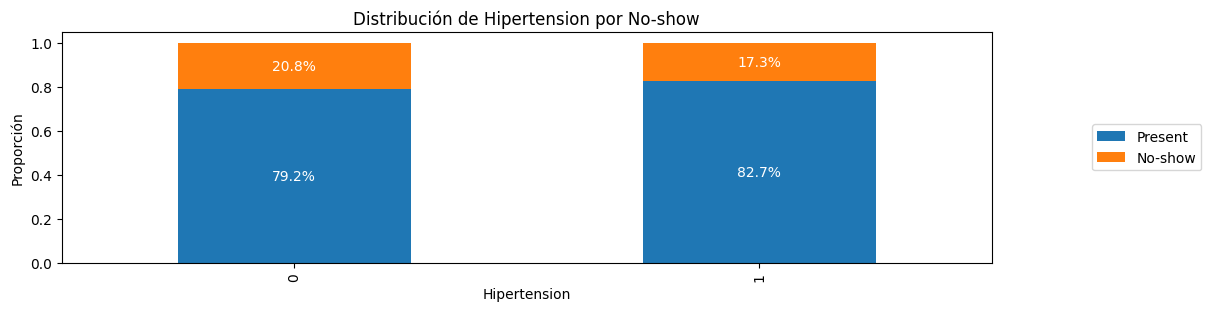

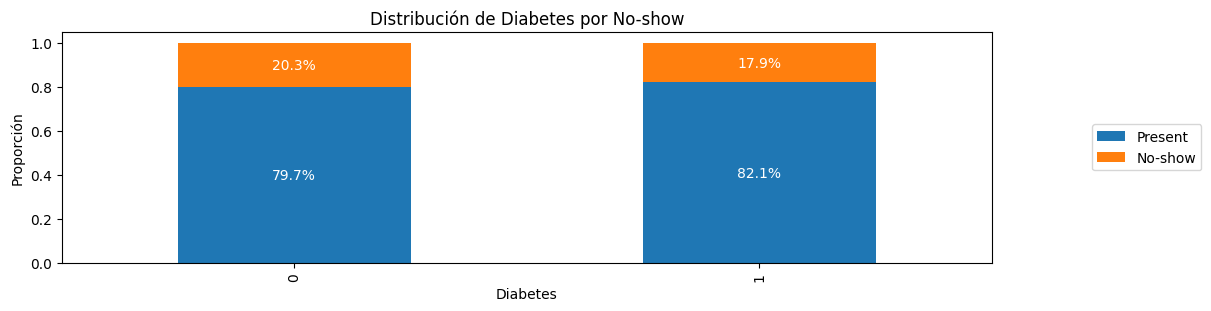

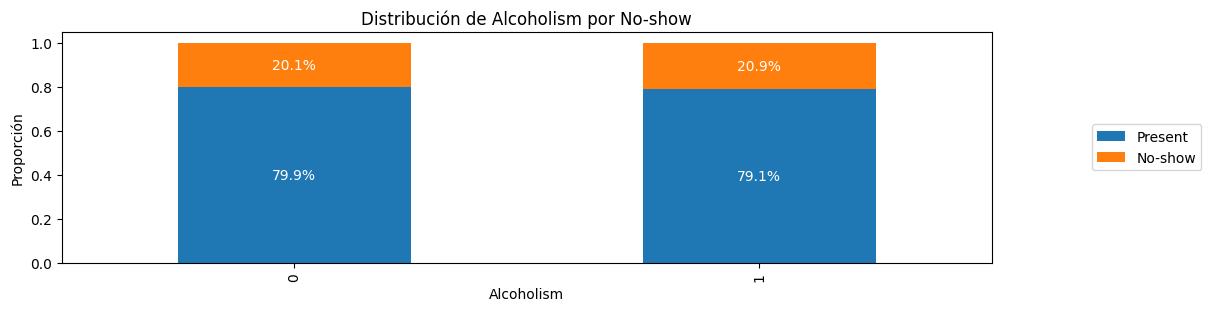

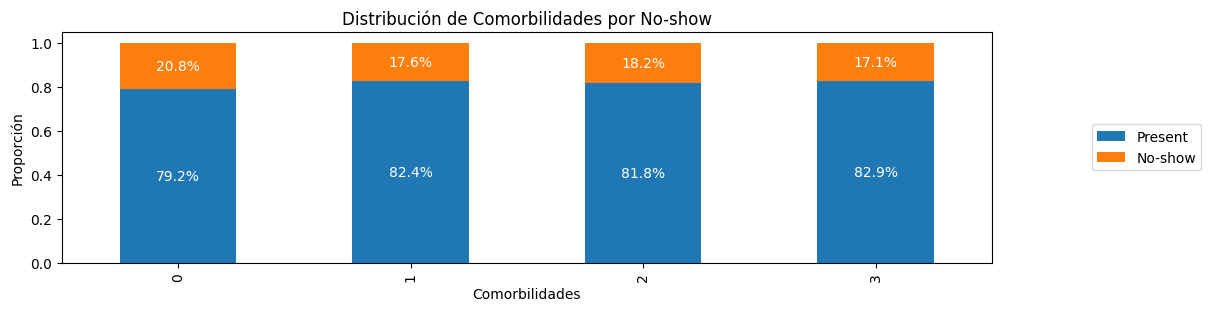

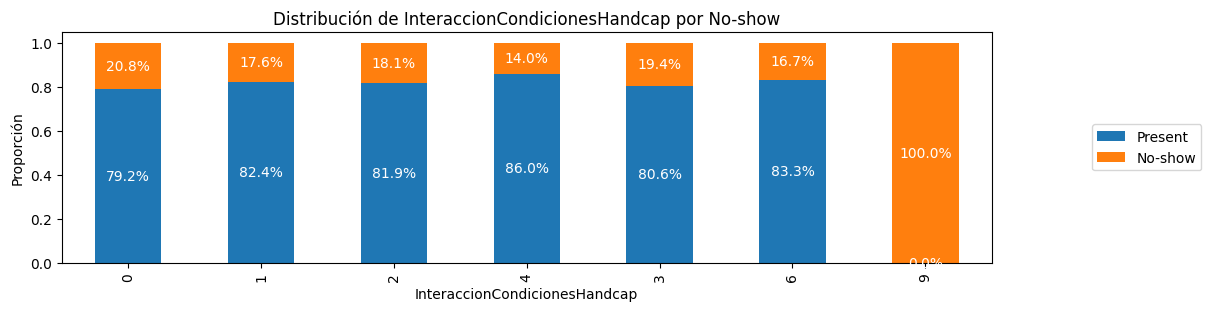

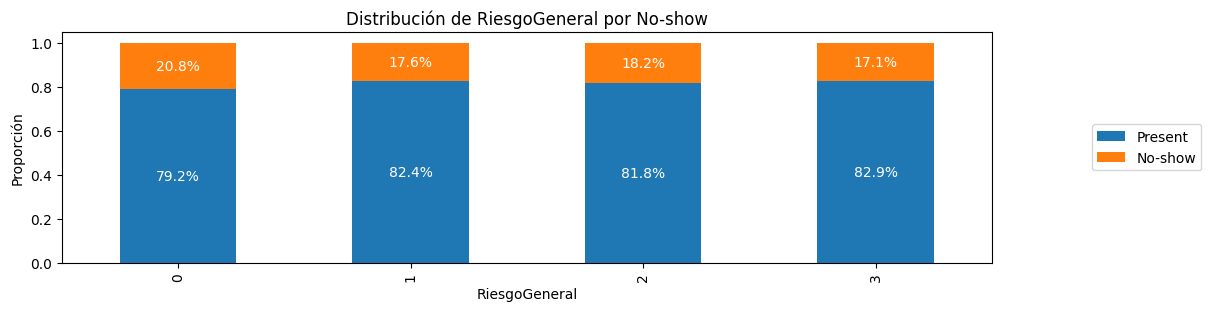

In [195]:
plt.figure(figsize=(5, 3))
for var in cat_features:
    if (var != 'No-show' and var != 'ScheduledDay'):
        # Crear una tabla de frecuencias absolutas
        freq_table = pd.crosstab(df_train[var], df_train["No-show"]).rename(columns={0: 'Present', 1: 'No-show'})
        
        # Calcular la frecuencia máxima para ordenar
        freq_table['Max'] = freq_table.max(axis=1)
        
        # Ordenar las categorías por la frecuencia máxima de cada clase 
        freq_table = freq_table.sort_values(by='Max', ascending=False)

        # Graficar la tabla de frecuencias normalizadas
        ax = freq_table[['Present', 'No-show']].div(freq_table[['Present', 'No-show']].sum(axis=1), axis=0).plot(kind="bar", stacked=True)
        
        plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center left')
        plt.title(f'Distribución de {var} por No-show')
        plt.xlabel(var)  
        plt.ylabel('Proporción') 
        
        # Agregar porcentajes en las barras, centrados
        for p in ax.patches:
            height = p.get_height()  # Altura de la barra
            width = p.get_width()  # Ancho de la barra
            x = p.get_x() + width / 2  # Posición x centrada
            y = p.get_y() + height / 2  # Posición y en el centro de la barra
            # Agregar el texto del porcentaje
            ax.annotate(f'{height:.1%}', (x, y), ha='center', va='center', color='white')

        plt.show()

In [196]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Asegúrate de que las columnas necesarias estén en X
        X = X.copy()
        
        # Calcular la suma de comorbilidades
        X['Comorbilidades'] = X[['Hipertension', 'Diabetes', 'Alcoholism']].sum(axis=1)
        
        # Calcular la interacción con Handcap
        X['InteraccionCondicionesHandcap'] = X['Comorbilidades'] * (X['Handcap'] + 1)
        
        # Calcular riesgo general
        X['RiesgoGeneral'] = X['Hipertension'] + X['Diabetes'] + X['Alcoholism']
        
        return X

In [197]:
# Para el pipeline
feature_transformer = FeatureEngineeringTransformer()
feature_transformer.fit(X_train_2)
# ('feature_engineering', feature_transformer),

FeatureEngineeringTransformer()

### Elimino caracteristicas

#### A **PatientId** lo podemos eliminamar porque generalizamos el comportamiento de las personas con **WaitingTime** y **FirstTimeAppointment**
#### A partir de **AppointmentDay** y **ScheduledDay** ya obtuvo **DayOfWeek** y **WaitingTime** por lo que tambien se pueden eliminar

In [198]:
drop_features = DropFeatures(features_to_drop=['Age', 'PatientId', 'ScheduledDay', 'AppointmentDay'])
X_train_2 = drop_features.fit_transform(X_train_2)
X_test_2 = drop_features.transform(X_test_2)

In [199]:
# Para el pipeline no es necesario crear una clase 
# ('drop_features',drop_features),

### Transformar los tipos de datos en los tipos correctos

In [200]:
X_train_2.dtypes

Gender                           object
Scholarship                       int64
Hipertension                      int64
Diabetes                          int64
Alcoholism                        int64
Handcap                           int64
SMS_received                      int64
Cluster                           int64
WaitingTime                      object
DayOfWeek                        object
ScheduledPeriod                  object
Age_group                        object
FirstTimeAppointment               bool
Comorbilidades                    int64
InteraccionCondicionesHandcap     int64
RiesgoGeneral                     int64
dtype: object

- **SMS_received**: Indica si el paciente recibió un SMS recordatorio de la cita (0 = No, 1 = Sí).
- **Scholarship**: Indica si el paciente está en un programa de ayuda social (0 = No, 1 = Sí).

In [201]:
X_train_2['Gender'] = X_train_2['Gender'].astype('category')
X_train_2['WaitingTime'] = X_train_2['WaitingTime'].astype('category')
X_train_2['DayOfWeek'] = X_train_2['DayOfWeek'].astype('category')
X_train_2['Age_group'] = X_train_2['Age_group'].astype('category')
X_train_2['Cluster'] = X_train_2['Cluster'].astype('category')
X_train_2['ScheduledPeriod'] = X_train_2['ScheduledPeriod'].astype('category')
X_train_2['FirstTimeAppointment'] = X_train_2['FirstTimeAppointment'].astype('int')

In [202]:
X_test_2['Gender'] = X_test_2['Gender'].astype('category')
X_test_2['WaitingTime'] = X_test_2['WaitingTime'].astype('category')
X_test_2['DayOfWeek'] = X_test_2['DayOfWeek'].astype('category')
X_test_2['Age_group'] = X_test_2['Age_group'].astype('category')
X_test_2['Cluster'] = X_test_2['Cluster'].astype('category')
X_test_2['ScheduledPeriod'] = X_test_2['ScheduledPeriod'].astype('category')
X_test_2['FirstTimeAppointment'] = X_test_2['FirstTimeAppointment'].astype('int')

In [203]:
X_train_2.dtypes

Gender                           category
Scholarship                         int64
Hipertension                        int64
Diabetes                            int64
Alcoholism                          int64
Handcap                             int64
SMS_received                        int64
Cluster                          category
WaitingTime                      category
DayOfWeek                        category
ScheduledPeriod                  category
Age_group                        category
FirstTimeAppointment                int32
Comorbilidades                      int64
InteraccionCondicionesHandcap       int64
RiesgoGeneral                       int64
dtype: object

In [204]:
class DType_first_Converter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()  # Evitar modificar el original
        
        X['Gender'] = X['Gender'].astype('category')      
        X['WaitingTime'] = X['WaitingTime'].astype('category')
        X['DayOfWeek'] = X['DayOfWeek'].astype('category')
        X['Age_group'] = X['Age_group'].astype('category')
        X['Cluster'] = X['Cluster'].astype('category')
        X['ScheduledPeriod'] = X['ScheduledPeriod'].astype('category')
        X['FirstTimeAppointment'] = X['FirstTimeAppointment'].astype('int')
               
        return X

In [205]:
# Para el pipeline
dtype_first_converter = DType_first_Converter()
dtype_first_converter.fit(X_train_2)
# ('dtype_first_converter', dtype_first_converter),

DType_first_Converter()

In [206]:
X_train_2.shape

(88417, 16)

In [207]:
X_train_2.nunique()

Gender                           2
Scholarship                      2
Hipertension                     2
Diabetes                         2
Alcoholism                       2
Handcap                          5
SMS_received                     2
Cluster                          4
WaitingTime                      8
DayOfWeek                        6
ScheduledPeriod                  3
Age_group                        7
FirstTimeAppointment             2
Comorbilidades                   4
InteraccionCondicionesHandcap    7
RiesgoGeneral                    4
dtype: int64

In [208]:
X_train_2.dtypes

Gender                           category
Scholarship                         int64
Hipertension                        int64
Diabetes                            int64
Alcoholism                          int64
Handcap                             int64
SMS_received                        int64
Cluster                          category
WaitingTime                      category
DayOfWeek                        category
ScheduledPeriod                  category
Age_group                        category
FirstTimeAppointment                int32
Comorbilidades                      int64
InteraccionCondicionesHandcap       int64
RiesgoGeneral                       int64
dtype: object

### Convertirlas variables categoricas en dummies

In [209]:
X_train_enc = X_train_2.copy()
X_test_enc = X_test_2.copy()

In [210]:
encoder = OneHotEncoder(
    drop = "first",   #if_binary
    sparse_output = False,
    handle_unknown = "infrequent_if_exist",  # helps deal with rare labels
    dtype = "int"
).set_output(transform="pandas")

In [211]:
cat_cols = X_train_enc.select_dtypes(include=['category', 'object']).columns

In [212]:
cat_cols

Index(['Gender', 'Cluster', 'WaitingTime', 'DayOfWeek', 'ScheduledPeriod',
       'Age_group'],
      dtype='object')

In [213]:
X_train_enc_aux = encoder.fit_transform(X_train_enc[cat_cols])

In [214]:
X_test_enc_aux = encoder.transform(X_test_enc[cat_cols])

In [215]:
X_train_enc_aux.shape

(88417, 24)

In [216]:
X_train_enc_aux.dtypes

Gender_M                             int32
Cluster_1                            int32
Cluster_2                            int32
Cluster_3                            int32
WaitingTime_(0.0, 1.0]               int32
WaitingTime_(1.0, 4.0]               int32
WaitingTime_(15.0, 31.0]             int32
WaitingTime_(31.0, 50.0]             int32
WaitingTime_(4.0, 7.0]               int32
WaitingTime_(50.0, inf]              int32
WaitingTime_(7.0, 15.0]              int32
DayOfWeek_Monday                     int32
DayOfWeek_Saturday                   int32
DayOfWeek_Thursday                   int32
DayOfWeek_Tuesday                    int32
DayOfWeek_Wednesday                  int32
ScheduledPeriod_Noche                int32
ScheduledPeriod_Tarde                int32
Age_group_Adultos mayores (60-79)    int32
Age_group_Adultos medios (40-59)     int32
Age_group_Ancianos (80+)             int32
Age_group_Infancia (0-6)             int32
Age_group_Jóvenes adultos (20-39)    int32
Age_group_N

In [217]:
X_train_prepro1 = X_train_enc.drop(columns = cat_cols) 
X_train_prepro1 = pd.concat([X_train_prepro1, X_train_enc_aux], axis= 1)
X_train_prepro1.head(2)

Scholarship  Hipertension  Diabetes  Alcoholism  Handcap  SMS_received  \
64200            0             0         0           0        0             0   
91954            0             0         0           0        0             0   

       FirstTimeAppointment  Comorbilidades  InteraccionCondicionesHandcap  \
64200                     1               0                              0   
91954                     1               0                              0   

       RiesgoGeneral  ...  DayOfWeek_Tuesday  DayOfWeek_Wednesday  \
64200              0  ...                  0                    1   
91954              0  ...                  0                    0   

       ScheduledPeriod_Noche  ScheduledPeriod_Tarde  \
64200                      0                      0   
91954                      0                      0   

       Age_group_Adultos mayores (60-79)  Age_group_Adultos medios (40-59)  \
64200                                  0                                 0   
91954                                  0                                 1   

       Age_group_Ancianos (80+)  Age_group_Infancia (0-6)  \
64200                         0                         0   
91954                         0                         0   

       Age_group_Jóvenes adultos (20-39)  Age_group_Niñez (7-12)  
64200                                  1                       0  
91954                                  0                       0  

[2 rows x 34 columns]

In [218]:
X_test_prepro1 = X_test_2.drop(columns = cat_cols) 
X_test_prepro1 = pd.concat([X_test_prepro1, X_test_enc_aux], axis= 1)
X_test_prepro1.head(2)

Scholarship  Hipertension  Diabetes  Alcoholism  Handcap  \
104581            0             0         0           0        0   
106123            0             0         0           0        0   

        SMS_received  FirstTimeAppointment  Comorbilidades  \
104581             0                     0               0   
106123             1                     0               0   

        InteraccionCondicionesHandcap  RiesgoGeneral  ...  DayOfWeek_Tuesday  \
104581                              0              0  ...                  0   
106123                              0              0  ...                  0   

        DayOfWeek_Wednesday  ScheduledPeriod_Noche  ScheduledPeriod_Tarde  \
104581                    1                      0                      0   
106123                    1                      0                      0   

        Age_group_Adultos mayores (60-79)  Age_group_Adultos medios (40-59)  \
104581                                  1                                 0   
106123                                  0                                 0   

        Age_group_Ancianos (80+)  Age_group_Infancia (0-6)  \
104581                         0                         0   
106123                         0                         0   

        Age_group_Jóvenes adultos (20-39)  Age_group_Niñez (7-12)  
104581                                  0                       0  
106123                                  1                       0  

[2 rows x 34 columns]

In [219]:
class CustomOneHotEncoder_drop_first(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Aquí especificamos dtype=int32 para la salida del OneHotEncoder
        self.encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="infrequent_if_exist", dtype='int32')
    
    def fit(self, X, y=None):
        # Seleccionar solo las columnas categóricas
        cat_cols = X.select_dtypes(include=['category', 'object']).columns
        self.encoder.fit(X[cat_cols])
        return self

    def transform(self, X):
        # Seleccionar solo las columnas categóricas
        cat_cols = X.select_dtypes(include=['category', 'object']).columns
        # Transformar solo las columnas categóricas
        X_encoded = self.encoder.transform(X[cat_cols])
        
        # Crear un DataFrame con las columnas codificadas, forzando el tipo de dato a int32
        encoded_df = pd.DataFrame(X_encoded, columns=self.encoder.get_feature_names_out(input_features=cat_cols), index=X.index, dtype='int32')
        
        # Concatenar el DataFrame original (sin las columnas categóricas) con el DataFrame codificado
        X_remaining = X.drop(columns=cat_cols)
        return pd.concat([X_remaining, encoded_df], axis=1)

In [220]:
class CustomOneHotEncoder_if_binary(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Aquí especificamos dtype=int32 para la salida del OneHotEncoder
        self.encoder = OneHotEncoder(drop="if_binary", sparse_output=False, handle_unknown="infrequent_if_exist", dtype='int32')
    
    def fit(self, X, y=None):
        # Seleccionar solo las columnas categóricas
        cat_cols = X.select_dtypes(include=['category', 'object']).columns
        self.encoder.fit(X[cat_cols])
        return self

    def transform(self, X):
        # Seleccionar solo las columnas categóricas
        cat_cols = X.select_dtypes(include=['category', 'object']).columns
        # Transformar solo las columnas categóricas
        X_encoded = self.encoder.transform(X[cat_cols])
        
        # Crear un DataFrame con las columnas codificadas, forzando el tipo de dato a int32
        encoded_df = pd.DataFrame(X_encoded, columns=self.encoder.get_feature_names_out(input_features=cat_cols), index=X.index, dtype='int32')
        
        # Concatenar el DataFrame original (sin las columnas categóricas) con el DataFrame codificado
        X_remaining = X.drop(columns=cat_cols)
        return pd.concat([X_remaining, encoded_df], axis=1)

In [221]:
# para el pipeline
drop_first = CustomOneHotEncoder_drop_first()
drop_first.fit(X_train_2)
# ('custom_onehot_encoder', drop_first),

CustomOneHotEncoder_drop_first()

In [222]:
# o
drop_binary = CustomOneHotEncoder_if_binary()
drop_binary.fit(X_train_2)
#('custom_onehot_encoder', drop_binary),

CustomOneHotEncoder_if_binary()

#### Verifico que drop_first devuleva lo mismo que el enfoque manual

In [223]:
X_train_custom = drop_first.fit_transform(X_train_2)
X_train_manual = pd.concat([X_train_2.drop(columns=cat_cols), X_train_enc_aux], axis=1)

# Comparar resultados
if X_train_custom.equals(X_train_manual):
    print("Los resultados coinciden perfectamente")
else:
    print("Los resultados no coinciden")

Los resultados coinciden perfectamente


#### Analizo las caracteristicas que se pueden codificar ordinalmente

In [224]:
X_train_prepro1.loc[:, X_train_prepro1.nunique() > 2].describe()

Handcap  Comorbilidades  InteraccionCondicionesHandcap  \
count  88417.000000    88417.000000                   88417.000000   
mean       0.021376        0.297499                       0.311456   
std        0.158085        0.595523                       0.645174   
min        0.000000        0.000000                       0.000000   
25%        0.000000        0.000000                       0.000000   
50%        0.000000        0.000000                       0.000000   
75%        0.000000        0.000000                       0.000000   
max        4.000000        3.000000                       9.000000   

       RiesgoGeneral  
count   88417.000000  
mean        0.297499  
std         0.595523  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         3.000000

In [225]:
columnas_ordinales = X_train_prepro1.columns[X_train_prepro1.nunique() > 2].tolist()

In [226]:
columnas_ordinales

['Handcap', 'Comorbilidades', 'InteraccionCondicionesHandcap', 'RiesgoGeneral']

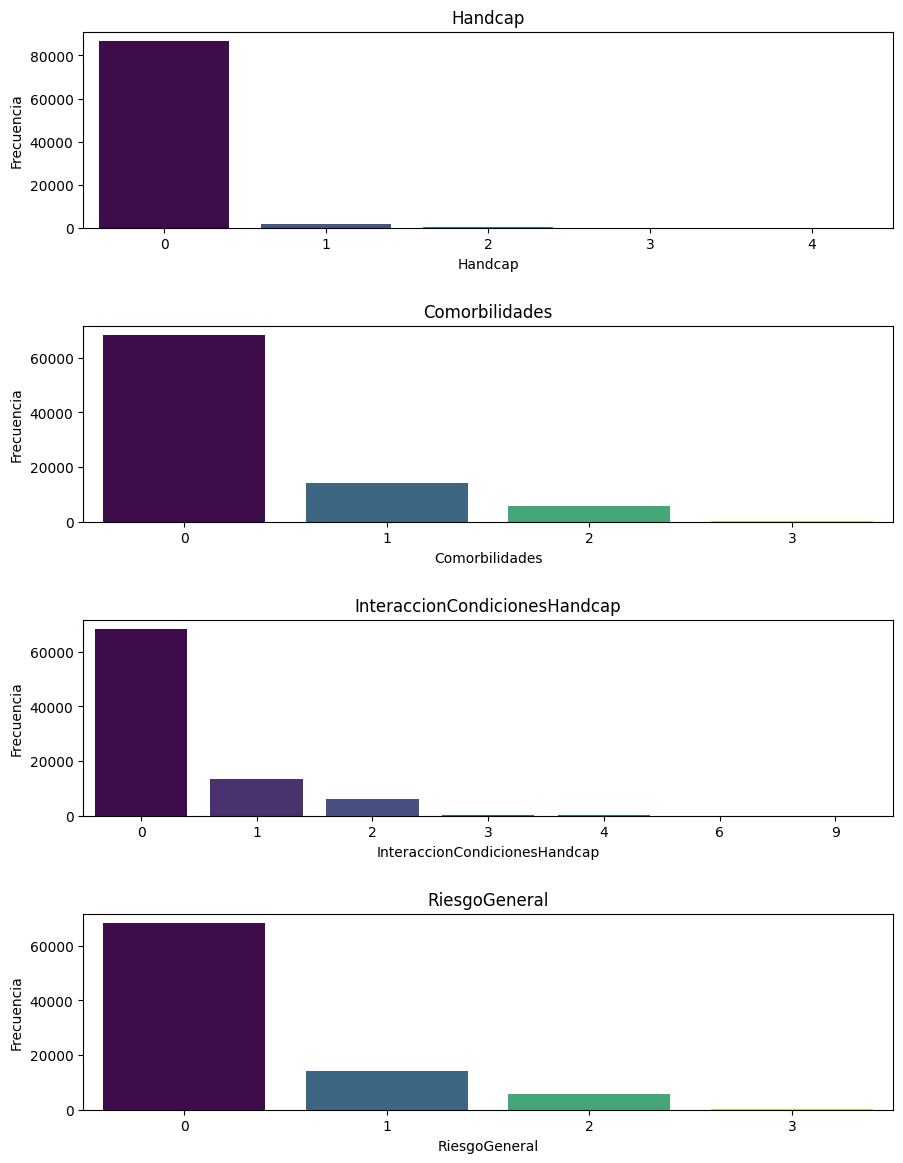

In [227]:
num_vars = len(columnas_ordinales)
num_cols_subplot = 1  # Usar una columna
num_rows_subplot = math.ceil(num_vars / num_cols_subplot)

# Aumentar el tamaño total de la figura
plt.figure(figsize=(12, 5 + (num_rows_subplot - 1) * 3))  # Ajusta el multiplicador según sea necesario

for i, var in enumerate(columnas_ordinales):
    plt.subplot(num_rows_subplot, num_cols_subplot, i + 1)
    
    # Contar las frecuencias de cada valor único en la variable
    value_counts = X_train_prepro1[var].value_counts().sort_index()
    
    # Graficar un gráfico de barras con el parámetro hue
    sns.barplot(x=value_counts.index, y=value_counts.values, hue=value_counts.index, palette="viridis", legend=False)
    
    plt.title(var)  # Añadir título a cada subplot
    plt.xlabel(var)  # Añadir etiqueta en el eje x
    plt.ylabel('Frecuencia')  # Añadir etiqueta en el eje y

# Ajustar espacio entre filas
plt.subplots_adjust(hspace=0.5, right=0.8)  # Dejar espacio a la derecha para la leyenda

plt.show()

### Escalo las variables

In [228]:
X_train_scaled = X_train_prepro1.copy()
X_test_scaled = X_test_prepro1.copy()

In [229]:
scaler = MinMaxScaler().set_output(transform="pandas")
scaler.fit(X_train_scaled[columnas_ordinales])
X_train_scaled[columnas_ordinales] = scaler.transform(X_train_scaled[columnas_ordinales])
X_test_scaled[columnas_ordinales] = scaler.transform(X_test_scaled[columnas_ordinales])

In [230]:
#### Al crear una clase para escalar no tengo problemas con el transform para el conjunto de prueba

In [231]:
# Definir la función que aplica MinMaxScaler
class CustomMinMaxScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Inicializamos el escalador, pero no lo ajustamos aún
        self.scaler = MinMaxScaler()
    
    def fit(self, X, y=None):
        # Solo ajustamos el escalador a las columnas que necesitamos
        columns_to_scale = ['Handcap', 'Comorbilidades', 'InteraccionCondicionesHandcap', 'RiesgoGeneral']
        # Fit el escalador usando solo las columnas seleccionadas
        self.scaler.fit(X[columns_to_scale])
        return self
    
    def transform(self, X):
        # Transformamos los mismos datos con el escalador ajustado
        X_scaled = X.copy()
        columns_to_scale = ['Handcap', 'Comorbilidades', 'InteraccionCondicionesHandcap', 'RiesgoGeneral']
        X_scaled[columns_to_scale] = self.scaler.transform(X[columns_to_scale])
        return X_scaled

In [232]:
# Para el pipeline
costum_scaler = CustomMinMaxScaler()
costum_scaler.fit(X_train_prepro1)

CustomMinMaxScaler()

In [233]:
X_train_scaled[columnas_ordinales].describe()

Handcap  Comorbilidades  InteraccionCondicionesHandcap  \
count  88417.000000    88417.000000                   88417.000000   
mean       0.005344        0.099166                       0.034606   
std        0.039521        0.198508                       0.071686   
min        0.000000        0.000000                       0.000000   
25%        0.000000        0.000000                       0.000000   
50%        0.000000        0.000000                       0.000000   
75%        0.000000        0.000000                       0.000000   
max        1.000000        1.000000                       1.000000   

       RiesgoGeneral  
count   88417.000000  
mean        0.099166  
std         0.198508  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

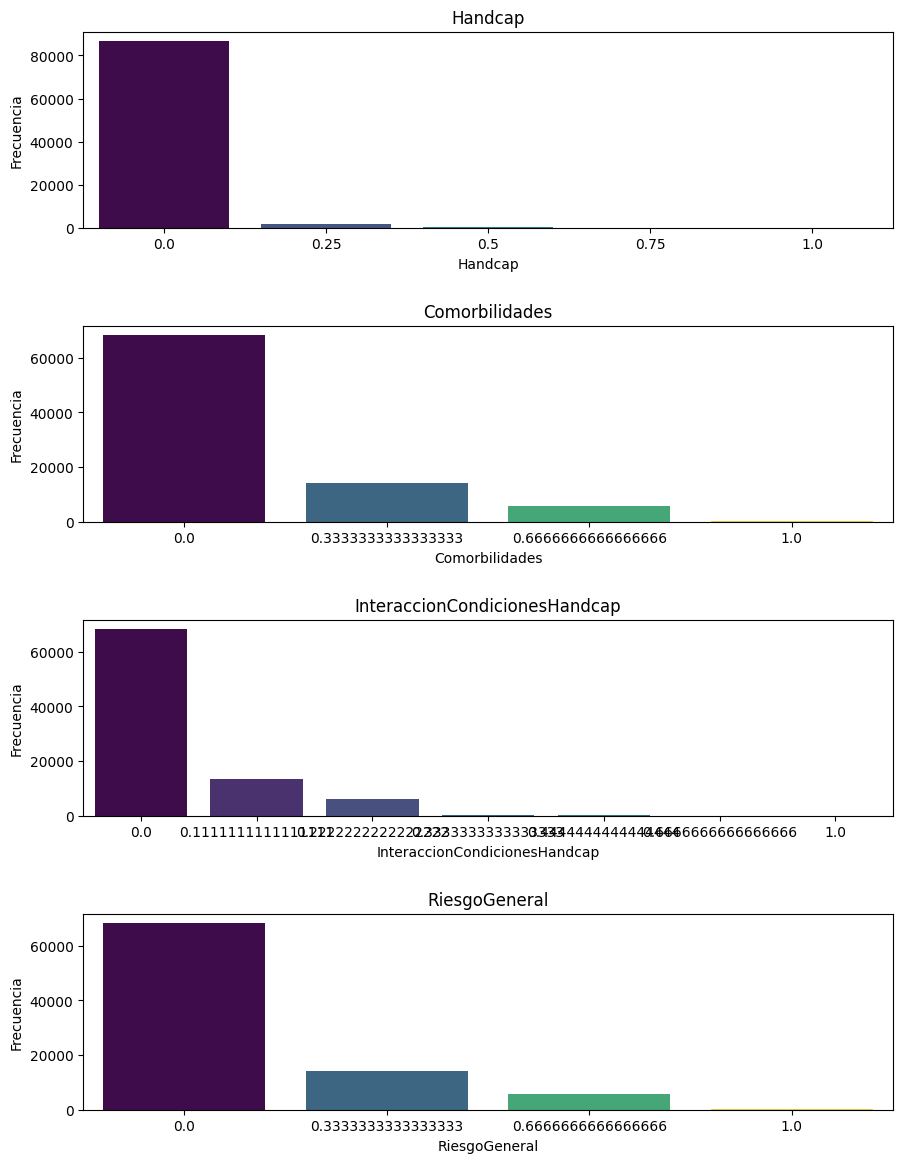

In [234]:
num_vars = len(columnas_ordinales)
num_cols_subplot = 1  # Usar una columna
num_rows_subplot = math.ceil(num_vars / num_cols_subplot)

# Aumentar el tamaño total de la figura
plt.figure(figsize=(12, 5 + (num_rows_subplot - 1) * 3))  # Ajusta el multiplicador según sea necesario

for i, var in enumerate(columnas_ordinales):
    plt.subplot(num_rows_subplot, num_cols_subplot, i + 1)
    
    # Contar las frecuencias de cada valor único en la variable
    value_counts = X_train_scaled[var].value_counts().sort_index()
    
    # Graficar un gráfico de barras con el parámetro hue
    sns.barplot(x=value_counts.index, y=value_counts.values, hue=value_counts.index, palette="viridis", legend=False)
    
    plt.title(var)  # Añadir título a cada subplot
    plt.xlabel(var)  # Añadir etiqueta en el eje x
    plt.ylabel('Frecuencia')  # Añadir etiqueta en el eje y

# Ajustar espacio entre filas
plt.subplots_adjust(hspace=0.5, right=0.8)  # Dejar espacio a la derecha para la leyenda

plt.show()

In [235]:
X_train = X_train_scaled.copy()
X_test = X_test_scaled.copy()

In [236]:
X_train.head(3)

Scholarship  Hipertension  Diabetes  Alcoholism  Handcap  SMS_received  \
64200            0             0         0           0      0.0             0   
91954            0             0         0           0      0.0             0   
11678            0             0         0           0      0.0             0   

       FirstTimeAppointment  Comorbilidades  InteraccionCondicionesHandcap  \
64200                     1             0.0                            0.0   
91954                     1             0.0                            0.0   
11678                     1             0.0                            0.0   

       RiesgoGeneral  ...  DayOfWeek_Tuesday  DayOfWeek_Wednesday  \
64200            0.0  ...                  0                    1   
91954            0.0  ...                  0                    0   
11678            0.0  ...                  0                    0   

       ScheduledPeriod_Noche  ScheduledPeriod_Tarde  \
64200                      0                      0   
91954                      0                      0   
11678                      0                      0   

       Age_group_Adultos mayores (60-79)  Age_group_Adultos medios (40-59)  \
64200                                  0                                 0   
91954                                  0                                 1   
11678                                  0                                 0   

       Age_group_Ancianos (80+)  Age_group_Infancia (0-6)  \
64200                         0                         0   
91954                         0                         0   
11678                         0                         0   

       Age_group_Jóvenes adultos (20-39)  Age_group_Niñez (7-12)  
64200                                  1                       0  
91954                                  0                       0  
11678                                  1                       0  

[3 rows x 34 columns]

In [237]:
y_train.head(3)

64200    0
91954    0
11678    0
Name: No-show, dtype: int32

## Pipeline para preprocesmiento de datos

In [238]:
from imblearn.pipeline import Pipeline 

In [239]:
appointment_preprocessing_pipeline = Pipeline([
    ('drop_feature_AppointmentID', drop_feature_AppointmentID),
    ('rare_Neighbourhood_encoder', rare_encoder),
    ('cluster_mapper', cluster_mapper),
    ('drop_feature_Neighbourhood', drop_feature_Neighbourhood),
    ('datetime_converter', datetime_transformer),
    ('calculate_waiting_time', waiting_time_transformer),
    ('filter_dates', FunctionTransformer(lambda df: df[df['WaitingTime'] >= 0], validate=False)),
    ('extract_hour', hour_transformer),
    ('assign_period_of_day', period_of_day_transformer),
    ('calculate_day_of_week', day_of_week_transformer),
    ('drop_feature_hour', drop_feature_hour),
    ('WaitingTime_Discretiser', WaitingTime_Discretiser),
    ('filter_age', FunctionTransformer(lambda df: df[df['Age'] >= 0], validate=False)),
    ('age_discretiser', costum_age_discretiser),
    ('age_group_mapper', age_group_mapper), 
    ('first_time_appointment', first_time_appointment_transformer),  
    ('feature_engineering', feature_transformer),
    ('drop_features', drop_features),
    ('dtype_first_converter', dtype_first_converter),
    
    ('custom_onehot_encoder', drop_first),
    # o
    #('custom_onehot_encoder', drop_binary),

    ('scaler', costum_scaler)
])

### Verifico que el pipeline funciones correctamente

#### Verifico paso a paso las transformaciones del pipeline en un conjunto muestra

In [240]:
df_raw = raw_data.copy()

# Dividir los datos
df_raw = df_raw.sample(frac=1, random_state=420)
X_raw = df_raw.drop(columns="No-show")
y_raw = df_raw.loc[:, ['No-show']]

# Muestra pequeña para pruebas
prueba_data = X_raw.sample(50)
y_prueba = y_raw.loc[prueba_data.index]  # Tomar las mismas filas de y

# Ejecutar el pipeline
for nombre, paso in appointment_preprocessing_pipeline.steps:
    prueba_data = paso.fit_transform(prueba_data)

print(f"\nDespués de {nombre}:\n", prueba_data.head(5))


Después de scaler:
         Scholarship  Hipertension  Diabetes  Alcoholism  Handcap  \
35819             0             0         0           0      0.0   
69349             0             0         0           0      0.0   
92791             0             0         0           0      0.0   
100810            0             0         0           0      0.0   
67281             0             0         0           0      0.0   

        SMS_received  FirstTimeAppointment  Comorbilidades  \
35819              0                     1             0.0   
69349              1                     1             0.0   
92791              0                     1             0.0   
100810             0                     1             0.0   
67281              0                     1             0.0   

        InteraccionCondicionesHandcap  RiesgoGeneral  ...  \
35819                             0.0            0.0  ...   
69349                             0.0            0.0  ...   
92791         

### Verifico paso a paso los tipos de datos al aplicar las transformaciones del pipeline en un conjunto muestra

In [241]:
df_raw = raw_data.copy()

# Dividir los datos
df_raw = df_raw.sample(frac=1, random_state=420)
X_raw = df_raw.drop(columns="No-show")
y_raw = df_raw.loc[:, ['No-show']]

# Muestra pequeña para pruebas
prueba_data = X_raw.sample(50)
y_prueba = y_raw.loc[prueba_data.index]  # Tomar las mismas filas de y
# Ejecutar el pipeline y controlar los tipos de datos
for nombre, paso in appointment_preprocessing_pipeline.steps:
    prueba_data = paso.fit_transform(prueba_data)
    
print(f"\nDespués de {nombre}:\n", prueba_data.dtypes)


Después de scaler:
 Scholarship                            int64
Hipertension                           int64
Diabetes                               int64
Alcoholism                             int64
Handcap                              float64
SMS_received                           int64
FirstTimeAppointment                   int32
Comorbilidades                       float64
InteraccionCondicionesHandcap        float64
RiesgoGeneral                        float64
Gender_M                               int32
Cluster_1                              int32
Cluster_2                              int32
Cluster_3                              int32
WaitingTime_(0.0, 1.0]                 int32
WaitingTime_(1.0, 4.0]                 int32
WaitingTime_(15.0, 31.0]               int32
WaitingTime_(31.0, 50.0]               int32
WaitingTime_(4.0, 7.0]                 int32
WaitingTime_(50.0, inf]                int32
WaitingTime_(7.0, 15.0]                int32
ScheduledPeriod_Tarde             

### Verifico paso a paso que los indices de y correspondan a los de X

In [242]:
df_raw = raw_data.copy()

# Dividir los datos
df_raw = df_raw.sample(frac=1, random_state=420)
X_raw = df_raw.drop(columns="No-show")
y_raw = df_raw.loc[:, ['No-show']]

# Muestra pequeña para pruebas
prueba_data = X_raw.sample(50)
y_prueba = y_raw.loc[prueba_data.index]  # Tomar las mismas filas de y

# Lista para registrar discrepancias
discrepancias = []

for nombre, paso in appointment_preprocessing_pipeline.steps:
    # Verificar que X e y tengan los mismos índices antes de cualquier transformación
    if isinstance(prueba_data, pd.DataFrame) and isinstance(y_prueba, pd.DataFrame):
        if not prueba_data.index.equals(y_prueba.index):
            discrepancias.append(f"Índices desincronizados antes del paso {nombre}")

    prueba_data = paso.fit_transform(prueba_data)

    # Verificar que X e y siguen teniendo los mismos índices después de la transformación
    if isinstance(prueba_data, pd.DataFrame) and isinstance(y_prueba, pd.DataFrame):
        if not prueba_data.index.equals(y_prueba.index):
            discrepancias.append(f"Índices desincronizados después del paso {nombre}")

# Mostrar las discrepancias si existen
if discrepancias:
    print("Se encontraron discrepancias en los índices:")
    for mensaje in discrepancias:
        print(mensaje)
else:
    print("Los índices se mantuvieron sincronizados en todos los pasos.")

Los índices se mantuvieron sincronizados en todos los pasos.


### Verfico que el pipiline no genere valores nulos

In [243]:
prueba_data.isnull().sum().sum()

0

### Función para verificar que no haya diferencias entre el conjunto trabajado con el generado con el pipeline

In [244]:
def verificar_diferencias(df1, df2):
    """
    Función para verificar las diferencias entre dos DataFrames, incluyendo:
    - A: Comparación de los índices
    - B: Comparación de los tipos de datos de las columnas
    - C: Comparación de los valores de las celdas
    - D: Verificación de la existencia de NaN
    - E: Verificación del orden de los índices

    Imprime los resultados de cada comparación.
    """

    # A. Comparar los índices
    if df1.index.equals(df2.index):
        print("A: Los índices coinciden.")
    else:
        print("A: Los índices no coinciden.")

    # B. Comparar tipos de datos de las columnas
    print("B: Tipos de datos de las columnas:")
    if df1.dtypes.equals(df2.dtypes):
        print("Los tipos de datos de las columnas de df1 y df2 son iguales.")
    else:
        print("Los tipos de datos de las columnas de df1 y df2 no son iguales.")

    # C. Comparar valores de las celdas
    if df1.equals(df2):
        print("C: Los DataFrames son exactamente iguales (índices y valores).")
    else:
        print("C: Los DataFrames no son iguales en valores o índices.")

    # D. Verificar la existencia de NaN
    print("D: Verificación de NaN en cada DataFrame:")
    print(f"NaN en df1: {df1.isna().sum().sum()} valores NaN")
    print(f"NaN en df2: {df2.isna().sum().sum()} valores NaN")
    
    # E. Verificar el orden de los índices y si son únicos
    print("E: Verificación del orden y unicidad de los índices:")
    if df1.index.is_unique:
        print("Los índices de df1 son únicos.")
    else:
        print("Los índices de df1 no son únicos.")
    
    if df2.index.is_unique:
        print("Los índices de df2 son únicos.")
    else:
        print("Los índices de df2 no son únicos.")

    if all(df1.index == df2.index):
        print("El orden de los índices es el mismo en ambos DataFrames.")
    else:
        print("El orden de los índices es diferente entre df1 y df2.")

### Reproduzco la forma en la que se definieron los conjuntos de entrenamiento y prueba

In [245]:
# Define la semilla para la aleatoriedad
seed = 7
np.random.seed(seed)

# Paso 1: Mezcla los IDs de los pacientes aleatoriamente
unique_patient_ids = df_raw['PatientId'].unique()
np.random.shuffle(unique_patient_ids)

# Paso 2: Reasigna a cada paciente un nuevo grupo en el orden aleatorio
patient_id_mapping = {patient_id: idx for idx, patient_id in enumerate(unique_patient_ids)}
df_raw['ShuffledGroup'] = df_raw['PatientId'].map(patient_id_mapping)

# Paso 3: Usa `GroupKFold` con los grupos aleatorizados
gkf = GroupKFold(n_splits = 5)
groups = df_raw['ShuffledGroup']

for train_idx, test_idx in gkf.split(X_raw, y_raw, groups=groups):
    X_train_raw, X_test_raw = X_raw.iloc[train_idx], X_raw.iloc[test_idx]
    y_train_raw, y_test_raw = y_raw.iloc[train_idx], y_raw.iloc[test_idx]

#### Mapeo los valores de los conjuntos de datos con las variables dependientes

In [246]:
y_train_raw.loc[:, 'No-show'] = y_train_raw['No-show'].map({'Yes': 1, 'No': 0})
y_test_raw.loc[:, 'No-show'] = y_test_raw['No-show'].map({'Yes': 1, 'No': 0})

In [247]:
y_train_raw.loc[:, 'No-show'] = y_train_raw['No-show'].astype('int')
y_test_raw.loc[:, 'No-show'] = y_test_raw['No-show'].astype('int')

In [248]:
y_train_raw.head(3)

No-show
64200       0
91954       0
11678       0

#### Aplico el pipeline

In [249]:
# Ajustar el pipeline con los datos de entrenamiento
appointment_preprocessing_pipeline.fit(X_train_raw.copy())  # Solo ajusta en X_train_raw --> Mejorar: evitar la nececidad del fit

# Aplicar las transformaciones tanto en X_train_raw como en X_test_raw
X_train_pipe = appointment_preprocessing_pipeline.transform(X_train_raw)  # Transforma X_train_raw
X_test_pipe = appointment_preprocessing_pipeline.transform(X_test_raw)    # Transforma X_test_raw

y_train_pipe = y_train[X_train_pipe.index]
y_test_pipe = y_test[X_test_pipe.index]

In [250]:
X_train_pipe.shape, X_train_raw.shape

((88417, 34), (88422, 13))

In [251]:
X_train.shape

(88417, 34)

#### Verifico que los datos resultantes del pipeline sean los mismo que los obtenidos sin el pipeline

In [252]:
# Verifico que los indicen sean los mismos y esten en el mismo orden
all(y_train_pipe.index == y_train.index)

True

In [253]:
all(y_test_pipe.index == y_test.index)

True

In [254]:
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)

In [255]:
y_train_pipe = pd.DataFrame(y_train_pipe)
y_test_pipe = pd.DataFrame(y_test_pipe)

In [256]:
verificar_diferencias(y_train_pipe, y_train_df)

A: Los índices coinciden.
B: Tipos de datos de las columnas:
Los tipos de datos de las columnas de df1 y df2 son iguales.
C: Los DataFrames son exactamente iguales (índices y valores).
D: Verificación de NaN en cada DataFrame:
NaN en df1: 0 valores NaN
NaN en df2: 0 valores NaN
E: Verificación del orden y unicidad de los índices:
Los índices de df1 son únicos.
Los índices de df2 son únicos.
El orden de los índices es el mismo en ambos DataFrames.


In [257]:
# Verificar si son iguales
are_equal = X_train_pipe.equals(X_train)
print("\n¿Son iguales los DataFrames?", are_equal)


¿Son iguales los DataFrames? False


In [258]:
X_train.shape

(88417, 34)

In [259]:
X_train_pipe.shape

(88417, 34)

In [260]:
# Comparamos las diferencias
diferencias = set(X_train_pipe.columns) - set(X_train.columns)
print("Columnas diferentes:", diferencias)

Columnas diferentes: set()


In [261]:
# Comparamos las diferencias
diferencias = set(X_train.columns) - set(X_train_pipe.columns)
print("Columnas diferentes:", diferencias)

Columnas diferentes: set()


In [262]:
# Comparar si las columnas están en el mismo orden
if X_train.columns.equals(X_train_pipe.columns):
    print("Las columnas están en el mismo orden.")
else:
    print("Las columnas no están en el mismo orden.")

Las columnas no están en el mismo orden.


In [263]:
# Asegurarse de que las columnas de X_train_pipe_loaded estén en el mismo orden que las de X_train
X_train_pipe = X_train_pipe[X_train.columns]

In [264]:
# Comparar si las columnas están en el mismo orden
if X_train.columns.equals(X_train_pipe.columns):
    print("Las columnas están en el mismo orden.")
else:
    print("Las columnas no están en el mismo orden.")

Las columnas están en el mismo orden.


In [265]:
verificar_diferencias(X_train_pipe, X_train)

A: Los índices coinciden.
B: Tipos de datos de las columnas:
Los tipos de datos de las columnas de df1 y df2 son iguales.
C: Los DataFrames son exactamente iguales (índices y valores).
D: Verificación de NaN en cada DataFrame:
NaN en df1: 0 valores NaN
NaN en df2: 0 valores NaN
E: Verificación del orden y unicidad de los índices:
Los índices de df1 son únicos.
Los índices de df2 son únicos.
El orden de los índices es el mismo en ambos DataFrames.


In [266]:
# Asegurarse de que las columnas de X_train_pipe_loaded estén en el mismo orden que las de X_train
X_test_pipe = X_test_pipe[X_test.columns]

In [267]:
# Comparar si las columnas están en el mismo orden
if X_test.columns.equals(X_test_pipe.columns):
    print("Las columnas están en el mismo orden.")
else:
    print("Las columnas no están en el mismo orden.")

Las columnas están en el mismo orden.


In [268]:
verificar_diferencias(X_test_pipe, X_test)

A: Los índices coinciden.
B: Tipos de datos de las columnas:
Los tipos de datos de las columnas de df1 y df2 son iguales.
C: Los DataFrames son exactamente iguales (índices y valores).
D: Verificación de NaN en cada DataFrame:
NaN en df1: 0 valores NaN
NaN en df2: 0 valores NaN
E: Verificación del orden y unicidad de los índices:
Los índices de df1 son únicos.
Los índices de df2 son únicos.
El orden de los índices es el mismo en ambos DataFrames.


#### Analisis de problemas en escalado (solucionado)

In [269]:
are_equal = X_train.equals(X_test_pipe)

if not are_equal:
    print("\nLos DataFrames no son idénticos, mostrando diferencias:")
    differences = X_test_pipe.compare(X_test)
    print(differences)
else:
    print("Los DataFrames son idénticos.")


Los DataFrames no son idénticos, mostrando diferencias:
Empty DataFrame
Columns: []
Index: []


In [270]:
X_test_pipe['InteraccionCondicionesHandcap'].describe()

count    22104.000000
mean         0.035946
std          0.073597
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.666667
Name: InteraccionCondicionesHandcap, dtype: float64

In [271]:
X_test['InteraccionCondicionesHandcap'].describe()

count    22104.000000
mean         0.035946
std          0.073597
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.666667
Name: InteraccionCondicionesHandcap, dtype: float64

#### Creo conjuntos de datos más aptos para arboles

In [272]:
appointment_preprocessing_pipeline_trees = Pipeline([
    ('drop_feature_AppointmentID', drop_feature_AppointmentID),
    ('rare_Neighbourhood_encoder', rare_encoder),
    ('cluster_mapper', cluster_mapper),
    ('drop_feature_Neighbourhood', drop_feature_Neighbourhood),
    ('datetime_converter', datetime_transformer),
    ('calculate_waiting_time', waiting_time_transformer),
    ('filter_dates', FunctionTransformer(lambda df: df[df['WaitingTime'] >= 0], validate=False)),
    ('extract_hour', hour_transformer),
    ('assign_period_of_day', period_of_day_transformer),
    ('calculate_day_of_week', day_of_week_transformer),
    ('drop_feature_hour', drop_feature_hour),
    ('WaitingTime_Discretiser', WaitingTime_Discretiser),
    ('filter_age', FunctionTransformer(lambda df: df[df['Age'] >= 0], validate=False)),
    ('age_discretiser', costum_age_discretiser),
    ('age_group_mapper', age_group_mapper), 
    ('first_time_appointment', first_time_appointment_transformer),  
    ('feature_engineering', feature_transformer),
    ('drop_features', drop_features),
    ('dtype_first_converter', dtype_first_converter),
    ('custom_onehot_encoder', drop_binary),
    ('scaler', costum_scaler)
])

In [273]:
# Ajustar el pipeline con los datos de entrenamiento
appointment_preprocessing_pipeline_trees.fit(X_train_raw)  # Solo ajusta en X_train_raw

# Aplicar las transformaciones tanto en X_train_raw como en X_test_raw
X_train_pipe_trees = appointment_preprocessing_pipeline_trees.transform(X_train_raw)  # Transforma X_train_raw
X_test_pipe_trees = appointment_preprocessing_pipeline_trees.transform(X_test_raw)    # Transforma X_test_raw

In [274]:
X_train_pipe_trees.shape

(88417, 39)

In [275]:
# Definir la ruta común
base_path = "../Medical Appointment No Show/Proceced Datasets/"

# Lista de nombres de los DataFrames
dataset_names = [
    'X_train_pipe',
    'X_test_pipe',
    'X_train_pipe_trees',
    'X_test_pipe_trees',
    'y_train_pipe',
    'y_test_pipe'
]

# Función para exportar DataFrames con el índice, manteniendo el índice original
def export_with_index(df, filepath, index_name='IndexName'):
    # Mantener el índice original y asignar un nombre personalizado al índice
    df_with_index = df.copy()
    df_with_index.index.name = index_name  # Asignar un nombre al índice sin resetearlo
    df_with_index.to_csv(filepath, index=True)  # Exportar el CSV manteniendo el índice

# Exportar cada DataFrame usando la función
for name in dataset_names:
    df = globals()[name]  # Accede al DataFrame por su nombre
    filepath = os.path.join(base_path, name + '.csv')  # Construir la ruta del archivo
    export_with_index(df, filepath)

## Exporto los conjuntos de datos procesados

In [276]:
# Función para importar DataFrames y eliminar el nombre del índice
def import_with_index(filepath):
    # Leer el CSV con el índice
    df = pd.read_csv(filepath, index_col=0)
    # Eliminar el nombre del índice
    df.index.name = None
    return df

X_train = import_with_index(os.path.join(base_path, 'X_train_pipe.csv'))
X_test = import_with_index(os.path.join(base_path, 'X_test_pipe.csv'))

X_train_trees = import_with_index(os.path.join(base_path, 'X_train_pipe_trees.csv'))
X_test_trees = import_with_index(os.path.join(base_path, 'X_test_pipe_trees.csv'))

y_train = import_with_index(os.path.join(base_path, 'y_train_pipe.csv'))
y_test = import_with_index(os.path.join(base_path, 'y_test_pipe.csv'))

In [277]:
all(X_train.index == y_train.index)

True

In [278]:
X_train.shape, X_test.shape

((88417, 34), (22104, 34))

In [279]:
# Asegúrate de que y_train sea un Series unidimensional
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]  # Seleccionar la primera columna como un Series

# Asegúrate de que y_train sea un Series unidimensional
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0]  # Seleccionar la primera columna como un Series

## Selección de modelo

### Funciones objetivos para determinar los mejores parametros con Optuna

In [280]:
def objective_logit(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'penalty': trial.suggest_categorical('logit_penalty', ['l1', 'l2']),
        'C': trial.suggest_float('logit_c', 1e-5, 1e2, log=True),
        'solver': trial.suggest_categorical('logit_solver', ['liblinear', 'saga']),
        'max_iter': trial.suggest_int('logit_max_iter', 100, 1000),
    }
    
    # Crear el modelo utilizando **param
    model = LogisticRegression(**param)
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

from sklearn.calibration import CalibratedClassifierCV

def objective_svc(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'C': trial.suggest_float('svc_c', 1e-5, 1e2, log=True),
        'kernel': trial.suggest_categorical('svc_kernel', ['linear', 'poly']),
        'gamma': trial.suggest_categorical('svc_gamma', ['scale', 'auto']),
        'degree': trial.suggest_int('svc_degree', 2, 4),
        'random_state': 42
    }
    
    # Crear el modelo base SVC
    model = SVC(**param)
    # Calibrar el modelo para obtener predict_proba
    calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv=5)
    
    # Usar el modelo calibrado para la validación cruzada
    score = cross_val_score(calibrated_model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

def objective_gbm(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'n_estimators': trial.suggest_int("gbm_n_estimators", 50, 200),
        'learning_rate': trial.suggest_float("gbm_learning_rate", 0.01, 0.2),
        'max_depth': trial.suggest_int("gbm_max_depth", 1, 25),
        'min_samples_split': trial.suggest_int("gbm_min_samples_split", 2, 100),
        'min_samples_leaf': trial.suggest_int("gbm_min_samples_leaf", 1, 200),
        'max_features': trial.suggest_categorical("gbm_max_features", ['sqrt', 'log2', None]),
        'random_state': 42
    }

    # Crear el modelo utilizando **param
    model = GradientBoostingClassifier(**param)    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

def objective_knn(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'n_neighbors': trial.suggest_int('knn_n_neighbors', 3, 49, step=2),
        'weights': trial.suggest_categorical('knn_weights', ['uniform', 'distance']),
        'p': trial.suggest_int('knn_p', 1, 2),
    }

    # Crear el modelo utilizando **param
    model = KNeighborsClassifier(**param)
    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

def objective_naive(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'var_smoothing': trial.suggest_float('naive_var_smoothing', 1e-3, 1e0, log=True)
    }

    # Crear el modelo utilizando **param
    model = GaussianNB(**param)
    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

def objective_rf(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'n_estimators': trial.suggest_int("rf_n_estimators", 50, 300),
        'max_depth': trial.suggest_int("rf_max_depth", 1, 30),
        'min_samples_split': trial.suggest_int("rf_min_samples_split", 2, 400),
        'min_samples_leaf': trial.suggest_int("rf_min_samples_leaf", 1, 400),
        'max_features': trial.suggest_categorical("rf_max_features", [None, 'sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical("rf_bootstrap", [True, False]),
        'random_state': 42
    }
    
    # Crear el modelo utilizando **param
    model = RandomForestClassifier(**param)
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

def objective_dt(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'max_depth': trial.suggest_int("dt_max_depth", 1, 20),
        'min_samples_split': trial.suggest_int("dt_min_samples_split", 2, 400),
        'min_samples_leaf': trial.suggest_int("dt_min_samples_leaf", 1, 400),
        'criterion': trial.suggest_categorical("dt_criterion", ["gini", "entropy"]),
        'random_state': 42
    }

    # Crear el modelo utilizando **param
    model = DecisionTreeClassifier(**param)
    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

def objective_lgbm(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 1e-2, log=True), 
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'random_state': 42,
#        'class_weight': 'balanced'  # Address class imbalance
    }

    # Crear el modelo utilizando **param
    model = lgb.LGBMClassifier(**param, verbose=0)
    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

### Definición de funciones para la evaluación de los modelos

In [281]:
def resultados(y, y_pred, y_proba=None):
    """
    Esta función evalúa el rendimiento de un modelo de clasificación utilizando
    una matriz de confusión y, si se proporcionan probabilidades, la curva AUC-ROC.
    
    Parámetros:
    - y: array-like, valores verdaderos de las etiquetas de clase (etiquetas reales).
    - y_pred: array-like, valores predichos por el modelo (etiquetas predichas).
    - y_proba: array-like, probabilidades predichas por el modelo (opcional).
    """
    # Matriz de confusión
    conf_matrix = confusion_matrix(y, y_pred, normalize='true')
    
    # Configuración de la figura
    if y_proba is None:
        fig, ax = plt.subplots(figsize=(5, 4))  # Una sola figura si no hay `y_proba`
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', vmin=0, vmax=1, center=0.5, ax=ax)
        ax.set_title("Matriz de Confusión")
        ax.set_ylabel('Real')
        ax.set_xlabel('Predicho')
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Dos subfiguras si hay `y_proba`
        
        # Graficar la matriz de confusión
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', vmin=0, vmax=1, center=0.5, ax=axes[0])
        axes[0].set_title("Matriz de Confusión")
        axes[0].set_ylabel('Real')
        axes[0].set_xlabel('Predicho')
        
        # Calcular y graficar la curva AUC-ROC
        fpr, tpr, _ = roc_curve(y, y_proba)
        auc_score = roc_auc_score(y, y_proba)
        axes[1].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
        axes[1].plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
        axes[1].set_title("Curva AUC-ROC")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Reporte de clasificación
    print(classification_report(y, y_pred))

In [282]:
def model_evaluation(model, X_train, y_train, metric='accuracy'):
    """
    Esta función evalúa el rendimiento del modelo utilizando K-Fold Cross-Validation
    y devuelve métricas de rendimiento, así como el riesgo de sobreajuste.

    Parámetros:
    - model: el modelo a evaluar.
    - X_train: conjunto de datos de entrenamiento.
    - y_train: etiquetas del conjunto de entrenamiento.

    Retorna:
    - df: DataFrame con las métricas de rendimiento.
    - overfitting_risk: diccionario con información sobre el riesgo de sobreajuste.
    """
    # K-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    try:
        # Estimación del error de generalización
        clf = cross_validate(
            model,
            X_train,
            y_train,
            scoring= metric,
            return_train_score=True,
            cv=kf
        )

        # Calcular valores para el conjunto de entrenamiento
        mean_train_score = np.mean(clf['train_score'])
        std_train_score = np.std(clf['train_score'])

        # Calcular el intervalo para el conjunto de entrenamiento
        interval_lower_train = mean_train_score - 3 * std_train_score
        interval_upper_train = mean_train_score + 3 * std_train_score

        # Calcular el puntaje medio y el intervalo para el conjunto de prueba
        mean_test_score = np.mean(clf['test_score']) if 'test_score' in clf else np.nan
        std_test_score = np.std(clf['test_score']) if 'test_score' in clf else np.nan

        # Calcular el intervalo para el conjunto de prueba
        interval_lower_test = mean_test_score - 3 * std_test_score if not np.isnan(mean_test_score) else np.nan
        interval_upper_test = mean_test_score + 3 * std_test_score if not np.isnan(mean_test_score) else np.nan

        # Crear el DataFrame con las métricas
        df = pd.DataFrame({
            'mean': [mean_train_score, mean_test_score],
            'std': [std_train_score, std_test_score],
            'interval_lower': [interval_lower_train, interval_lower_test],
            'interval_upper': [interval_upper_train, interval_upper_test]
        }, index=['train_set', 'test_set'])

        # Prueba t para comparar las puntuaciones de entrenamiento y prueba
        t_stat, p_value = stats.ttest_ind(clf['train_score'], clf['test_score'], equal_var=False)

        # Diccionario con la probabilidad de sobreajuste
        overfitting_risk = {
            't_statistic': t_stat,
            'p_value': p_value,
            'overfitting_likelihood': 'High' if p_value < 0.10 else 'Low'
        }

        return df, overfitting_risk

    except Exception as e:
        print(f"Error al evaluar el modelo: {e}")
        return None, None

### Busco los mejores parametros para diferentes modelos

#### Adapto los nombres de las columnas para que lgb.LGBMClassifier puede manejarlas

In [283]:
X_train.columns = X_train.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)

In [284]:
X_train_trees.columns = X_train_trees.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)
X_test_trees.columns = X_test_trees.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)

In [285]:
class ColumnNameCleaner(BaseEstimator, TransformerMixin):
    """
    Clase para limpiar y transformar los nombres de las columnas de un DataFrame.
    Reemplaza caracteres no alfanuméricos o guiones bajos con guiones bajos.
    """
    def __init__(self, pattern=r'[^A-Za-z0-9_]+', replacement='_'):
        self.pattern = pattern
        self.replacement = replacement

    def fit(self, X, y=None):
        # No se requiere ajuste para transformar los nombres de las columnas
        return self

    def transform(self, X):
        # Asegurarse de que sea un DataFrame con nombres de columnas
        X = X.copy()
        if hasattr(X, 'columns'):
            X.columns = X.columns.str.replace(self.pattern, self.replacement, regex=True)
        return X

cleaner = ColumnNameCleaner()

#### Diccionario con los modelos y sus funciones objective correspondientes

In [286]:
model_dict = {
    'lgbm': objective_lgbm,
    'knn': objective_knn,
    'naive': objective_naive,
    'dt': objective_dt,
    'logit': objective_logit,
#    'rf': objective_rf,
#    'gbm': objective_gbm 
}

#### Seleccion de metrica a optimizar

In [287]:
chosen_metric = 'recall'

### Busqueda propiamente dicha

In [288]:
directory = "../Medical Appointment No Show/Parameters/"

In [289]:
import time

In [290]:
# Intentar leer el archivo CSV, si no existe, ejecutar la optimización
try:
    # Intentar leer el archivo CSV
    trials_df1 = pd.read_csv(f"{directory}parameters_trials_1.csv")
    print("Archivo leído correctamente.\n")

except FileNotFoundError:
    # Si el archivo no existe, ejecutar la optimización
    print("Archivo no encontrado. Ejecutando optimización...")

    best_params_df = pd.DataFrame(columns=["model", "params", "score"])  # Agregar columna para la métrica

    # Loop sobre los modelos
    for model_name, objective_func in model_dict.items():
        # Medir el tiempo de inicio de la iteración
        start_time = time.time()
        
        # Crear el estudio para cada modelo
        study = optuna.create_study(direction='maximize', pruner=HyperbandPruner())

        # Optimizar el modelo con Optuna utilizando su función objective correspondiente
        study.optimize(lambda trial: objective_func(trial, X_train_trees, y_train, metric = chosen_metric), n_trials = 90)

        # Obtener los mejores parámetros y la mejor puntuación
        best_params = study.best_params
        best_score = study.best_value  # Obtiene la mejor puntuación (por ejemplo, accuracy o roc_auc)

        # Medir el tiempo de finalización de la iteración
        end_time = time.time()

        # Calcular el tiempo transcurrido en segundos
        elapsed_time = end_time - start_time
        print(f'Búsqueda en {model_name} finalizada. Tiempo de ejecución: {elapsed_time:.2f} segundos')

        # Guardar en el DataFrame usando pd.concat()
        best_params_df = pd.concat([best_params_df, pd.DataFrame([{"model": model_name, 
                                                                   "params": best_params, 
                                                                   "score": best_score}])], ignore_index=True)

    # Guardar los resultados en un archivo CSV
    best_params_df.to_csv(f"{directory}parameters_trials_1.csv", index=False)
    print("Resultados guardados en parameters_trials_1.csv")

# Leer el archivo CSV después de guardar
trials_df1 = pd.read_csv(f"{directory}parameters_trials_1.csv")
print("Archivo leído correctamente después de la optimización.\n")

Archivo leído correctamente.

Archivo leído correctamente después de la optimización.



In [291]:
trials_df1

model                                             params     score
0   lgbm  {'num_leaves': 87, 'max_depth': 10, 'learning_...  0.128217
1    knn  {'knn_n_neighbors': 3, 'knn_weights': 'distanc...  0.218369
2  naive      {'naive_var_smoothing': 0.007485114954993629}  0.507405
3     dt  {'dt_max_depth': 20, 'dt_min_samples_split': 1...  0.126021
4  logit  {'logit_penalty': 'l2', 'logit_c': 92.44199240...  0.006419

### Defino una función para corregir el nombre de los parametros

In [292]:
def remove_prefix_and_modify_params(params, model_name, prefix):
    """Elimina el prefijo de los parámetros y cambia 'c' a 'C' para logit y svc."""
    
    # Eliminar el prefijo de los parámetros
    new_params = {}
    for key, value in params.items():

        # Eliminar el prefijo y mantener el valor del parámetro
        if key.startswith(prefix):
            new_key = key[len(prefix):]  # Eliminar el prefijo
        else:
            new_key = key  # Si no tiene prefijo, usamos la clave original

        # Cambiar 'c' a 'C' para los modelos logit y svc
        if model_name in ['logit', 'svc'] and new_key == 'c':
            print(f"Se encontró 'c' como clave para {model_name}. Cambiando a 'C'.")
            new_key = 'C'  # Cambiar 'c' a 'C'

        new_params[new_key] = value
    
    return new_params

In [293]:
# Recorremos cada fila del DataFrame y removemos el prefijo de los parámetros
for index, row in trials_df1.iterrows():
    # Cargar los parámetros de la columna 'params' como diccionario
    params = eval(row['params'])  # Convertir string a diccionario

    # Obtener el nombre del modelo
    model_name = row['model']
    
    # Si el modelo es 'lgbm', no hay prefijo; en otros casos, usamos el nombre del modelo seguido de un guion bajo
    if model_name == "lgbm":
        prefix = ""
    else:
        prefix = f"{model_name}_"

    # Remover el prefijo y cambiar 'c' a 'C' si es necesario
    new_params = remove_prefix_and_modify_params(params, model_name, prefix)

    # Actualizar la columna 'params' con los nuevos parámetros sin prefijo
    trials_df1.at[index, 'params'] = new_params

# Imprimir el DataFrame actualizado después de la depuración
print("\nDataFrame actualizado:")
print(trials_df1)

Se encontró 'c' como clave para logit. Cambiando a 'C'.

DataFrame actualizado:
   model                                             params     score
0   lgbm  {'num_leaves': 87, 'max_depth': 10, 'learning_...  0.128217
1    knn  {'n_neighbors': 3, 'weights': 'distance', 'p': 2}  0.218369
2  naive            {'var_smoothing': 0.007485114954993629}  0.507405
3     dt  {'max_depth': 20, 'min_samples_split': 12, 'mi...  0.126021
4  logit  {'penalty': 'l2', 'C': 92.44199240970192, 'sol...  0.006419


### Evaluación de los modelo

In [294]:
model_dict = {
    'gbm': GradientBoostingClassifier,
    'knn': KNeighborsClassifier,
    'naive': GaussianNB,
    'dt': DecisionTreeClassifier,
    'lgbm': lgb.LGBMClassifier,
    'logit': LogisticRegression,
    'rf': RandomForestClassifier,
}

In [295]:
# Nombre del archivo CSV relacionado con "comportamiento_mejores_parametros"
csv_filename = os.path.join(directory, "best_params_results.csv")  # Uso de os.path.join para mayor seguridad

# Verifica si el directorio existe, si no, lo crea
if not os.path.exists(directory):
    os.makedirs(directory)  # Crea el directorio si no existe

# Verifica si el archivo ya existe
if os.path.exists(csv_filename):
    # Si el archivo existe, solo se lee y se omite el proceso de evaluación y guardado
    results_df = pd.read_csv(csv_filename)
    print("El archivo ya existe. Se han cargado los resultados desde el archivo.")
else:
    # Si el archivo no existe, se realiza el cálculo y se guarda el archivo
    results_df = pd.DataFrame(columns=["model", "mean_train_score", "std_train_score", "interval_lower_train", 
                                       "interval_upper_train", "mean_test_score", "std_test_score", 
                                       "interval_lower_test", "interval_upper_test", "overfitting_risk", "p_value"])

    # Para cada modelo en trials_df1, crea y entrena el modelo utilizando los parámetros
    for index, row in trials_df1.iterrows():
        model_name = row['model']
        params = row['params']

        # Si el modelo es 'lgbm', no necesita prefijo como los otros modelos
        if model_name != 'lgbm':
            # Remover el prefijo (modelo_name + "_") de los parámetros
            params = {k.replace(f'{model_name}_', ''): v for k, v in params.items()}

        # Crear el modelo usando los parámetros
        model_class = model_dict[model_name]
        model = model_class(**params)

        # Evaluar el modelo usando la función 'model_evaluation'
        df, overfitting_risk = model_evaluation(model, X_train, y_train, metric = chosen_metric)

        # Extraer los resultados de la evaluación
        mean_train_score = df.loc['train_set', 'mean']
        std_train_score = df.loc['train_set', 'std']
        interval_lower_train = df.loc['train_set', 'interval_lower']
        interval_upper_train = df.loc['train_set', 'interval_upper']
        
        mean_test_score = df.loc['test_set', 'mean']
        std_test_score = df.loc['test_set', 'std']
        interval_lower_test = df.loc['test_set', 'interval_lower']
        interval_upper_test = df.loc['test_set', 'interval_upper']

        # Extraer el valor p
        p_value = overfitting_risk.get('p_value', 1.0)

        # Crear un diccionario con los resultados para agregar al DataFrame
        results = {
            "model": model_name,
            "mean_train_score": mean_train_score,
            "std_train_score": std_train_score,
            "interval_lower_train": interval_lower_train,
            "interval_upper_train": interval_upper_train,
            "mean_test_score": mean_test_score,
            "std_test_score": std_test_score,
            "interval_lower_test": interval_lower_test,
            "interval_upper_test": interval_upper_test,
            "overfitting_risk": overfitting_risk['overfitting_likelihood'],
            "p_value": p_value
        }

        # Agregar los resultados al DataFrame de resultados
        results_df = pd.concat([results_df, pd.DataFrame([results])], ignore_index=True)
    
    # Guardar los resultados en el archivo CSV
    results_df.to_csv(csv_filename, index=False)
    print("El archivo ha sido creado y los resultados han sido guardados.")

El archivo ya existe. Se han cargado los resultados desde el archivo.


In [296]:
results_df

model  mean_train_score  std_train_score  interval_lower_train  \
0   lgbm          0.235722         0.004436              0.222415   
1    knn          0.435925         0.003536              0.425317   
2  naive          0.309692         0.006389              0.290525   
3     dt          0.236165         0.002628              0.228280   
4  logit          0.006419         0.001262              0.002634   

   interval_upper_train  mean_test_score  std_test_score  interval_lower_test  \
0              0.249030         0.117723        0.007389             0.095558   
1              0.446533         0.215857        0.006014             0.197814   
2              0.328858         0.308546        0.006539             0.288929   
3              0.244051         0.133372        0.004539             0.119755   
4              0.010205         0.006583        0.000804             0.004170   

   interval_upper_test overfitting_risk       p_value  
0             0.139889             High  5.274609e-08  
1             0.233899             High  2.851287e-10  
2             0.328163              Low  8.084348e-01  
3             0.146990             High  7.057212e-09  
4             0.008996              Low  8.332551e-01

### Grafico los resultados para poder compararlos

In [297]:
from matplotlib.colors import Normalize, LinearSegmentedColormap

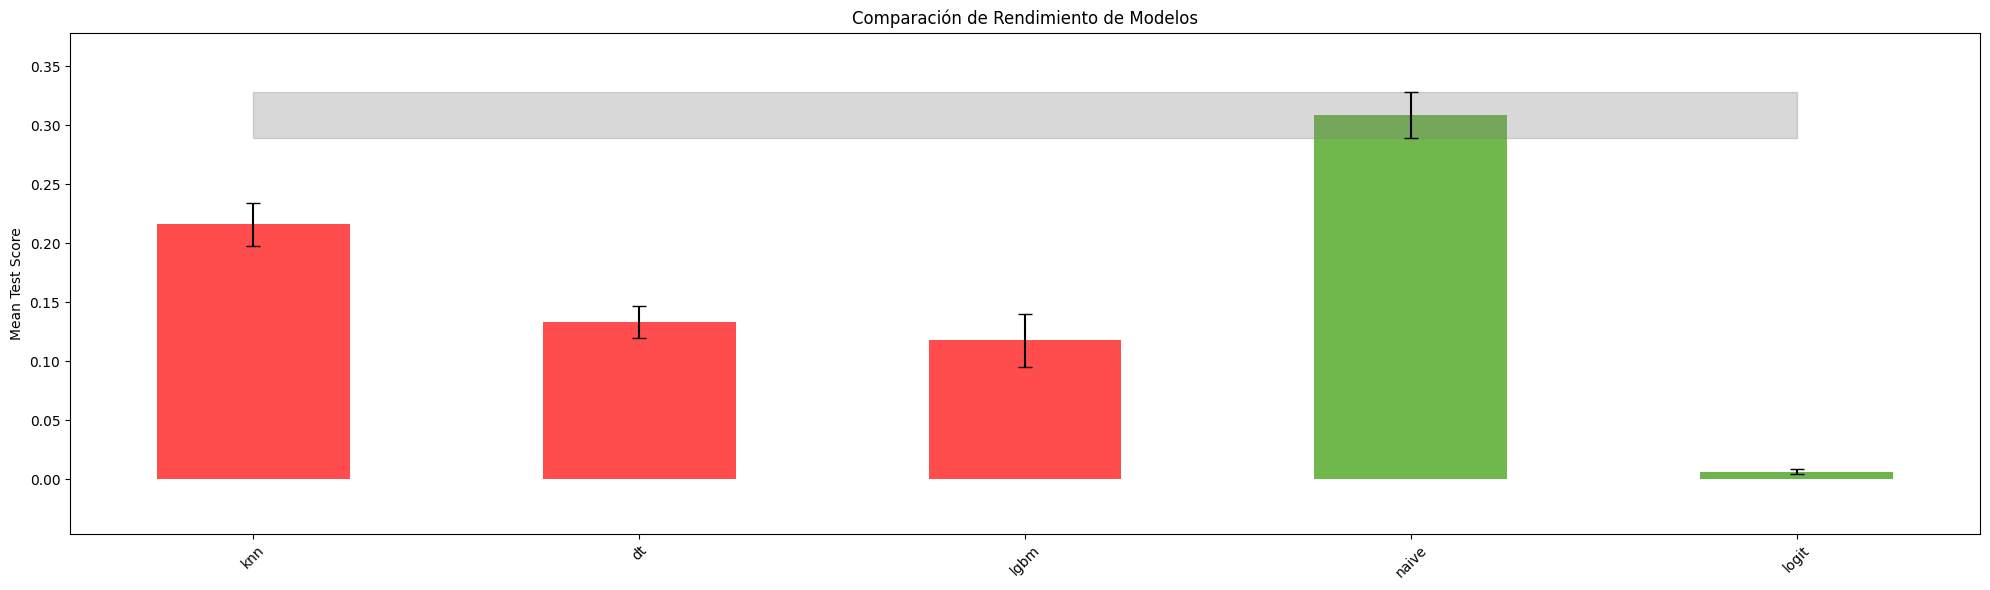

In [298]:
# Ordenar el DataFrame por el valor p creciente
results_df_sorted = results_df.sort_values(by='p_value')

# Crear el gráfico de barras
plt.figure(figsize=(20, 6))  # Ajustar el tamaño de la figura
bar_width = 0.5  # Ajuste del ancho de las barras

# Obtener todas las combinaciones únicas de 'model' (sin necesidad de 'source')
models = results_df_sorted['model']

# Inicializar posición base
x_pos = np.arange(len(models))  # Número total de barras

# Crear un colormap personalizado para los valores p (ajustado a tus indicaciones)
colors = LinearSegmentedColormap.from_list(
    "p_value_gradient", [(0, 'red'), (0.075, 'yellow'), (1, 'green')])

# Normalizar los valores p de acuerdo con el rango entre 0 y 1
norm = Normalize(vmin=0, vmax=1)

# Inicializar las variables para encontrar el máximo y mínimo
max_mean_test_score = -np.inf  # Para encontrar el mayor mean_test_score
interval_lower_test_max = None  # Para almacenar el intervalo inferior del máximo mean_test_score
interval_upper_test_max = None  # Para almacenar el intervalo superior del máximo mean_test_score
min_interval_lower_test = np.inf  # Para encontrar el menor intervalo inferior de test
max_interval_upper_test = -np.inf  # Para encontrar el mayor intervalo superior de test

# Graficar las métricas de test (mean_test_score y std_test_score)
for i, model in enumerate(models):
    # Filtrar los datos para el modelo actual
    filtered_df = results_df_sorted[results_df_sorted['model'] == model]
    
    # Obtener las métricas del modelo
    mean_test_score = filtered_df['mean_test_score'].values[0]
    test_std = filtered_df['std_test_score'].values[0] * 3  # Multiplicar la desviación estándar por 3
    p_value = filtered_df['p_value'].values[0]

    # Obtener los límites del intervalo de test
    interval_lower_test = filtered_df['interval_lower_test'].values[0]
    interval_upper_test = filtered_df['interval_upper_test'].values[0]
    
    # Actualizar el máximo y el mínimo mean_test_score, así como los límites del intervalo
    if mean_test_score > max_mean_test_score:
        max_mean_test_score = mean_test_score
        interval_lower_test_max = interval_lower_test
        interval_upper_test_max = interval_upper_test
    if interval_lower_test < min_interval_lower_test:
        min_interval_lower_test = interval_lower_test
    if interval_upper_test > max_interval_upper_test:
        max_interval_upper_test = interval_upper_test
    
    # Asignar el color basado en el valor p usando el colormap
    color = colors(norm(p_value))  # Aplicar normalización y obtener el color
    
    # Posicionar las barras
    plt.bar(x_pos[i], mean_test_score, yerr=test_std, capsize=5, 
            color=color, width=bar_width, alpha=0.7, label=f'{model}' if i == 0 else "")

# Asegurarse de que min_interval_lower_test tenga un valor válido
if min_interval_lower_test == np.inf:
    min_interval_lower_test = 0  # Si no se actualizó, asignar un valor mínimo válido

# Ajustar el límite inferior del eje Y
if min_interval_lower_test < 0:
    plt.ylim(0, 1.0)  # Si el mínimo intervalo inferior es menor que cero, establecer el límite inferior en 0
else:
    plt.ylim(min_interval_lower_test - 0.05, 1.0)   # Agregar un pequeño margen debajo del valor mínimo

# Ajustar el límite superior del eje Y
if max_interval_upper_test < 1:
    plt.ylim(plt.ylim()[0], max_interval_upper_test + 0.05)  # Si el máximo intervalo superior es menor que 1, ajustarlo
else:
    plt.ylim(plt.ylim()[0], 1.0)  # Dejarlo en 1 si es mayor o igual a 1

# Añadir la banda entre interval_lower_test_max y interval_upper_test_max
if interval_lower_test_max is not None and interval_upper_test_max is not None:
    plt.fill_between(
        [0, len(models) - 1],  # Todo el ancho del gráfico
        interval_lower_test_max, interval_upper_test_max,
        color='gray', alpha=0.3, label=f'Intervalo de Test (Max Mean Test Score: {max_mean_test_score:.2f})'
    )

# Añadir etiquetas y título
plt.title('Comparación de Rendimiento de Modelos')
plt.xticks(x_pos, models, rotation=45)
plt.ylabel('Mean Test Score')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Evaluo el desempeño de los modelos más prometedores

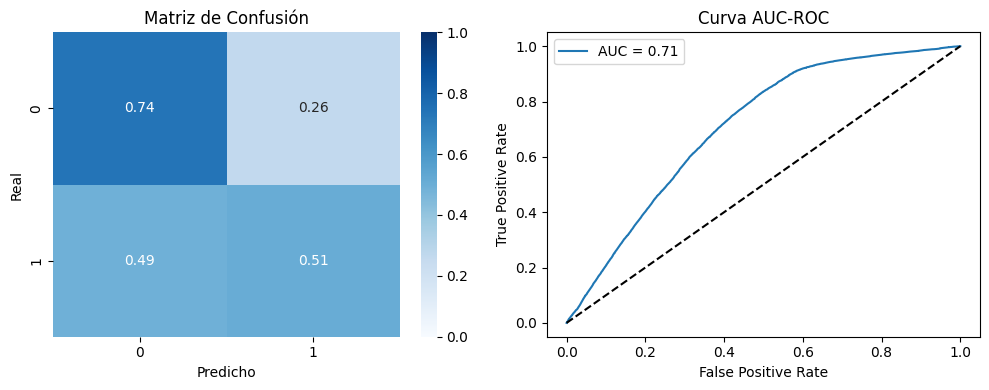

              precision    recall  f1-score   support

           0       0.86      0.74      0.79     70658
           1       0.33      0.51      0.40     17759

    accuracy                           0.69     88417
   macro avg       0.59      0.62      0.60     88417
weighted avg       0.75      0.69      0.71     88417



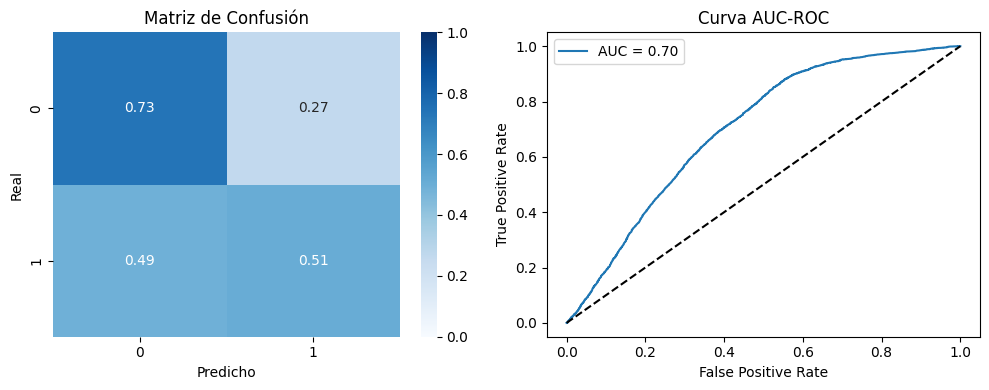

              precision    recall  f1-score   support

           0       0.85      0.73      0.79     17549
           1       0.33      0.51      0.40      4555

    accuracy                           0.69     22104
   macro avg       0.59      0.62      0.60     22104
weighted avg       0.74      0.69      0.71     22104



In [299]:
naive_best_params = trials_df1[trials_df1['model'] == 'naive']['params'].iloc[0]
naive_classifier = GaussianNB(**naive_best_params)
naive_classifier.fit(X_train_trees, y_train)

y_train_pred = naive_classifier.predict(X = X_train_trees)
y_test_pred = naive_classifier.predict(X_test_trees)
y_train_proba = naive_classifier.predict_proba(X_train_trees)[:, 1]
y_test_proba = naive_classifier.predict_proba(X_test_trees)[:, 1]

resultados(y_train, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

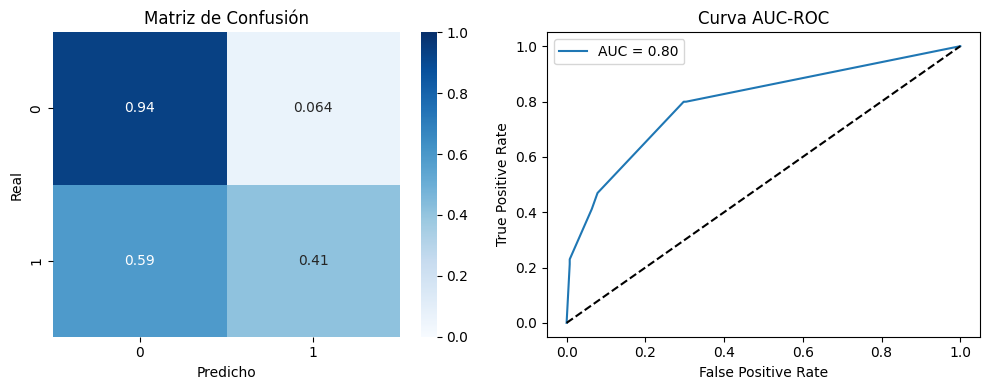

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     70658
           1       0.62      0.41      0.49     17759

    accuracy                           0.83     88417
   macro avg       0.74      0.67      0.70     88417
weighted avg       0.81      0.83      0.82     88417



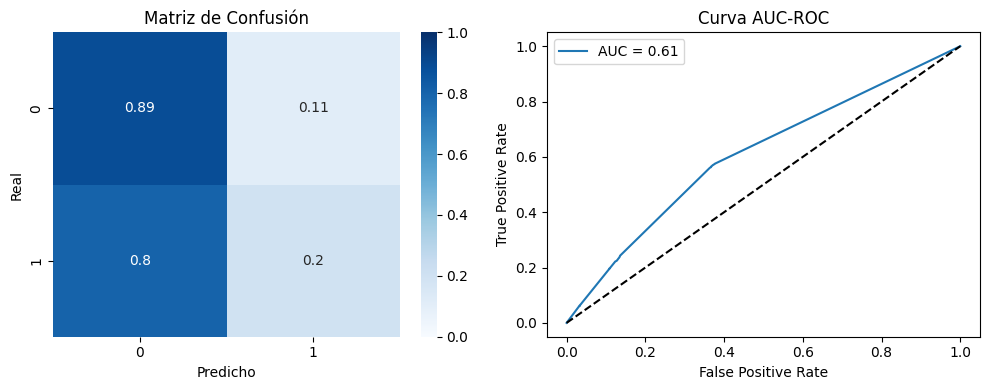

              precision    recall  f1-score   support

           0       0.81      0.89      0.85     17549
           1       0.32      0.20      0.24      4555

    accuracy                           0.75     22104
   macro avg       0.56      0.54      0.55     22104
weighted avg       0.71      0.75      0.72     22104



In [300]:
knn_best_params = trials_df1[trials_df1['model'] == 'knn']['params'].iloc[0]
knn_classifier = KNeighborsClassifier(**knn_best_params)
knn_classifier.fit(X_train_trees, y_train)

y_train_pred = knn_classifier.predict(X = X_train_trees)
y_test_pred = knn_classifier.predict(X_test_trees)
y_train_proba = knn_classifier.predict_proba(X_train_trees)[:, 1]
y_test_proba = knn_classifier.predict_proba(X_test_trees)[:, 1]

resultados(y_train, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

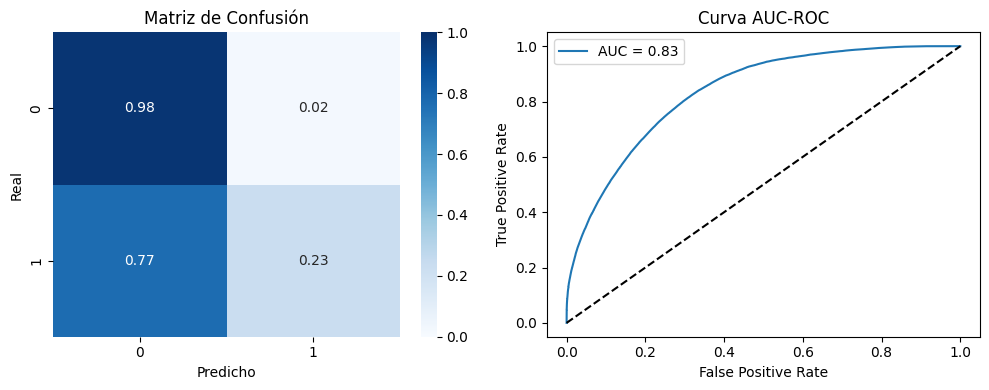

              precision    recall  f1-score   support

           0       0.84      0.98      0.90     70658
           1       0.75      0.23      0.35     17759

    accuracy                           0.83     88417
   macro avg       0.79      0.61      0.63     88417
weighted avg       0.82      0.83      0.79     88417



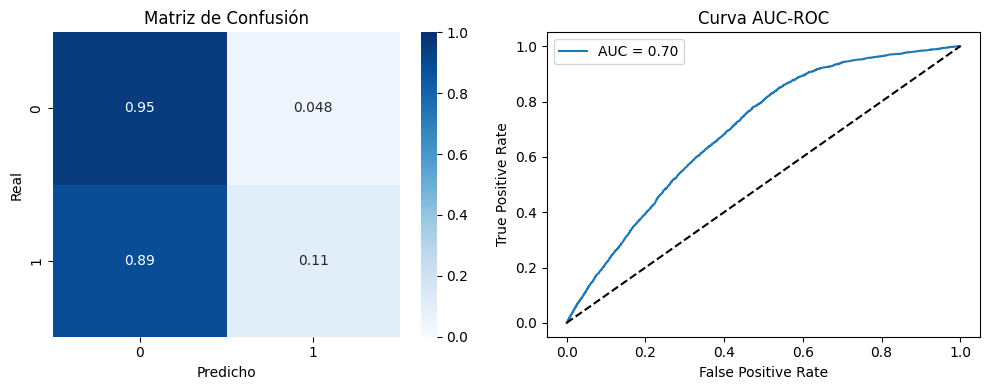

              precision    recall  f1-score   support

           0       0.80      0.95      0.87     17549
           1       0.38      0.11      0.17      4555

    accuracy                           0.78     22104
   macro avg       0.59      0.53      0.52     22104
weighted avg       0.72      0.78      0.73     22104



In [301]:
lgbm_best_params = trials_df1[trials_df1['model'] == 'lgbm']['params'].iloc[0]
lgbm_best_params["random_state"] = 42
lgbm_best_params["verbose"] = -1

lgbm_classifier = lgb.LGBMClassifier(**lgbm_best_params)
lgbm_classifier.fit(X_train_trees, y_train)

y_train_pred = lgbm_classifier.predict(X = X_train_trees)
y_test_pred = lgbm_classifier.predict(X_test_trees)
y_train_proba = lgbm_classifier.predict_proba(X_train_trees)[:, 1]
y_test_proba = lgbm_classifier.predict_proba(X_test_trees)[:, 1]

resultados(y_train, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

## Tratamiento de desbalanceo
##### Como los datos estan desbalanceados, es decir, como solo aproximadamente el 20% de los pacientes se ausentó para la mayoria de los modelos las metricas se optimizan si predecimos que todos los pacientes se presentarán

### Posibles soluciones
1- Se agrega el parametro "class_weight" = "balanced" al modelo lgb.LGBMClassifier
2- Se balancea el conjunto de datos y se vuelve a busccar los mejores parametros de cada modelo

#### 1- Modificar lgb.LGBMClassifier para que balance la clase objetivo automaticamente

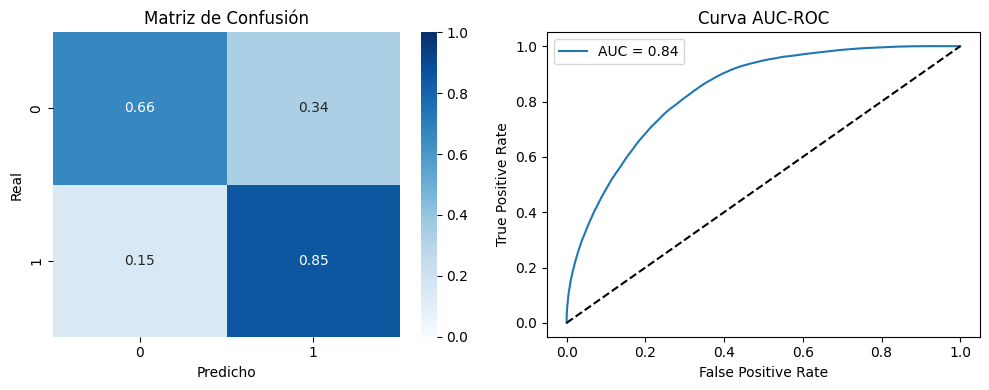

              precision    recall  f1-score   support

           0       0.95      0.66      0.78     70658
           1       0.39      0.85      0.53     17759

    accuracy                           0.70     88417
   macro avg       0.67      0.76      0.66     88417
weighted avg       0.83      0.70      0.73     88417



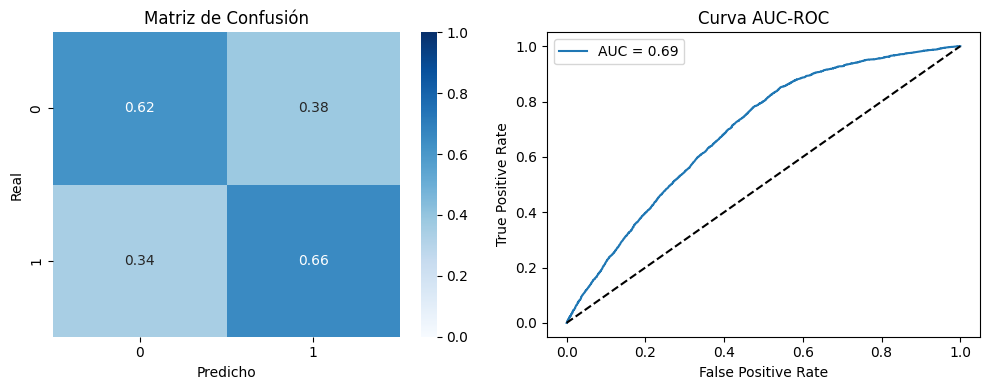

              precision    recall  f1-score   support

           0       0.87      0.62      0.73     17549
           1       0.31      0.66      0.42      4555

    accuracy                           0.63     22104
   macro avg       0.59      0.64      0.57     22104
weighted avg       0.76      0.63      0.66     22104



In [302]:
lgbm_best_params["class_weight"] = "balanced"

lgbm_classifier = lgb.LGBMClassifier(**lgbm_best_params)
lgbm_classifier.fit(X_train_trees, y_train)

y_train_pred = lgbm_classifier.predict(X = X_train_trees)
y_test_pred = lgbm_classifier.predict(X_test_trees)
y_train_proba = lgbm_classifier.predict_proba(X_train_trees)[:, 1]
y_test_proba = lgbm_classifier.predict_proba(X_test_trees)[:, 1]

resultados(y_train, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

#### 2- Crear distintos conjuntos de datos balanceados 
En este caso dada la cantidad de observaciones se opta por remover observaciones de pacientes que asistieron a su consulta

In [303]:
from imblearn.datasets import fetch_datasets
from imblearn.pipeline import make_pipeline

from imblearn.under_sampling import (
    RandomUnderSampler,
    CondensedNearestNeighbour,
    TomekLinks,
    OneSidedSelection,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    NeighbourhoodCleaningRule,
    NearMiss,
    InstanceHardnessThreshold
)

In [304]:
undersampler_dict = {
    'random': RandomUnderSampler(
        sampling_strategy='auto',
        random_state=0,
        replacement=False),

    'tomek': TomekLinks(
        sampling_strategy='auto',
        n_jobs=1),

    'oss': OneSidedSelection(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=1),

    'nm1': NearMiss(
        sampling_strategy='auto',
        version=1,
        n_neighbors=3,
        n_jobs=1),

    # Los dos siguientes metodos generan MemoryError: Unable to allocate 9.35 GiB for an array with shape (70658, 17759) and data type int64
    
    # 'nm2': NearMiss(
    #     sampling_strategy='auto',
    #     version=2,
    #     n_neighbors=3,
    #     n_jobs=1),

    # 'enn': EditedNearestNeighbours(
    #     sampling_strategy='auto',
    #     n_neighbors=3,
    #     kind_sel='all',
    #     n_jobs=1),


    # Los siguientes metodos son muy pesados para esta notebook
    
    # 'cnn': CondensedNearestNeighbour(
    #     sampling_strategy='auto',
    #     random_state=0,
    #     n_neighbors=1,
    #     n_jobs=1),

    # 'allknn': AllKNN(
    #     sampling_strategy='auto',
    #     n_neighbors=5,
    #     kind_sel='all',
    #     n_jobs=1),

    # 'renn': RepeatedEditedNearestNeighbours(
    #     sampling_strategy='auto',
    #     n_neighbors=3,
    #     kind_sel='all',
    #     n_jobs=1,
    #     max_iter=100),

    # 'ncr': NeighbourhoodCleaningRule(
    #     sampling_strategy='auto',
    #     n_neighbors=3,
    #     kind_sel='all',
    #     n_jobs=1,
    #     threshold_cleaning=0.5),

    # 'iht': InstanceHardnessThreshold(
    #     estimator=RandomForestClassifier(
    #         n_estimators=100, random_state=39, max_depth=3, n_jobs=1,
    #     ),
    #     sampling_strategy='auto',
    #     random_state=0,
    #     n_jobs=1,
    #     cv=3)
}

#### Hago que y_train vuelva a ser un dataframe

In [305]:
y_train_df = pd.DataFrame(y_train, index=X_train_trees.index)

In [306]:
all(y_train_df.index == X_train_trees.index)

True

In [307]:
y_train_df.head(3)

No-show
64200        0
91954        0
11678        0

### Crear un diccionario para almacenar el modelo y los índices remuestreados

In [308]:
# Directorio donde se guardarán los archivos de índices remuestreados
directory = "../Medical Appointment No Show/Resampling Indexes/"

# Crear el diccionario para almacenar los datos remuestreados
resampled_data = {}

# Iterar sobre los undersamplers y realizar el remuestreo
for name, undersampler in undersampler_dict.items():
    print(f"\nProcesando: {name}")

    # Definir los nombres de los archivos CSV para los índices de X y y con la ruta completa
    X_resampled_indices_csv = os.path.join(directory, f'X_train_indices_{name}.csv')
    y_resampled_indices_csv = os.path.join(directory, f'y_train_indices_{name}.csv')
    
    # Verificar si ambos archivos ya existen en el directorio
    if os.path.exists(X_resampled_indices_csv) and os.path.exists(y_resampled_indices_csv):
        print(f"Archivos {X_resampled_indices_csv} y {y_resampled_indices_csv} ya existen. Saltando remuestreo.")
        
        # Cargar los índices desde los archivos y almacenarlos en el diccionario
        X_indices_df = pd.read_csv(X_resampled_indices_csv, header=None, index_col=0)
        y_indices_df = pd.read_csv(y_resampled_indices_csv, header=None, index_col=0)
        
        resampled_data[name] = {
            'model': undersampler,
            'X_indices': X_indices_df.index,  # Convertir el índice de X a Series o DataFrame
            'y_indices': y_indices_df.index   # Convertir el índice de y a Series o DataFrame
        }
        
        continue  # Saltar a la siguiente iteración si los archivos ya existen

    # Realizar el remuestreo
    print("Realizando remuestreo...")
    X_resampled, y_resampled = undersampler.fit_resample(X_train_trees, y_train_df)

    # Obtener los índices originales de los datos que fueron remuestreados
    if hasattr(undersampler, 'sample_indices_'):
        # Si el undersampler tiene 'sample_indices_' (como en el caso de TomekLinks)
        X_resampled_indices = X_train_trees.index[undersampler.sample_indices_]
        y_resampled_indices = y_train_df.index[undersampler.sample_indices_]
    else:
        # En otros casos, simplemente usamos los índices de X_resampled y y_resampled
        X_resampled_indices = X_resampled.index
        y_resampled_indices = y_resampled.index

    # Guardar los índices remuestreados en el diccionario
    resampled_data[name] = {
        'model': undersampler,
        'X_indices': X_resampled_indices,
        'y_indices': y_resampled_indices
    }

    # Mostrar la distribución de clases
    original_class_distribution = dict(zip(*np.unique(y_train_df, return_counts=True)))
    resampled_class_distribution = dict(zip(*np.unique(y_resampled, return_counts=True)))
    print(f"Distribución de clases original para {name}: {original_class_distribution}")
    print(f"Distribución de clases después del remuestreo para {name}: {resampled_class_distribution}")

    # Guardar los índices en archivos CSV con index=True para conservar los índices originales
    X_resampled_indices_df = pd.DataFrame(index=X_resampled_indices)
    X_resampled_indices_df.to_csv(X_resampled_indices_csv, index=True, header=False)

    y_resampled_indices_df = pd.DataFrame(index=y_resampled_indices)
    y_resampled_indices_df.to_csv(y_resampled_indices_csv, index=True, header=False)

    print(f"Índices de X_train guardados en: {X_resampled_indices_csv}")
    print(f"Índices de y_train guardados en: {y_resampled_indices_csv}")
    print("-" * 50)



Procesando: random
Archivos ../Medical Appointment No Show/Resampling Indexes/X_train_indices_random.csv y ../Medical Appointment No Show/Resampling Indexes/y_train_indices_random.csv ya existen. Saltando remuestreo.

Procesando: tomek
Archivos ../Medical Appointment No Show/Resampling Indexes/X_train_indices_tomek.csv y ../Medical Appointment No Show/Resampling Indexes/y_train_indices_tomek.csv ya existen. Saltando remuestreo.

Procesando: oss
Archivos ../Medical Appointment No Show/Resampling Indexes/X_train_indices_oss.csv y ../Medical Appointment No Show/Resampling Indexes/y_train_indices_oss.csv ya existen. Saltando remuestreo.

Procesando: nm1
Archivos ../Medical Appointment No Show/Resampling Indexes/X_train_indices_nm1.csv y ../Medical Appointment No Show/Resampling Indexes/y_train_indices_nm1.csv ya existen. Saltando remuestreo.


#### Crear un diccionario para almacenar los índices remuestreados

In [309]:
resampled_data = {}

In [310]:
# Lista de los métodos de undersampling para los que has guardado archivos
methods = ['random', 'tomek', 'oss', 'nm1']

# Definir el directorio donde se encuentran los archivos CSV
directory = "../Medical Appointment No Show/Resampling Indexes/"

for method in methods:
    # Construir las rutas completas de los archivos CSV para X y y (de índices)
    X_indices_csv = os.path.join(directory, f'X_train_indices_{method}.csv')
    y_indices_csv = os.path.join(directory, f'y_train_indices_{method}.csv')
    
    # Leer los archivos CSV correspondientes para X y y (de índices)
    X_indices_df = pd.read_csv(X_indices_csv, header=None, index_col=0)
    y_indices_df = pd.read_csv(y_indices_csv, header=None, index_col=0)
    
    # Guardar los índices en el diccionario en formato lista
    resampled_data[method] = {
        'X_indices': X_indices_df.index.tolist(),  # Convertir el índice de X a lista
        'y_indices': y_indices_df.index.tolist()   # Convertir el índice de y a lista
    }
    
    print(f'Índices cargados para el método: {method}')

Índices cargados para el método: random
Índices cargados para el método: tomek
Índices cargados para el método: oss
Índices cargados para el método: nm1


#### Verifico que indices remuestreados sean compatibles

In [311]:
resampled_data['random']['y_indices'] == resampled_data['random']['X_indices']

True

### Verifico la cantidad de filas que cada modelo logró reducir

In [312]:
print(f'Cantidad inicial de filas {len(X_train)}')

# Contar y mostrar el número de filas remuestreadas para cada modelo en resampled_data
for method, data in resampled_data.items():
    num_rows_X = len(data['X_indices'])  # Número de índices en X remuestreados
    num_rows_y = len(data['y_indices'])  # Número de índices en y remuestreados
    
    print(f"Modelo '{method}':")
    print(f"  Número de filas en X_train remuestreadas: {num_rows_X}")
    print(f"  Número de filas en y_train remuestreadas: {num_rows_y}")
    print("-" * 50)

Cantidad inicial de filas 88417
Modelo 'random':
  Número de filas en X_train remuestreadas: 35518
  Número de filas en y_train remuestreadas: 35518
--------------------------------------------------
Modelo 'tomek':
  Número de filas en X_train remuestreadas: 88070
  Número de filas en y_train remuestreadas: 88070
--------------------------------------------------
Modelo 'oss':
  Número de filas en X_train remuestreadas: 88127
  Número de filas en y_train remuestreadas: 88127
--------------------------------------------------
Modelo 'nm1':
  Número de filas en X_train remuestreadas: 35518
  Número de filas en y_train remuestreadas: 35518
--------------------------------------------------


##### Dado que 'tomek' y 'oss' casi no disminuyen el tamaño del conjunto de datos de entrenara con los datos de 'random' y 'nm1'

#### Acceder a los datos remuestreados usando los índices de resampled_data

In [313]:
X_random = X_train_trees.loc[resampled_data['random']['X_indices']]
y_random = y_train_df.loc[resampled_data['random']['y_indices']]

In [314]:
y_random_flatten = y_random.values.ravel()

In [315]:
X_random.shape, y_random_flatten.shape

((35518, 39), (35518,))

In [316]:
y_random_flatten.sum()

17759

In [317]:
X_nm1 = X_train_trees.loc[resampled_data['nm1']['X_indices']]
y_nm1 = y_train_df.loc[resampled_data['nm1']['y_indices']]

In [318]:
y_nm1 = y_nm1.values.ravel()

### Analizo el desempeño de los nuevos conjuntos

#### KNeighborsClassifier

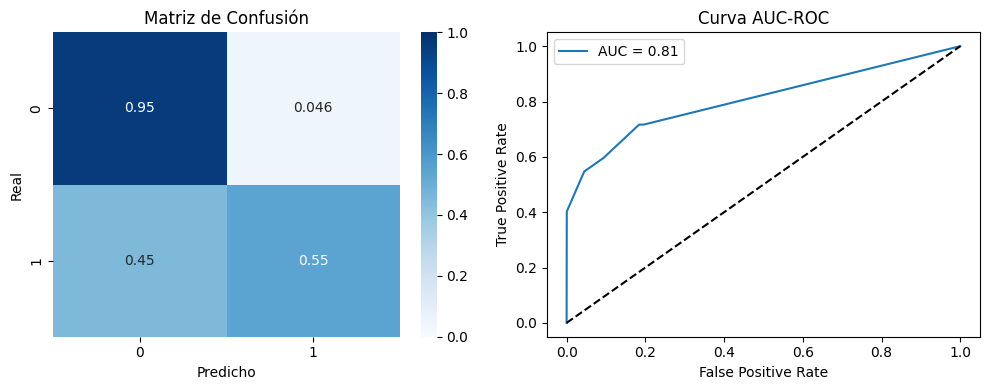

              precision    recall  f1-score   support

           0       0.68      0.95      0.79     17759
           1       0.92      0.55      0.69     17759

    accuracy                           0.75     35518
   macro avg       0.80      0.75      0.74     35518
weighted avg       0.80      0.75      0.74     35518



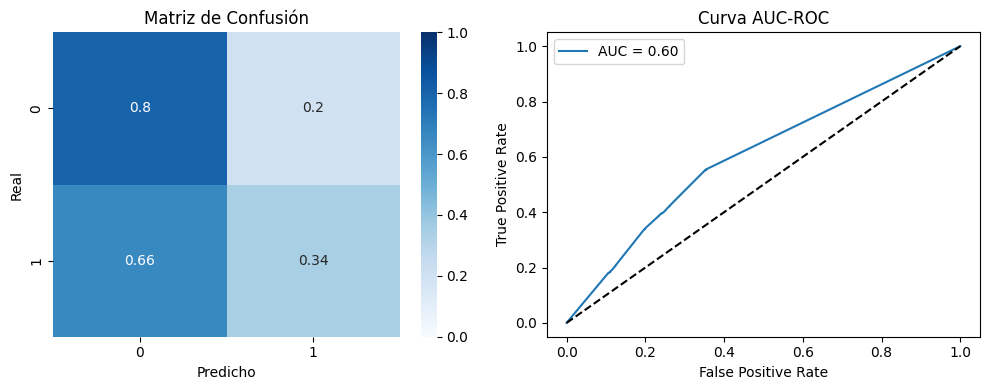

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     17549
           1       0.31      0.34      0.32      4555

    accuracy                           0.71     22104
   macro avg       0.57      0.57      0.57     22104
weighted avg       0.72      0.71      0.71     22104



In [319]:
random_knn_classifier = KNeighborsClassifier(**knn_best_params)
random_knn_classifier.fit(X_random, y_random_flatten)

y_train_pred = random_knn_classifier.predict(X = X_random)
y_test_pred = random_knn_classifier.predict(X = X_test_trees)
y_train_proba = random_knn_classifier.predict_proba(X = X_random)[:, 1]
y_test_proba = random_knn_classifier.predict_proba(X = X_test_trees)[:, 1]

resultados(y_random_flatten, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

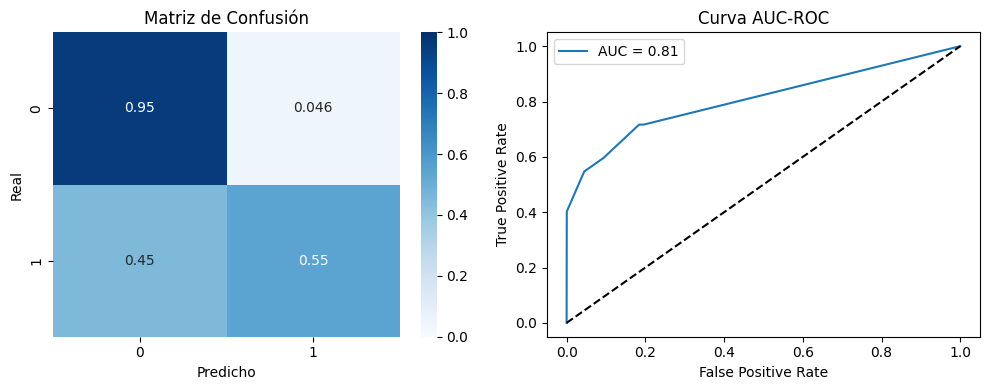

              precision    recall  f1-score   support

           0       0.68      0.95      0.79     17759
           1       0.92      0.55      0.69     17759

    accuracy                           0.75     35518
   macro avg       0.80      0.75      0.74     35518
weighted avg       0.80      0.75      0.74     35518



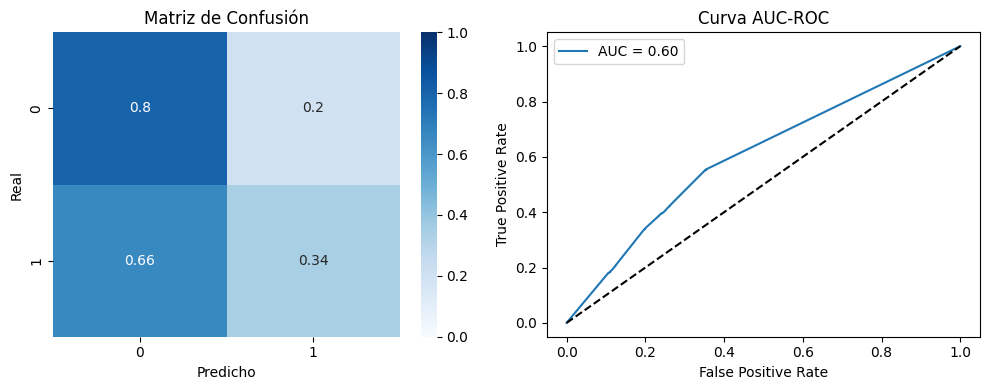

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     17549
           1       0.31      0.34      0.32      4555

    accuracy                           0.71     22104
   macro avg       0.57      0.57      0.57     22104
weighted avg       0.72      0.71      0.71     22104



In [320]:
nm1_knn_classifier = KNeighborsClassifier(**knn_best_params)
nm1_knn_classifier.fit(X_random, y_random_flatten)

y_train_pred = nm1_knn_classifier.predict(X = X_random)
y_test_pred = nm1_knn_classifier.predict(X_test_trees)
y_train_proba = nm1_knn_classifier.predict_proba(X_random)[:, 1]
y_test_proba = nm1_knn_classifier.predict_proba(X_test_trees)[:, 1]

resultados(y_random_flatten, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

#### GaussianNB

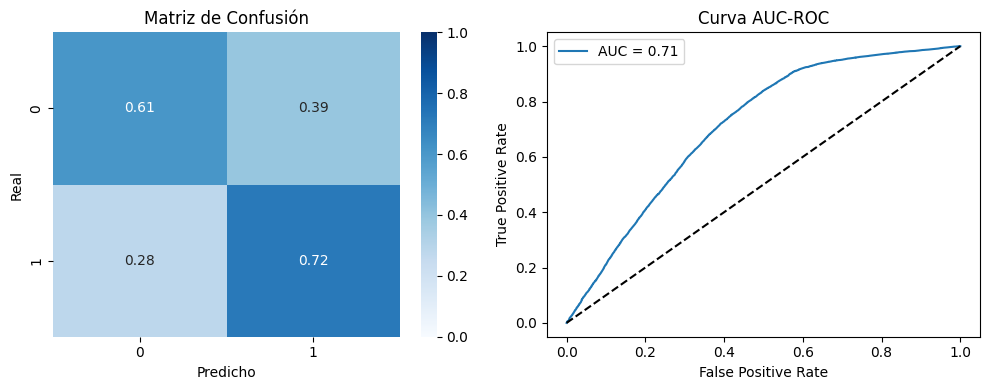

              precision    recall  f1-score   support

           0       0.68      0.61      0.64     17759
           1       0.65      0.72      0.68     17759

    accuracy                           0.66     35518
   macro avg       0.67      0.66      0.66     35518
weighted avg       0.67      0.66      0.66     35518



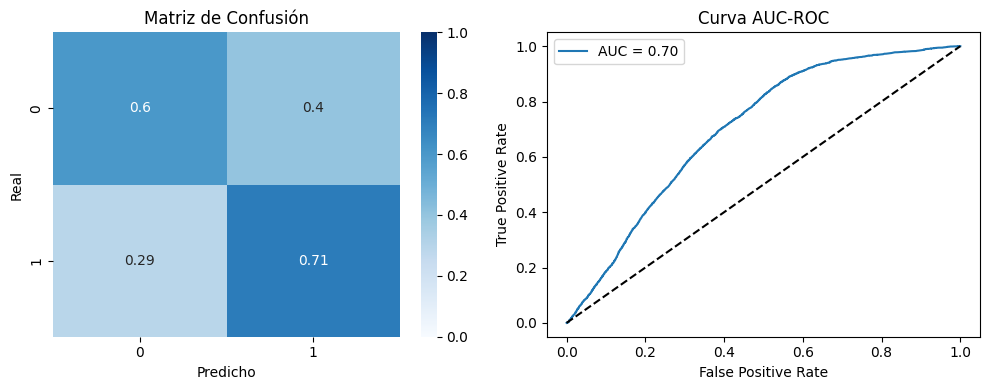

              precision    recall  f1-score   support

           0       0.89      0.60      0.72     17549
           1       0.31      0.71      0.44      4555

    accuracy                           0.62     22104
   macro avg       0.60      0.65      0.58     22104
weighted avg       0.77      0.62      0.66     22104



In [321]:
random_naive_classifier = GaussianNB(**naive_best_params)
random_naive_classifier.fit(X_random, y_random_flatten)

y_train_pred = random_naive_classifier.predict(X = X_random)
y_test_pred = random_naive_classifier.predict(X_test_trees)
y_train_proba = random_naive_classifier.predict_proba(X_random)[:, 1]
y_test_proba = random_naive_classifier.predict_proba(X_test_trees)[:, 1]
resultados(y_random_flatten, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

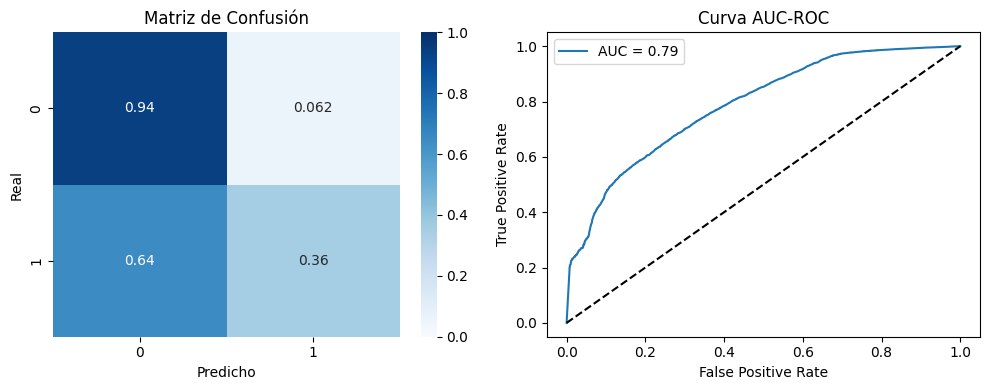

              precision    recall  f1-score   support

           0       0.59      0.94      0.73     17759
           1       0.85      0.36      0.50     17759

    accuracy                           0.65     35518
   macro avg       0.72      0.65      0.61     35518
weighted avg       0.72      0.65      0.61     35518



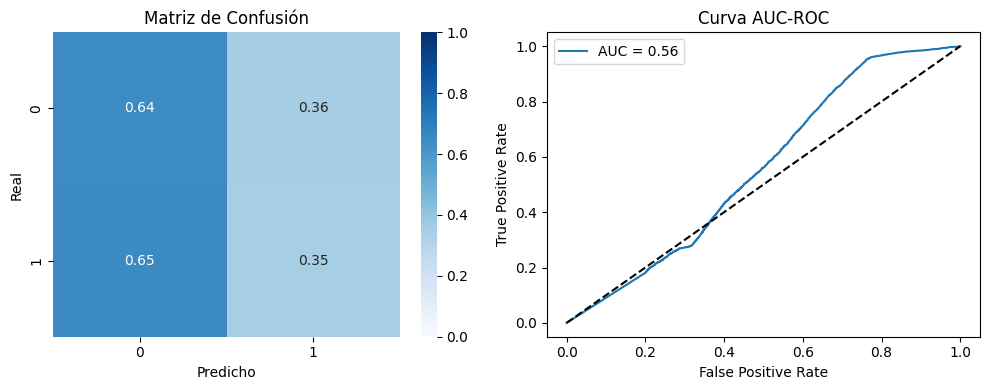

              precision    recall  f1-score   support

           0       0.79      0.64      0.71     17549
           1       0.20      0.35      0.26      4555

    accuracy                           0.58     22104
   macro avg       0.50      0.50      0.48     22104
weighted avg       0.67      0.58      0.62     22104



In [322]:
nm1_naive_classifier = GaussianNB(**naive_best_params)
nm1_naive_classifier.fit(X_nm1, y_nm1)

y_train_pred = nm1_naive_classifier.predict(X = X_nm1)
y_test_pred = nm1_naive_classifier.predict(X_test_trees)
y_train_proba = nm1_naive_classifier.predict_proba(X_nm1)[:, 1]
y_test_proba = nm1_naive_classifier.predict_proba(X_test_trees)[:, 1]
resultados(y_nm1, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

#### LGBMClassifier

In [323]:
lgbm_best_params["class_weight"] = None

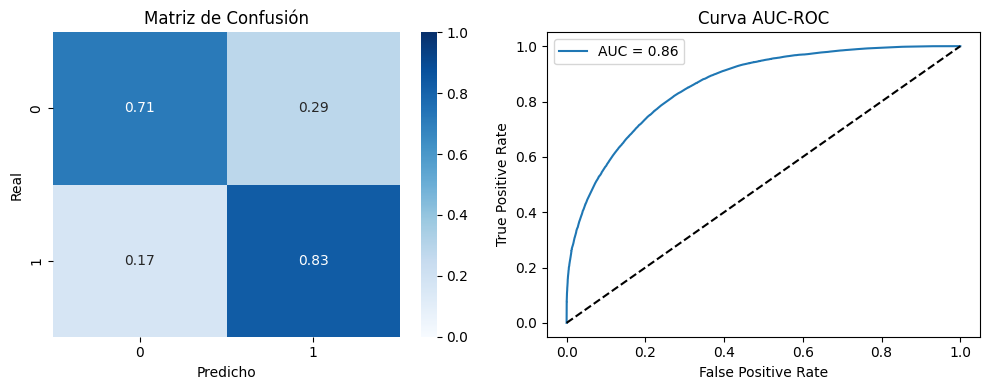

              precision    recall  f1-score   support

           0       0.81      0.71      0.76     17759
           1       0.74      0.83      0.79     17759

    accuracy                           0.77     35518
   macro avg       0.78      0.77      0.77     35518
weighted avg       0.78      0.77      0.77     35518



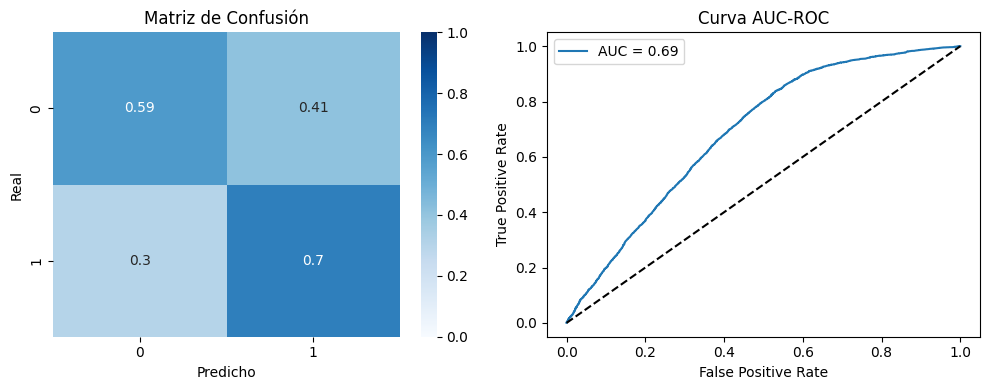

              precision    recall  f1-score   support

           0       0.88      0.59      0.70     17549
           1       0.30      0.70      0.42      4555

    accuracy                           0.61     22104
   macro avg       0.59      0.64      0.56     22104
weighted avg       0.76      0.61      0.65     22104



In [324]:
random_lgbm_classifier = lgb.LGBMClassifier(**lgbm_best_params)
random_lgbm_classifier.fit(X_random, y_random_flatten)
y_train_pred = random_lgbm_classifier.predict(X = X_random)
y_test_pred = random_lgbm_classifier.predict(X_test_trees)
y_train_proba = random_lgbm_classifier.predict_proba(X_random)[:, 1]
y_test_proba = random_lgbm_classifier.predict_proba(X_test_trees)[:, 1]
resultados(y_random_flatten, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

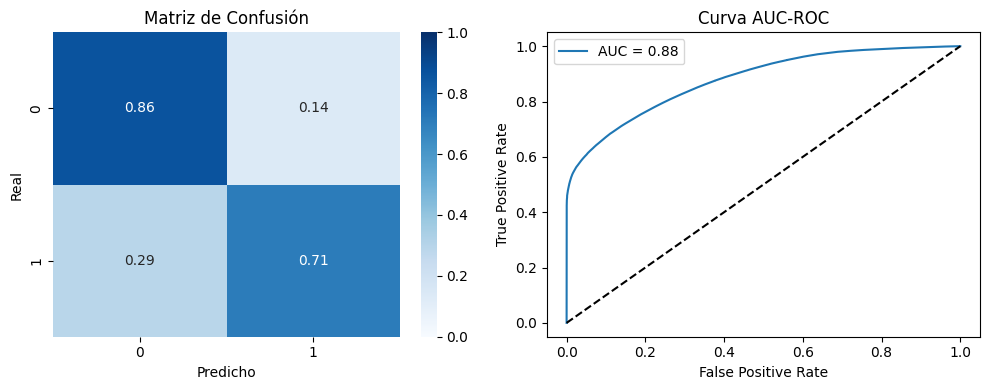

              precision    recall  f1-score   support

           0       0.75      0.86      0.80     17759
           1       0.84      0.71      0.77     17759

    accuracy                           0.79     35518
   macro avg       0.79      0.79      0.78     35518
weighted avg       0.79      0.79      0.78     35518



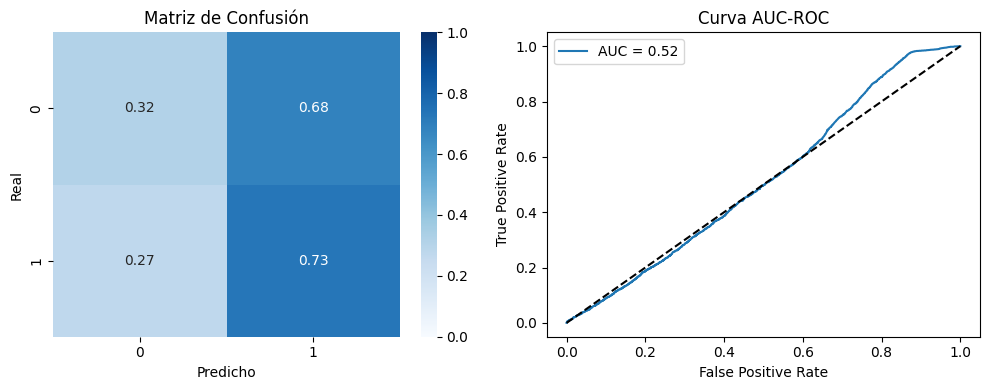

              precision    recall  f1-score   support

           0       0.82      0.32      0.46     17549
           1       0.22      0.73      0.33      4555

    accuracy                           0.40     22104
   macro avg       0.52      0.52      0.40     22104
weighted avg       0.69      0.40      0.43     22104



In [325]:
nm1_lgbm_classifier = lgb.LGBMClassifier(**lgbm_best_params)
nm1_lgbm_classifier.fit(X_nm1, y_nm1)
y_train_pred = nm1_lgbm_classifier.predict(X = X_nm1)
y_test_pred = nm1_lgbm_classifier.predict(X_test_trees)
y_train_proba = nm1_lgbm_classifier.predict_proba(X_nm1)[:, 1]
y_test_proba = nm1_lgbm_classifier.predict_proba(X_test_trees)[:, 1]
resultados(y_nm1, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

## Feature selection
Buscamos eliminar la mayor cantidad posible de caracteristicas sin que disminuir el poder predictivo del modelo o incluso mejorarlo.

Como GaussianNB no tiene un método coef_ o feature_importances_ no se puede utilizar RFE, hay que utilizar algun metodo agnostico como mutual information

In [326]:
from sklearn.feature_selection import mutual_info_classif

Text(0, 0.5, 'Mutual Information')

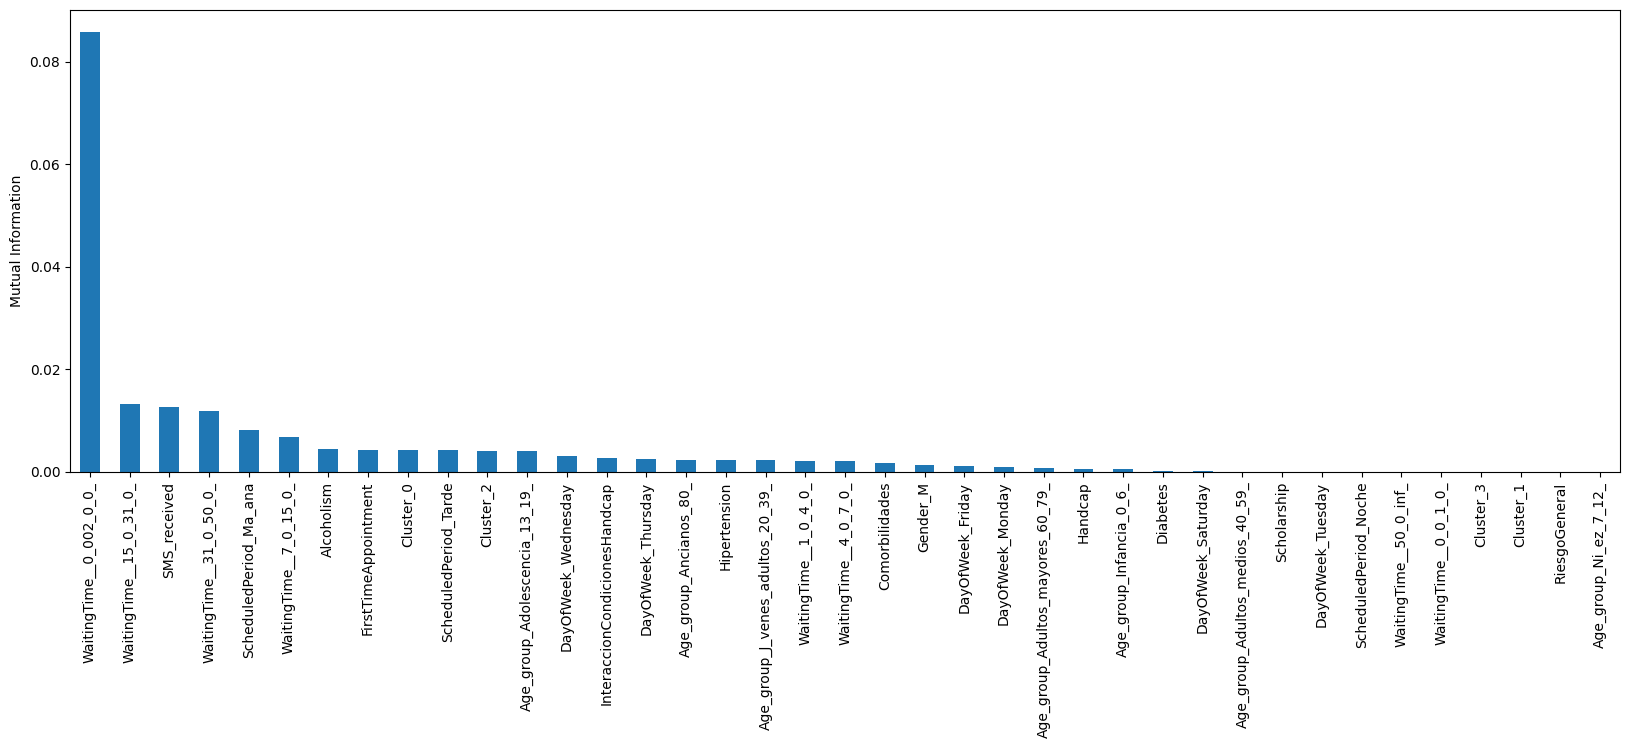

In [327]:
# the smaller the value of the mi, the less information we can infer from the feature about the target
mi = mutual_info_classif(
    X = X_random, 
    y = y_random_flatten,
    discrete_features = False, 
    n_neighbors=3,
    random_state=3,
)

# 1) let's capture the above array in a pandas series
# 2)add the variable names in the index
# 3) sort the features based on their mutual information value
# 4) and make a var plot

mi = pd.Series(mi)
mi.index = X_random.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

In [328]:
mi.sort_values(ascending=True)

Scholarship                         0.000000
Age_group_Adultos_medios_40_59_     0.000000
DayOfWeek_Tuesday                   0.000000
ScheduledPeriod_Noche               0.000000
WaitingTime__50_0_inf_              0.000000
WaitingTime__0_0_1_0_               0.000000
Cluster_3                           0.000000
Cluster_1                           0.000000
RiesgoGeneral                       0.000000
Age_group_Ni_ez_7_12_               0.000000
DayOfWeek_Saturday                  0.000101
Diabetes                            0.000134
Age_group_Infancia_0_6_             0.000511
Handcap                             0.000565
Age_group_Adultos_mayores_60_79_    0.000668
DayOfWeek_Monday                    0.000882
DayOfWeek_Friday                    0.001036
Gender_M                            0.001294
Comorbilidades                      0.001632
WaitingTime__4_0_7_0_               0.002158
WaitingTime__1_0_4_0_               0.002159
Age_group_J_venes_adultos_20_39_    0.002276
Hipertensi

In [329]:
X_random_filtered = X_random.copy()
X_test_trees_filtered = X_test_trees.copy()

In [330]:
# Definir la tolerancia
tolerancia = 0.001

# Filtrar las variables cuyos valores sean menores a la tolerancia
variables_bajo_tolerancia = mi[mi < tolerancia].index.tolist()

# Mostrar las variables
print(f"Hay {len(variables_bajo_tolerancia)} con menor tolerancia que {tolerancia}")
print(variables_bajo_tolerancia)

Hay 16 con menor tolerancia que 0.001
['Scholarship', 'Diabetes', 'Handcap', 'RiesgoGeneral', 'Cluster_1', 'Cluster_3', 'WaitingTime__0_0_1_0_', 'WaitingTime__50_0_inf_', 'ScheduledPeriod_Noche', 'DayOfWeek_Monday', 'DayOfWeek_Saturday', 'DayOfWeek_Tuesday', 'Age_group_Adultos_mayores_60_79_', 'Age_group_Adultos_medios_40_59_', 'Age_group_Infancia_0_6_', 'Age_group_Ni_ez_7_12_']


In [331]:
feature_selection = DropFeatures(features_to_drop = variables_bajo_tolerancia)
X_random_filtered = feature_selection.fit_transform(X_random_filtered)
X_test_trees_filtered = feature_selection.transform(X_test_trees_filtered)

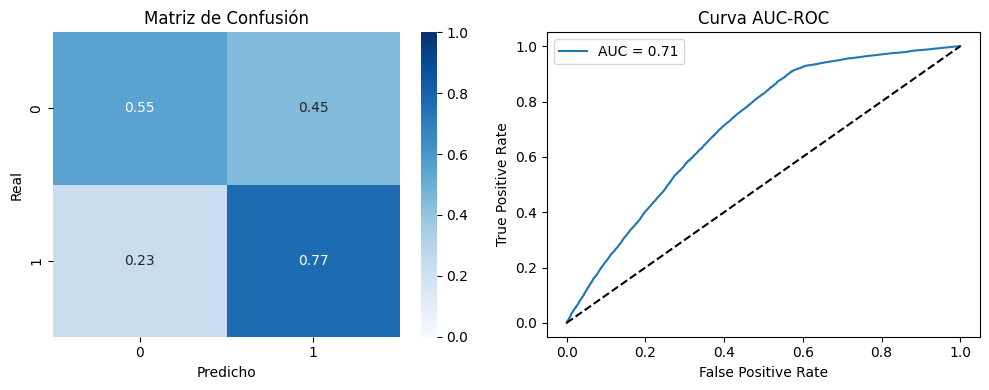

              precision    recall  f1-score   support

           0       0.71      0.55      0.62     17759
           1       0.63      0.77      0.69     17759

    accuracy                           0.66     35518
   macro avg       0.67      0.66      0.66     35518
weighted avg       0.67      0.66      0.66     35518



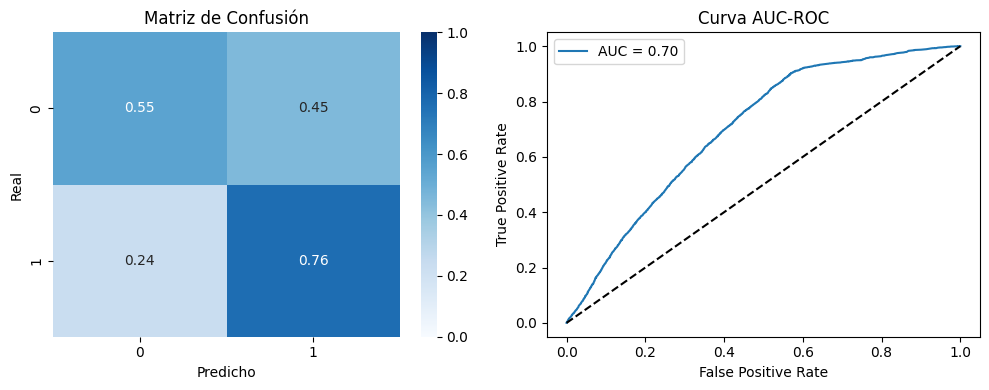

              precision    recall  f1-score   support

           0       0.90      0.55      0.68     17549
           1       0.31      0.76      0.44      4555

    accuracy                           0.59     22104
   macro avg       0.60      0.66      0.56     22104
weighted avg       0.78      0.59      0.63     22104



In [332]:
random_naive_classifier = GaussianNB(**naive_best_params)
random_naive_classifier.fit(X_random_filtered, y_random_flatten)

y_train_pred = random_naive_classifier.predict(X = X_random_filtered)
y_test_pred = random_naive_classifier.predict(X_test_trees_filtered)
y_train_proba = random_naive_classifier.predict_proba(X_random_filtered)[:, 1]
y_test_proba = random_naive_classifier.predict_proba(X_test_trees_filtered)[:, 1]
resultados(y_random_flatten, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

De las 39 caracteristicas se pueden remover 16 mejorarndo tambien el desempeño del modelo para detetectar las inasistencias pero aumentando en la misma relación las falsas alarmas

## Modelo final

El modelo que tiene mejor desempeño para detectar las inasistencias es GaussianNB con los parametros de naive_best_params entrenado con el conjunto de entrenamiento con remuestreo aleatorio.

### Desempeño del modelo final

In [333]:
def resultados_clasificacion_cv(model, X, y, cv=5, include_auc_roc=False):
    """
    Esta función evalúa el rendimiento de un modelo de clasificación bivariada utilizando
    varias métricas: accuracy, precision, recall, f1-score, FPR y opcionalmente auc-roc, con 
    validación cruzada (CV). Devuelve un DataFrame con los resultados de las métricas, 
    sus medias, desviaciones estándar y los intervalos de confianza al 95%.
    
    Parámetros:
    - model: el modelo de clasificación a evaluar.
    - X: array-like, características del modelo (conjunto de entrenamiento).
    - y: array-like, valores verdaderos de las etiquetas (valores reales).
    - cv: número de pliegues para la validación cruzada (default es 5).
    - include_auc_roc: booleano, si se debe incluir la métrica AUC-ROC (default es False).
    
    Retorna:
    - df_resultados: DataFrame con las métricas y sus estadísticas.
    """
    
    # Asegurarse de que y sea un pandas Series con el mismo índice que X
    if isinstance(y, np.ndarray):
        y = pd.Series(y, index=X.index)  # Convertir y a pandas Series si es un array
    
    # Inicializar el objeto KFold para cross-validation
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Listas para almacenar los resultados de cada pliegue
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    fpr_scores = []  # Nueva lista para almacenar la tasa de falsas alarmas (FPR)
    auc_roc_scores = []  # Solo se agregará si include_auc_roc es True
    
    for train_idx, test_idx in kf.split(X):
        # Usar .iloc para indexar correctamente las filas
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Predecir con el modelo
        y_pred = model.predict(X_test)
        
        # Calcular las métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Calcular el False Positive Rate (FPR)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # Evitar división por cero
        
        # AUC-ROC solo si se solicita
        if include_auc_roc:
            auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])  # Suponiendo clasificación binaria
            auc_roc_scores.append(auc_roc)
        
        # Guardar las métricas de este pliegue
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        fpr_scores.append(fpr)  # Agregar el FPR
        
    # Calcular las medias y desviaciones estándar
    accuracy_mean = np.mean(accuracy_scores)
    accuracy_std = np.std(accuracy_scores)
    precision_mean = np.mean(precision_scores)
    precision_std = np.std(precision_scores)
    recall_mean = np.mean(recall_scores)
    recall_std = np.std(recall_scores)
    f1_mean = np.mean(f1_scores)
    f1_std = np.std(f1_scores)
    fpr_mean = np.mean(fpr_scores)
    fpr_std = np.std(fpr_scores)
    
    # Calcular intervalos de confianza al 95% (usando una distribución t-student)
    ci_accuracy = stats.t.interval(0.95, len(accuracy_scores)-1, loc=accuracy_mean, scale=accuracy_std/np.sqrt(len(accuracy_scores)))
    ci_precision = stats.t.interval(0.95, len(precision_scores)-1, loc=precision_mean, scale=precision_std/np.sqrt(len(precision_scores)))
    ci_recall = stats.t.interval(0.95, len(recall_scores)-1, loc=recall_mean, scale=recall_std/np.sqrt(len(recall_scores)))
    ci_f1 = stats.t.interval(0.95, len(f1_scores)-1, loc=f1_mean, scale=f1_std/np.sqrt(len(f1_scores)))
    ci_fpr = stats.t.interval(0.95, len(fpr_scores)-1, loc=fpr_mean, scale=fpr_std/np.sqrt(len(fpr_scores)))
    
    # AUC-ROC intervalo de confianza si está incluido
    ci_auc_roc = (None, None)
    if include_auc_roc and auc_roc_scores:
        auc_roc_mean = np.mean(auc_roc_scores)
        auc_roc_std = np.std(auc_roc_scores)
        ci_auc_roc = stats.t.interval(0.95, len(auc_roc_scores)-1, loc=auc_roc_mean, scale=auc_roc_std/np.sqrt(len(auc_roc_scores)))
    
    # Crear el DataFrame de resultados
    data = {
        "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "False Positive Rate (FPR)", "AUC-ROC" if include_auc_roc else ""],
        "Mean": [accuracy_mean, precision_mean, recall_mean, f1_mean, fpr_mean, auc_roc_mean if include_auc_roc else None],
        "Std": [accuracy_std, precision_std, recall_std, f1_std, fpr_std, auc_roc_std if include_auc_roc else None],
        "Confidence Interval Lower": [ci_accuracy[0], ci_precision[0], ci_recall[0], ci_f1[0], ci_fpr[0], ci_auc_roc[0] if include_auc_roc else None],
        "Confidence Interval Upper": [ci_accuracy[1], ci_precision[1], ci_recall[1], ci_f1[1], ci_fpr[1], ci_auc_roc[1] if include_auc_roc else None]
    }
    
    # Eliminar la columna AUC-ROC si no se incluyó
    if not include_auc_roc:
        del data["Metric"][-1]
        del data["Mean"][-1]
        del data["Std"][-1]
        del data["Confidence Interval Lower"][-1]
        del data["Confidence Interval Upper"][-1]
    
    df_resultados = pd.DataFrame(data)
    
    return df_resultados

In [334]:
df_resultados = resultados_clasificacion_cv(random_naive_classifier, X_random_filtered, y_random_flatten, include_auc_roc = True)
df_resultados

Metric      Mean       Std  Confidence Interval Lower  \
0                   Accuracy  0.661101  0.008132                   0.651004   
1                  Precision  0.632634  0.007810                   0.622937   
2                     Recall  0.768060  0.012264                   0.752832   
3                   F1-Score  0.693790  0.009441                   0.682068   
4  False Positive Rate (FPR)  0.445923  0.005954                   0.438530   
5                    AUC-ROC  0.707491  0.006278                   0.699695   

   Confidence Interval Upper  
0                   0.671198  
1                   0.642331  
2                   0.783287  
3                   0.705513  
4                   0.453316  
5                   0.715286

**Recall (Recuperación o Sensibilidad)**: el valor de Recall se encuentra entre [0.752832, 0.783287], lo que indica que el modelo tiene una capacidad de identificar correctamente las instancias positivas que varía entre el 75.28% y el 78.33%. 

Precision (Precisión): el valor de Precision se encuentra entre [0.622937, 0.642331], lo que indica que cuando el modelo predice una clase positiva, la probabilidad de que la predicción sea correcta varía entre el 62.29% y el 64.23%. Este intervalo sugiere que la precisión del modelo en las predicciones positivas es moderada.

Falsos positivos (False Positive Rate, FPR): su valor se encuentra entre [0.438530, 0.453316], lo que significa que entre el 43.85% y el 45.33% de las predicciones se clasifican como positivas erróneamente, indicando un nivel significativo de falsos positivos.

## Pipeline final

In [335]:
# Pipeline para las transformaciones
appointment_preprocesor_transform = Pipeline([
    ('drop_feature_AppointmentID', drop_feature_AppointmentID),
    ('rare_Neighbourhood_encoder', rare_encoder),
    ('cluster_mapper', cluster_mapper),
    ('drop_feature_Neighbourhood', drop_feature_Neighbourhood),
    ('datetime_converter', datetime_transformer),
    ('calculate_waiting_time', waiting_time_transformer),
    
    # Reemplazo de valores negativos por 0 en WaitingTime para no afectar los indices
    ('waiting_time_replace', FunctionTransformer(lambda df: df.assign(WaitingTime=df['WaitingTime'].where(df['WaitingTime'] >= 0, 0)), validate=False)),
    
    ('extract_hour', hour_transformer),
    ('assign_period_of_day', period_of_day_transformer),
    ('calculate_day_of_week', day_of_week_transformer),
    ('drop_feature_hour', drop_feature_hour),
    ('WaitingTime_Discretiser', WaitingTime_Discretiser),
    
    # Reemplazo de valores negativos por 0 en Age para no afectar los indices
    ('age_replace', FunctionTransformer(lambda df: df.assign(Age=df['Age'].where(df['Age'] >= 0, 0)), validate=False)),
    
    ('age_discretiser', costum_age_discretiser),
    ('age_group_mapper', age_group_mapper), 
    ('first_time_appointment', first_time_appointment_transformer),  
    ('feature_engineering', feature_transformer),
    ('drop_features', drop_features),
    ('dtype_first_converter', dtype_first_converter),
    ('custom_onehot_encoder', drop_binary),
    ('scaler', costum_scaler),
    
    ('column_name_cleaner', ColumnNameCleaner()),
    ('feature_selection', feature_selection),
])

In [336]:
# Pipeline para el muestreo (resampling)
appointment_preprocesor_resample = Pipeline([   
    ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=0, replacement=False)),
])

### Verifico que tenga el pipeline final genero el mismo resultado que el entrenado

In [337]:
df_raw = raw_data.copy()

# Define la semilla para la aleatoriedad
seed = 7
np.random.seed(seed)

# Paso 1: Mezcla los IDs de los pacientes aleatoriamente
unique_patient_ids = df_raw['PatientId'].unique()
np.random.shuffle(unique_patient_ids)

# Paso 2: Reasigna a cada paciente un nuevo grupo en el orden aleatorio
patient_id_mapping = {patient_id: idx for idx, patient_id in enumerate(unique_patient_ids)}
df_raw['ShuffledGroup'] = df_raw['PatientId'].map(patient_id_mapping)

# Paso 3: Usa `GroupKFold` con los grupos aleatorizados
gkf = GroupKFold(n_splits = 5)
groups = df_raw['ShuffledGroup']

for train_idx, test_idx in gkf.split(X_raw, y_raw, groups=groups):
    X_train_raw, X_test_raw = X_raw.iloc[train_idx], X_raw.iloc[test_idx]
    y_train_raw, y_test_raw = y_raw.iloc[train_idx], y_raw.iloc[test_idx]
    
y_train_raw.loc[:, 'No-show'] = y_train_raw['No-show'].map({'Yes': 1, 'No': 0})
y_test_raw.loc[:, 'No-show'] = y_test_raw['No-show'].map({'Yes': 1, 'No': 0})

y_train_raw = y_train_raw.values.ravel()
y_test_raw = y_test_raw.values.ravel()

y_train_raw = y_train_raw.astype(np.int32)
y_test_raw = y_test_raw.astype(np.int32)

In [338]:
len(y_train_raw), len(y_train_raw)

(88422, 88422)

In [339]:
print(type(y_train_raw))  # Debería ser numpy.ndarray
print(y_train_raw[:10])   # Muestra los primeros 10 valores para verificar
print(X_train_raw.shape)  # Asegúrate de que sea (n_samples, n_features)
print(y_train_raw.shape)  # Asegúrate de que sea (n_samples,)
print(y_train_raw.dtype)  # Debe ser int64 (o 'int')
print(np.unique(y_train_raw))  # Verifica los valores únicos

<class 'numpy.ndarray'>
[0 0 0 0 1 1 0 1 0 0]
(88422, 13)
(88422,)
int32
[0 1]


In [340]:
# Primero, realiza las transformaciones en el conjunto de entrenamiento
appointment_preprocesor_transform.fit(X_train_raw)  # Ajusta el pipeline
X_train_transformed = appointment_preprocesor_transform.transform(X_train_raw)  # Aplica las transformaciones a X_train

In [341]:
# Aplica el muestreo (resampling) a los datos transformados
X_train_resampled, y_train_resampled = appointment_preprocesor_resample.fit_resample(X_train_transformed, y_train_raw)

In [342]:
# El modelo puede ahora ser entrenado usando X_train_resampled y y_train_resampled (no puede incluirse en el pipeline)

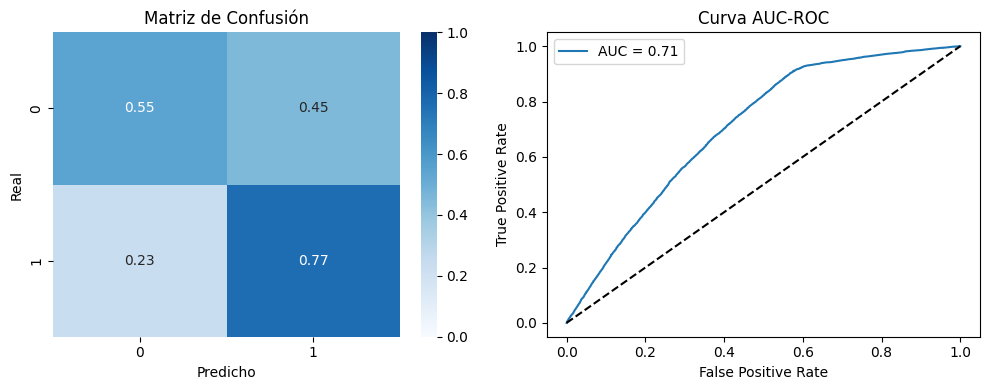

              precision    recall  f1-score   support

           0       0.70      0.55      0.62     17781
           1       0.63      0.77      0.69     17781

    accuracy                           0.66     35562
   macro avg       0.66      0.66      0.65     35562
weighted avg       0.66      0.66      0.65     35562



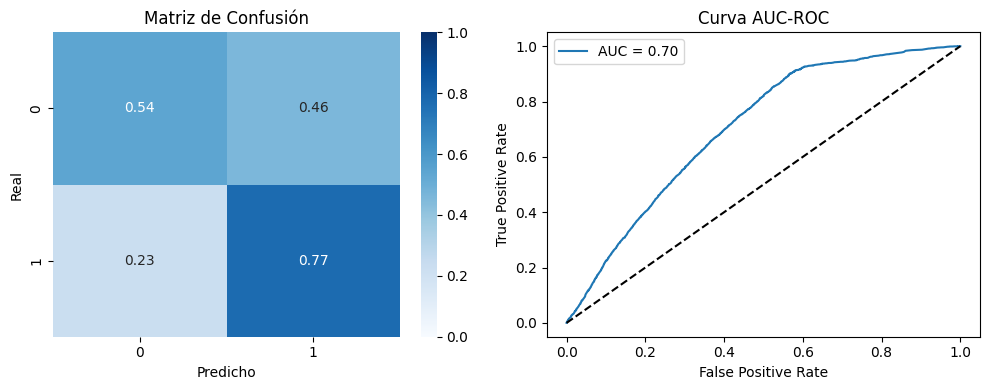

              precision    recall  f1-score   support

           0       0.90      0.54      0.68     17549
           1       0.30      0.77      0.44      4555

    accuracy                           0.59     22104
   macro avg       0.60      0.66      0.56     22104
weighted avg       0.78      0.59      0.63     22104



In [343]:
modelo_final = random_naive_classifier
modelo_final.fit(X_train_resampled, y_train_resampled)

y_train_pred = modelo_final.predict(X = X_train_resampled)
y_test_pred = modelo_final.predict(X_test_trees_filtered)
y_train_proba = modelo_final.predict_proba(X_train_resampled)[:, 1]
y_test_proba = modelo_final.predict_proba(X_test_trees_filtered)[:, 1]
resultados(y_train_resampled, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

## Guardado del modelo final

In [344]:
from imblearn.pipeline import Pipeline as imPipeline

#### Para poder guardar el modelo final en joblib el pipeline no puede tener funciones lambda

In [345]:
# Funcion para el transformador de WaitingTime (reemplazo del lambda)
def waiting_time_replace_fn(df):
    return df.assign(WaitingTime=df['WaitingTime'].where(df['WaitingTime'] >= 0, 0))

# Funcion para el transformador de Age (reemplazo del lambda)
def age_replace_fn(df):
    return df.assign(Age=df['Age'].where(df['Age'] >= 0, 0))

# Pipeline con las clases personalizadas
medical_appointment_final_pipeline = imPipeline([
    ('drop_feature_AppointmentID', drop_feature_AppointmentID),
    ('rare_Neighbourhood_encoder', rare_encoder),
    ('cluster_mapper', cluster_mapper),
    ('drop_feature_Neighbourhood', drop_feature_Neighbourhood),
    ('datetime_converter', datetime_transformer),
    ('calculate_waiting_time', waiting_time_transformer),
    ('waiting_time_replace', FunctionTransformer(waiting_time_replace_fn, validate=False)),  # Usando el transformador personalizado
    ('extract_hour', hour_transformer),
    ('assign_period_of_day', period_of_day_transformer),
    ('calculate_day_of_week', day_of_week_transformer),
    ('drop_feature_hour', drop_feature_hour),
    ('WaitingTime_Discretiser', WaitingTime_Discretiser),
    ('age_replace', FunctionTransformer(age_replace_fn, validate=False)),  # Usando el transformador personalizado
    ('age_discretiser', costum_age_discretiser),
    ('age_group_mapper', age_group_mapper),
    ('first_time_appointment', first_time_appointment_transformer),
    ('feature_engineering', feature_transformer),
    ('drop_features', drop_features),
    ('dtype_first_converter', dtype_first_converter),
    ('custom_onehot_encoder', drop_binary),
    ('scaler', costum_scaler),
    ('column_name_cleaner', ColumnNameCleaner()),
    ('feature_selection', feature_selection),

    ('balanceo', RandomUnderSampler(sampling_strategy='auto', random_state=0, replacement=False)),
    
    ('modelo', modelo_final)
])


# Entrenar el pipeline completo
medical_appointment_final_pipeline.fit(X_train_raw, y_train_raw)

Pipeline(steps=[('drop_feature_AppointmentID',
                 DropFeatures(features_to_drop=['AppointmentID'])),
                ('rare_Neighbourhood_encoder',
                 RareLabelEncoder(n_categories=20, replace_with='Other',
                                  tol=0.0009047563038895474,
                                  variables=['Neighbourhood'])),
                ('cluster_mapper',
                 ClusterMapper(cluster_dict={'ANDORINHAS': 2,
                                             'ANTÔNIO HONÓRIO': 1,
                                             'ARIOVALDO FAVALESSA': 1,
                                             'BARRO VERME...
                                                'WaitingTime__0_0_1_0_',
                                                'WaitingTime__50_0_inf_',
                                                'ScheduledPeriod_Noche',
                                                'DayOfWeek_Monday',
                                                'DayOfWeek_Saturday',
                                                'DayOfWeek_Tuesday',
                                                'Age_group_Adultos_mayores_60_79_',
                                                'Age_group_Adultos_medios_40_59_',
                                                'Age_group_Infancia_0_6_',
                                                'Age_group_Ni_ez_7_12_'])),
                ('balanceo', RandomUnderSampler(random_state=0)),
                ('modelo', GaussianNB(var_smoothing=0.007485114954993629))])

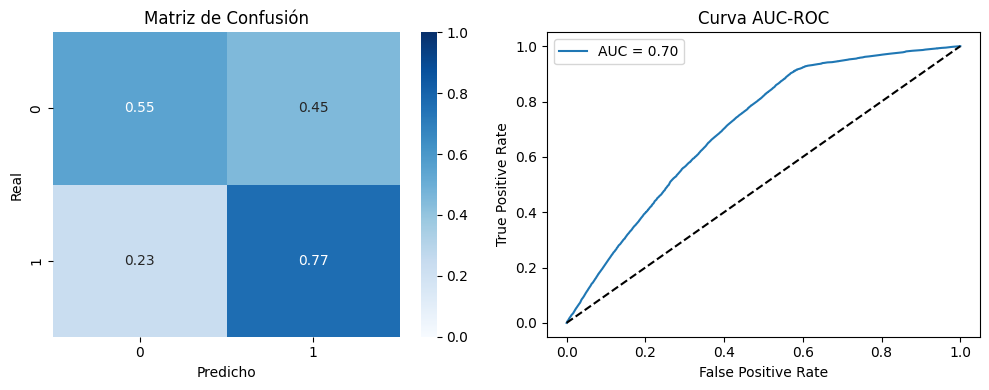

              precision    recall  f1-score   support

           0       0.90      0.55      0.68     70641
           1       0.30      0.77      0.43     17781

    accuracy                           0.59     88422
   macro avg       0.60      0.66      0.56     88422
weighted avg       0.78      0.59      0.63     88422



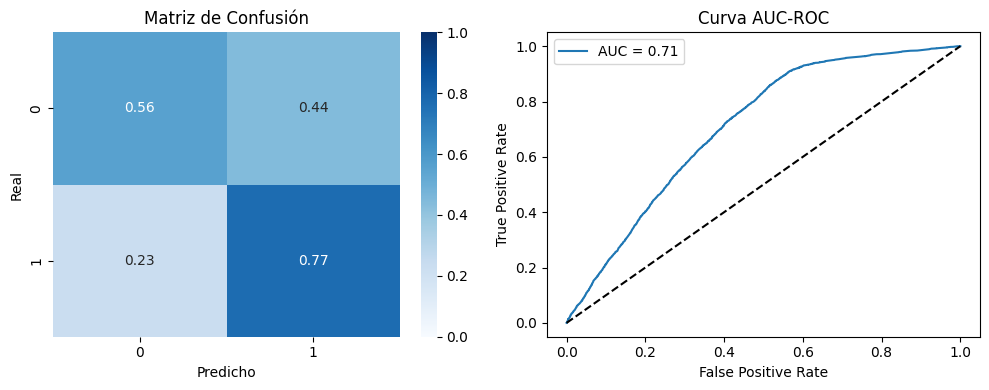

              precision    recall  f1-score   support

           0       0.90      0.56      0.69     17567
           1       0.31      0.77      0.44      4538

    accuracy                           0.60     22105
   macro avg       0.61      0.66      0.56     22105
weighted avg       0.78      0.60      0.64     22105



In [346]:
y_train_pred = medical_appointment_final_pipeline.predict(X = X_train_raw)
y_test_pred = medical_appointment_final_pipeline.predict(X_test_raw)
y_train_proba = medical_appointment_final_pipeline.predict_proba(X_train_raw)[:, 1]
y_test_proba = medical_appointment_final_pipeline.predict_proba(X_test_raw)[:, 1]
resultados(y_train_raw, y_train_pred, y_train_proba)
resultados(y_test_raw, y_test_pred, y_test_proba)

## Guardado de modelo final

In [347]:
import joblib

In [348]:
joblib.dump(medical_appointment_final_pipeline, 'appointment_model.joblib')

['appointment_model.joblib']

### Cargar el modelo y verificar su funcionamiento

In [349]:
loaded_model = joblib.load('appointment_model.joblib')

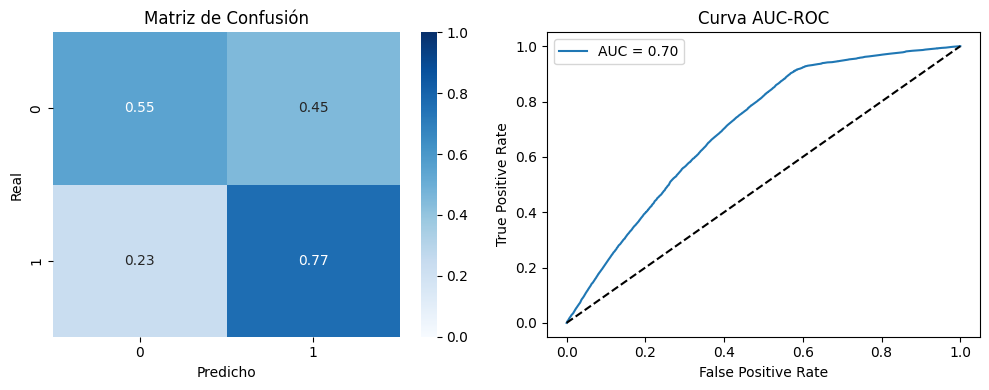

              precision    recall  f1-score   support

           0       0.90      0.55      0.68     70641
           1       0.30      0.77      0.43     17781

    accuracy                           0.59     88422
   macro avg       0.60      0.66      0.56     88422
weighted avg       0.78      0.59      0.63     88422



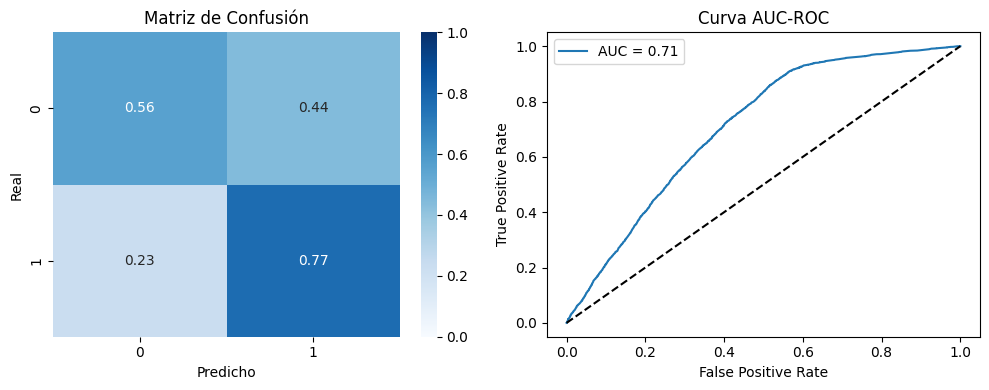

              precision    recall  f1-score   support

           0       0.90      0.56      0.69     17567
           1       0.31      0.77      0.44      4538

    accuracy                           0.60     22105
   macro avg       0.61      0.66      0.56     22105
weighted avg       0.78      0.60      0.64     22105



In [350]:
y_train_pred = loaded_model.predict(X = X_train_raw)
y_test_pred = loaded_model.predict(X_test_raw)
y_train_proba = loaded_model.predict_proba(X_train_raw)[:, 1]
y_test_proba = loaded_model.predict_proba(X_test_raw)[:, 1]
resultados(y_train_raw, y_train_pred, y_train_proba)
resultados(y_test_raw, y_test_pred, y_test_proba)